In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np

Using TensorFlow backend.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import keras.models as km
import keras.layers as kl
import keras.activations as ka
import keras.layers.advanced_activations as kla

In [4]:
from keras import backend

In [5]:
from tensorflow.python.client import device_lib

In [6]:
from IPython import display
import time

In [6]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2436406822065410352, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14615607564618076357
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 806596212033273996
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10913290650
 locality {
   bus_id: 1
   links {
     link {
       device_id: 1
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 incarnation: 5453577826141622531
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 10913290650
 locality {
   bus_id: 1
   links {
     link {
       type: "StreamExecutor"
       strength: 1
     }
   }
 }
 i

In [93]:
def batchnorm(center=True, momentum=0.8):
    return kl.BatchNormalization(center=center, momentum=momentum)

def clayer(nfeatures, kernel_size=(3, 3), strides=(1,1), use_bias=True, **kwargs):
    
    return kl.Conv2D(nfeatures,
                     kernel_size=kernel_size,strides=strides, 
                     use_bias=use_bias, padding='same', **kwargs)

def NonLinearity():
    
    return kl.Activation('relu')
    #return kla.LeakyReLU(alpha=0.1)

def ResBlock(x, nf, dropout=None, **kwargs):
    
    shortcut = x
    x = clayer(nf, **kwargs)(x)
    x = batchnorm()(x)
    x = NonLinearity()(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
    x = clayer(nf, **kwargs)(x)
    x = kl.Add()([x, shortcut])
    x = batchnorm()(x)
    x = NonLinearity()(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
    
    return x

def DownBlock(x, nf, dropout=None, **kwargs):
    """
    This reduces the dimensionality using convolutions.
    """
    
    shortcut = clayer(nf, kernel_size=(1,1), strides=(2,2), **kwargs)(x)
    x = clayer(nf, kernel_size=(2,2), strides=(2,2), **kwargs)(x)
    x = batchnorm()(x)
    x = NonLinearity()(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
    x = clayer(nf, **kwargs)(x)
    x = kl.Add()([x, shortcut])
    x = batchnorm()(x)
    x = NonLinearity()(x)
    if dropout is not None:
        x = kl.Dropout(dropout)(x)
        
    return x


def get_discriminator(input_shape, nclasses=1, nlevels=4, base_features=32, dropout=None, **kwargs):
    """
    Returns a 2D CNN based on the ResNet model.
    Parameters
    ---------
    input_shape : np.array((3))
        Specifies the size of the input data, usually (weight, height, 1)
    
    nlevels : int (optional)
        The number of times (-1) to downsample the resolution
        Default 4.
    base_features: int (optional)
        The number of features the input layer should learn.
        Default 64.
    Returns
    -------
    model :
        The keras model.
    """
    
    input_state = kl.Input(shape=input_shape)

    #Input layer
    x = kl.Conv2D(base_features, (7,7), use_bias=False, padding='same', **kwargs)(input_state)
    x = kl.BatchNormalization(center=False)(x)
    x = NonLinearity()(x)

    for level in range(nlevels):
        
        if level != 0:
            # This layer ups the number of features while downsampling spatially
            x = DownBlock(x, base_features*2**level, dropout=dropout, **kwargs)
    
        x = ResBlock(x, base_features*2**level, dropout=dropout, **kwargs)
        x = ResBlock(x, base_features*2**level, dropout=dropout, **kwargs)
        #if level in [1, 2]:
        #    x = ResBlock(x, base_features*2**level, dropout=dropout, **kwargs)

    #x = kl.GlobalAvgPool2D()(x)
    x = kl.Flatten()(x)
    x = kl.Dense(units=256, activation='relu')(x)
    x = kl.Dropout(0.8)(x)
    
    #Sigmoid goes with binary crossentropy
    x = kl.Dense(units=nclasses, activation='sigmoid')(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model

In [8]:
disc = get_discriminator(input_shape=img_shape, nlevels=3)
disc.summary()

NameError: name 'img_shape' is not defined

In [8]:
#Build Generator which takes noise as input
#model.add(Dense(256, input_dim=latent_dim))

def UpBlock(x, nf, dropout=None, **kwargs):
    """
    This increases the dimensionality using transposed convolutions.
    """
    
    shortcut = kl.Conv2DTranspose(nf, kernel_size=(1,1), strides=(2,2), **kwargs)(x)
    
    x = kl.Conv2DTranspose(nf, kernel_size=(3, 3), strides=(2,2), padding='same')(x)
    x = batchnorm()(x)
    x = NonLinearity()(x)
    
    x = clayer(nf, **kwargs)(x)
    x = kl.Add()([x, shortcut])
    x = batchnorm()(x)
    x = NonLinearity()(x)
    
    return x

def get_generator(input_shape, image_shape, nlevels=4, base_features=32, dropout=None, **kwargs):
    
    """
    Takes in noise and returns an image
    """

    # Get the input and reshape it into an image of the right shape.
    input_state = kl.Input(shape=input_shape)
    
    ii_width = image_shape[0]//2**nlevels
    ii_height = image_shape[1]//2**nlevels
    
    x = kl.Dense(units=ii_width*ii_height*base_features)(input_state)
    x = NonLinearity()(x)
    x = kl.Reshape((ii_width, ii_height, base_features))(x)
    
    x = ResBlock(x, base_features, dropout=dropout, **kwargs)
    #x = ResBlock(x, base_features, dropout=dropout, **kwargs)

    for level in range(nlevels):
        
        #Reduce nfeatures by half
        x = UpBlock(x, base_features//2**(level+1), dropout=dropout, **kwargs)
    
        x = ResBlock(x, base_features//2**(level+1), dropout=dropout, **kwargs)
        x = ResBlock(x, base_features//2**(level+1), dropout=dropout, **kwargs)
        
    # This last layer is linear
    #x = kl.Conv2D(1, kernel_size=(7,7), strides=(1,1), padding='same', activation='tanh')(x)
    x = kl.Conv2D(1, kernel_size=(7,7), strides=(1,1), padding='same')(x)
    #x = kl.Reshape((image_shape[0], image_shape[1], 1))(x)

    model = km.Model(inputs = input_state, outputs = x)

    return model

In [53]:
gen = get_generator(input_shape=(latent_dim,), image_shape=(img_rows, img_cols), nlevels=3)
gen.summary()

8 8
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2048)         206848      input_3[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 8, 8, 32)     0           dense_3[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose_4 (Conv2DTrans (None, 16, 16, 16)   4624        reshape_3[0][0]                  
__________________________________________________________________________________________________
batch_

In [106]:
model=None
backend.clear_session()

In [107]:
# Define some metadata
img_rows = 64
img_cols = 64
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 128

In [108]:
#Ok let's build and compile everything
#optimizer = Adam(1e-5, 0.5)
optimizer = Adam(1e-4, 0.8, 0.99)

# Build and compile the discriminator
discriminator = get_discriminator(input_shape=img_shape, nlevels=4, base_features=16)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = get_generator(input_shape=(latent_dim,), base_features=16*2**4,
                          image_shape=(img_rows, img_cols), nlevels=4)

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [14]:
def grf_2d(A, alpha, image_shape=(64, 64), seed=None, normalize=True):
    
    if seed is not None:
        np.random.seed(seed=seed)
        
    grf = np.random.normal(size=image_shape)
    
    kx = np.fft.fftfreq(image_shape[0])
    ky = np.fft.fftfreq(image_shape[1])
    kk = np.sqrt(kx[:, np.newaxis]**2 + ky[np.newaxis, :]**2)
    
    kk[0, 0] = A
    pk = A*kk**alpha
    
    grf = np.fft.ifft2(np.fft.fft2(grf)*np.sqrt(pk)).real
    
    if normalize:
        grf = (grf - np.mean(grf))/np.std(grf)
    
    return grf


def gspot(sigma, std, image_shape=(64, 64), seed=None, normalize=True):
    
    if seed is not None:
        np.random.seed(seed=seed)
        
    noise = np.random.normal(0, std, size=image_shape)
    
    x = np.arange(image_shape[0]) - image_shape[0]/2
    y = np.arange(image_shape[1]) - image_shape[1]/2
    r = np.sqrt(x[:, np.newaxis]**2 + y[np.newaxis, :]**2)
    
    gauss = np.exp(-r**2 /(2*sigma**2))
    
    img = gauss + noise
    
    if normalize:
        img = (img - np.mean(img))/np.std(img)
    
    return img

In [14]:
grfe = grf_2d(1.0, alpha=-2.0)

1.3877787807814457e-17 0.9999999999999999


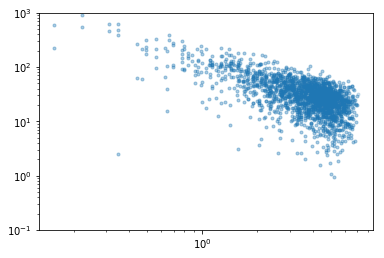

In [19]:
kx = np.fft.fftfreq(64, d=0.1)
ky = np.fft.fftfreq(64, d=0.1)
kk = np.sqrt(kx[:, np.newaxis]**2 + ky[np.newaxis, :]**2)

plot(kk.ravel(), abs(np.fft.fft2(grfe)).ravel(), '.', alpha=0.2)
yscale('log')
xscale('log')
ylim(1e-1, 1e3)

print(np.mean(grfe), np.std(grfe))

In [20]:
from sklearn.utils import shuffle

0 [D loss: 1.627150, acc.: 42.19%] [G loss: 0.575279]


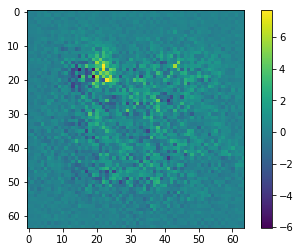

1 [D loss: 1.570806, acc.: 40.62%] [G loss: 0.867400]
2 [D loss: 1.117775, acc.: 46.88%] [G loss: 0.797932]
3 [D loss: 0.788642, acc.: 65.62%] [G loss: 1.372505]
4 [D loss: 0.675362, acc.: 64.06%] [G loss: 1.519963]
5 [D loss: 0.848553, acc.: 71.88%] [G loss: 1.511373]
6 [D loss: 0.698323, acc.: 64.06%] [G loss: 1.756851]
7 [D loss: 0.861402, acc.: 56.25%] [G loss: 2.029300]
8 [D loss: 0.521048, acc.: 78.12%] [G loss: 1.409459]
9 [D loss: 0.686074, acc.: 70.31%] [G loss: 1.425582]
10 [D loss: 0.412320, acc.: 85.94%] [G loss: 1.791536]
11 [D loss: 0.446584, acc.: 76.56%] [G loss: 1.506154]
12 [D loss: 0.466924, acc.: 79.69%] [G loss: 1.468807]
13 [D loss: 0.511296, acc.: 79.69%] [G loss: 2.446302]
14 [D loss: 0.413645, acc.: 79.69%] [G loss: 2.041341]
15 [D loss: 0.367865, acc.: 82.81%] [G loss: 2.116783]
16 [D loss: 0.423889, acc.: 79.69%] [G loss: 2.079590]
17 [D loss: 0.419740, acc.: 84.38%] [G loss: 1.944225]
18 [D loss: 0.500603, acc.: 87.50%] [G loss: 2.374990]
19 [D loss: 0.38349

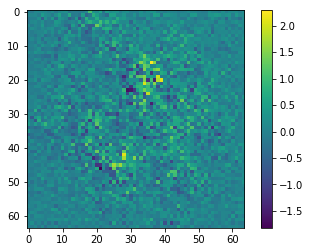

21 [D loss: 0.307262, acc.: 89.06%] [G loss: 2.147577]
22 [D loss: 0.312639, acc.: 89.06%] [G loss: 1.850080]
23 [D loss: 0.388304, acc.: 82.81%] [G loss: 2.040770]
24 [D loss: 0.439755, acc.: 89.06%] [G loss: 2.297483]
25 [D loss: 0.238931, acc.: 89.06%] [G loss: 1.848191]
26 [D loss: 0.263736, acc.: 89.06%] [G loss: 3.256614]
27 [D loss: 0.393384, acc.: 92.19%] [G loss: 2.291369]
28 [D loss: 0.214002, acc.: 93.75%] [G loss: 2.988216]
29 [D loss: 0.176458, acc.: 96.88%] [G loss: 2.687929]
30 [D loss: 0.171729, acc.: 93.75%] [G loss: 3.177391]
31 [D loss: 0.236737, acc.: 93.75%] [G loss: 2.728549]
32 [D loss: 0.175703, acc.: 93.75%] [G loss: 3.074314]
33 [D loss: 0.174582, acc.: 95.31%] [G loss: 3.946801]
34 [D loss: 0.143095, acc.: 98.44%] [G loss: 3.125549]
35 [D loss: 0.185075, acc.: 95.31%] [G loss: 3.190827]
36 [D loss: 0.238496, acc.: 95.31%] [G loss: 3.147731]
37 [D loss: 0.346752, acc.: 89.06%] [G loss: 2.425981]
38 [D loss: 0.144867, acc.: 93.75%] [G loss: 4.372993]
39 [D loss

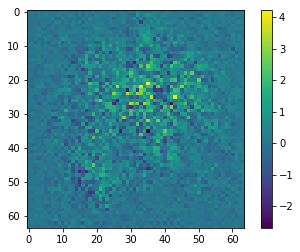

41 [D loss: 0.240171, acc.: 92.19%] [G loss: 3.937525]
42 [D loss: 0.169375, acc.: 93.75%] [G loss: 4.613661]
43 [D loss: 0.321158, acc.: 93.75%] [G loss: 3.935176]
44 [D loss: 0.195863, acc.: 93.75%] [G loss: 4.270794]
45 [D loss: 0.158927, acc.: 92.19%] [G loss: 2.678026]
46 [D loss: 0.081281, acc.: 98.44%] [G loss: 3.442266]
47 [D loss: 0.113160, acc.: 93.75%] [G loss: 3.252499]
48 [D loss: 0.126781, acc.: 95.31%] [G loss: 3.701507]
49 [D loss: 0.263157, acc.: 90.62%] [G loss: 3.023155]
50 [D loss: 0.189482, acc.: 95.31%] [G loss: 3.303678]
51 [D loss: 0.054397, acc.: 100.00%] [G loss: 5.245487]
52 [D loss: 0.134658, acc.: 96.88%] [G loss: 3.818592]
53 [D loss: 0.120714, acc.: 95.31%] [G loss: 5.042143]
54 [D loss: 0.075278, acc.: 96.88%] [G loss: 4.190318]
55 [D loss: 0.162515, acc.: 95.31%] [G loss: 5.091867]
56 [D loss: 0.051906, acc.: 100.00%] [G loss: 4.895320]
57 [D loss: 0.058597, acc.: 98.44%] [G loss: 4.734214]
58 [D loss: 0.134422, acc.: 96.88%] [G loss: 3.359517]
59 [D lo

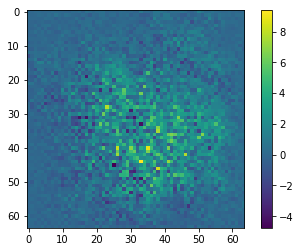

61 [D loss: 0.071971, acc.: 98.44%] [G loss: 3.728664]
62 [D loss: 0.039291, acc.: 100.00%] [G loss: 4.896851]
63 [D loss: 0.038009, acc.: 100.00%] [G loss: 4.765360]
64 [D loss: 0.172912, acc.: 95.31%] [G loss: 4.968897]
65 [D loss: 0.125296, acc.: 95.31%] [G loss: 4.850218]
66 [D loss: 0.102503, acc.: 95.31%] [G loss: 5.227238]
67 [D loss: 0.107668, acc.: 96.88%] [G loss: 5.137780]
68 [D loss: 0.110542, acc.: 95.31%] [G loss: 3.751249]
69 [D loss: 0.077347, acc.: 96.88%] [G loss: 4.433621]
70 [D loss: 0.068543, acc.: 98.44%] [G loss: 5.470109]
71 [D loss: 0.050919, acc.: 98.44%] [G loss: 4.924992]
72 [D loss: 0.063870, acc.: 98.44%] [G loss: 4.405992]
73 [D loss: 0.201663, acc.: 92.19%] [G loss: 4.443851]
74 [D loss: 0.035369, acc.: 100.00%] [G loss: 4.255768]
75 [D loss: 0.181879, acc.: 90.62%] [G loss: 5.492690]
76 [D loss: 0.051180, acc.: 98.44%] [G loss: 5.469103]
77 [D loss: 0.024603, acc.: 100.00%] [G loss: 5.775033]
78 [D loss: 0.146514, acc.: 95.31%] [G loss: 6.497551]
79 [D 

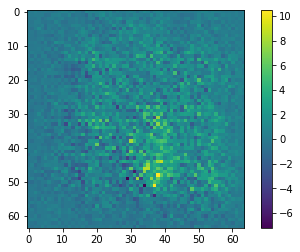

81 [D loss: 0.081302, acc.: 98.44%] [G loss: 5.220898]
82 [D loss: 0.081046, acc.: 96.88%] [G loss: 5.014157]
83 [D loss: 0.084204, acc.: 96.88%] [G loss: 5.439827]
84 [D loss: 0.099501, acc.: 95.31%] [G loss: 5.209334]
85 [D loss: 0.072505, acc.: 96.88%] [G loss: 5.396096]
86 [D loss: 0.023828, acc.: 100.00%] [G loss: 5.255060]
87 [D loss: 0.053853, acc.: 98.44%] [G loss: 6.023474]
88 [D loss: 0.099896, acc.: 93.75%] [G loss: 5.700459]
89 [D loss: 0.161539, acc.: 92.19%] [G loss: 4.599969]
90 [D loss: 0.065609, acc.: 98.44%] [G loss: 5.046977]
91 [D loss: 0.089473, acc.: 96.88%] [G loss: 4.784946]
92 [D loss: 0.152216, acc.: 96.88%] [G loss: 4.702198]
93 [D loss: 0.118921, acc.: 95.31%] [G loss: 5.133131]
94 [D loss: 0.071100, acc.: 96.88%] [G loss: 5.311772]
95 [D loss: 0.094041, acc.: 96.88%] [G loss: 5.279243]
96 [D loss: 0.123619, acc.: 92.19%] [G loss: 5.415353]
97 [D loss: 0.034436, acc.: 100.00%] [G loss: 5.675341]
98 [D loss: 0.056880, acc.: 98.44%] [G loss: 4.866863]
99 [D lo

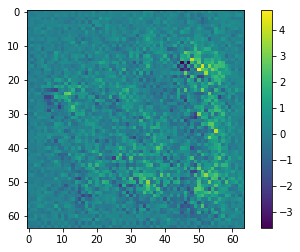

101 [D loss: 0.037612, acc.: 98.44%] [G loss: 6.250075]
102 [D loss: 0.036913, acc.: 98.44%] [G loss: 5.862072]
103 [D loss: 0.062663, acc.: 98.44%] [G loss: 6.031795]
104 [D loss: 0.102121, acc.: 95.31%] [G loss: 4.785079]
105 [D loss: 0.266508, acc.: 93.75%] [G loss: 4.186769]
106 [D loss: 0.396938, acc.: 87.50%] [G loss: 4.330430]
107 [D loss: 0.034370, acc.: 98.44%] [G loss: 6.284671]
108 [D loss: 0.035929, acc.: 100.00%] [G loss: 5.809551]
109 [D loss: 0.115198, acc.: 95.31%] [G loss: 4.503134]
110 [D loss: 0.147215, acc.: 96.88%] [G loss: 5.446540]
111 [D loss: 0.117294, acc.: 98.44%] [G loss: 5.665460]
112 [D loss: 0.102771, acc.: 98.44%] [G loss: 4.294618]
113 [D loss: 0.128904, acc.: 95.31%] [G loss: 4.353292]
114 [D loss: 0.178798, acc.: 95.31%] [G loss: 5.010984]
115 [D loss: 0.221747, acc.: 92.19%] [G loss: 4.969905]
116 [D loss: 0.310320, acc.: 87.50%] [G loss: 3.979973]
117 [D loss: 0.258415, acc.: 92.19%] [G loss: 4.026400]
118 [D loss: 0.058646, acc.: 98.44%] [G loss: 3

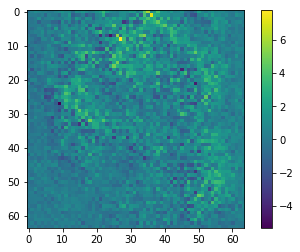

121 [D loss: 0.151701, acc.: 93.75%] [G loss: 5.150290]
122 [D loss: 0.303689, acc.: 85.94%] [G loss: 4.442911]
123 [D loss: 0.343178, acc.: 87.50%] [G loss: 5.002375]
124 [D loss: 0.207216, acc.: 92.19%] [G loss: 2.969620]
125 [D loss: 0.186961, acc.: 90.62%] [G loss: 4.310455]
126 [D loss: 0.030010, acc.: 100.00%] [G loss: 3.792217]
127 [D loss: 0.053642, acc.: 100.00%] [G loss: 5.044999]
128 [D loss: 0.111655, acc.: 96.88%] [G loss: 4.178847]
129 [D loss: 0.213626, acc.: 89.06%] [G loss: 5.034922]
130 [D loss: 0.067197, acc.: 96.88%] [G loss: 5.822315]
131 [D loss: 0.074776, acc.: 100.00%] [G loss: 4.046602]
132 [D loss: 0.285037, acc.: 92.19%] [G loss: 3.905065]
133 [D loss: 0.173512, acc.: 95.31%] [G loss: 4.100085]
134 [D loss: 0.165930, acc.: 93.75%] [G loss: 3.662783]
135 [D loss: 0.073354, acc.: 98.44%] [G loss: 4.000705]
136 [D loss: 0.113772, acc.: 95.31%] [G loss: 4.438669]
137 [D loss: 0.160064, acc.: 95.31%] [G loss: 4.522602]
138 [D loss: 0.048247, acc.: 100.00%] [G loss

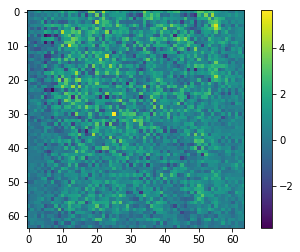

141 [D loss: 0.102912, acc.: 96.88%] [G loss: 4.801960]
142 [D loss: 0.143706, acc.: 93.75%] [G loss: 3.166433]
143 [D loss: 0.151973, acc.: 90.62%] [G loss: 3.633457]
144 [D loss: 0.264584, acc.: 93.75%] [G loss: 3.517894]
145 [D loss: 0.129148, acc.: 96.88%] [G loss: 2.775242]
146 [D loss: 0.060436, acc.: 98.44%] [G loss: 4.189477]
147 [D loss: 0.204927, acc.: 95.31%] [G loss: 5.165101]
148 [D loss: 0.076396, acc.: 95.31%] [G loss: 5.419299]
149 [D loss: 0.268360, acc.: 87.50%] [G loss: 4.739999]
150 [D loss: 0.183434, acc.: 93.75%] [G loss: 2.770772]
151 [D loss: 0.162369, acc.: 89.06%] [G loss: 5.154617]
152 [D loss: 0.100912, acc.: 96.88%] [G loss: 6.356135]
153 [D loss: 0.172439, acc.: 89.06%] [G loss: 5.132504]
154 [D loss: 0.340926, acc.: 89.06%] [G loss: 4.068343]
155 [D loss: 0.184736, acc.: 92.19%] [G loss: 4.519194]
156 [D loss: 0.230899, acc.: 92.19%] [G loss: 3.533847]
157 [D loss: 0.125213, acc.: 96.88%] [G loss: 4.680865]
158 [D loss: 0.096696, acc.: 95.31%] [G loss: 4.

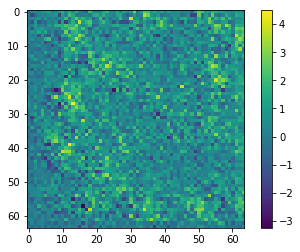

161 [D loss: 0.082803, acc.: 95.31%] [G loss: 4.679267]
162 [D loss: 0.411888, acc.: 84.38%] [G loss: 4.435042]
163 [D loss: 0.326257, acc.: 84.38%] [G loss: 4.104179]
164 [D loss: 0.217134, acc.: 89.06%] [G loss: 4.047184]
165 [D loss: 0.378611, acc.: 89.06%] [G loss: 4.264396]
166 [D loss: 0.505842, acc.: 76.56%] [G loss: 6.314692]
167 [D loss: 0.542212, acc.: 82.81%] [G loss: 5.480189]
168 [D loss: 0.365858, acc.: 82.81%] [G loss: 4.291561]
169 [D loss: 0.284996, acc.: 92.19%] [G loss: 3.279982]
170 [D loss: 0.370984, acc.: 85.94%] [G loss: 2.404229]
171 [D loss: 0.268971, acc.: 89.06%] [G loss: 3.918068]
172 [D loss: 0.235251, acc.: 87.50%] [G loss: 3.164713]
173 [D loss: 0.268633, acc.: 85.94%] [G loss: 1.777326]
174 [D loss: 0.461464, acc.: 76.56%] [G loss: 1.800800]
175 [D loss: 0.163604, acc.: 90.62%] [G loss: 2.588624]
176 [D loss: 0.272985, acc.: 90.62%] [G loss: 4.603356]
177 [D loss: 0.370199, acc.: 82.81%] [G loss: 3.570065]
178 [D loss: 0.156766, acc.: 92.19%] [G loss: 4.

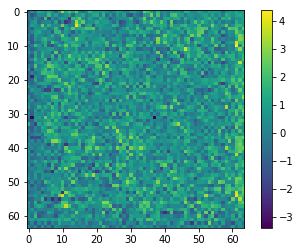

181 [D loss: 0.327180, acc.: 87.50%] [G loss: 3.490631]
182 [D loss: 0.464787, acc.: 85.94%] [G loss: 3.630335]
183 [D loss: 0.254134, acc.: 90.62%] [G loss: 4.138731]
184 [D loss: 0.389574, acc.: 87.50%] [G loss: 3.241709]
185 [D loss: 0.538896, acc.: 76.56%] [G loss: 3.612111]
186 [D loss: 0.258670, acc.: 89.06%] [G loss: 4.305546]
187 [D loss: 0.138994, acc.: 95.31%] [G loss: 3.923706]
188 [D loss: 0.341801, acc.: 85.94%] [G loss: 3.721014]
189 [D loss: 0.176883, acc.: 90.62%] [G loss: 3.217904]
190 [D loss: 0.266245, acc.: 87.50%] [G loss: 3.748214]
191 [D loss: 0.283990, acc.: 85.94%] [G loss: 2.287932]
192 [D loss: 0.218256, acc.: 90.62%] [G loss: 2.821292]
193 [D loss: 0.208556, acc.: 90.62%] [G loss: 2.543426]
194 [D loss: 0.245547, acc.: 89.06%] [G loss: 2.784482]
195 [D loss: 0.160179, acc.: 95.31%] [G loss: 2.158128]
196 [D loss: 0.622605, acc.: 84.38%] [G loss: 5.794258]
197 [D loss: 0.305911, acc.: 89.06%] [G loss: 5.347638]
198 [D loss: 0.365040, acc.: 84.38%] [G loss: 3.

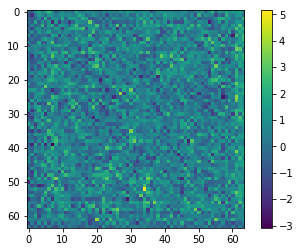

201 [D loss: 0.292819, acc.: 87.50%] [G loss: 3.978135]
202 [D loss: 0.207675, acc.: 95.31%] [G loss: 4.590670]
203 [D loss: 0.200098, acc.: 90.62%] [G loss: 4.311852]
204 [D loss: 0.227339, acc.: 89.06%] [G loss: 3.343459]
205 [D loss: 0.208530, acc.: 92.19%] [G loss: 2.661476]
206 [D loss: 0.279789, acc.: 84.38%] [G loss: 3.359211]
207 [D loss: 0.101370, acc.: 98.44%] [G loss: 4.067302]
208 [D loss: 0.189847, acc.: 92.19%] [G loss: 4.244174]
209 [D loss: 0.224308, acc.: 92.19%] [G loss: 3.566711]
210 [D loss: 0.470895, acc.: 79.69%] [G loss: 4.218310]
211 [D loss: 0.167898, acc.: 92.19%] [G loss: 4.479136]
212 [D loss: 0.306472, acc.: 87.50%] [G loss: 5.612453]
213 [D loss: 0.367635, acc.: 84.38%] [G loss: 4.898889]
214 [D loss: 0.539190, acc.: 79.69%] [G loss: 5.235430]
215 [D loss: 0.102064, acc.: 96.88%] [G loss: 4.466756]
216 [D loss: 0.134536, acc.: 92.19%] [G loss: 4.276353]
217 [D loss: 0.089517, acc.: 96.88%] [G loss: 3.909270]
218 [D loss: 0.281102, acc.: 84.38%] [G loss: 5.

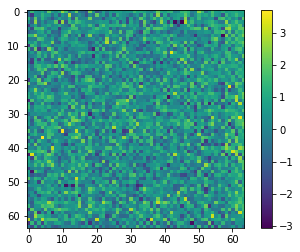

221 [D loss: 0.238241, acc.: 87.50%] [G loss: 4.554163]
222 [D loss: 0.333833, acc.: 84.38%] [G loss: 3.459677]
223 [D loss: 0.317401, acc.: 87.50%] [G loss: 3.788627]
224 [D loss: 0.178250, acc.: 93.75%] [G loss: 4.979385]
225 [D loss: 0.385953, acc.: 79.69%] [G loss: 4.653883]
226 [D loss: 0.329411, acc.: 89.06%] [G loss: 3.972062]
227 [D loss: 0.265242, acc.: 90.62%] [G loss: 2.732742]
228 [D loss: 0.279212, acc.: 84.38%] [G loss: 3.202986]
229 [D loss: 0.431034, acc.: 82.81%] [G loss: 3.510888]
230 [D loss: 0.212446, acc.: 89.06%] [G loss: 4.664591]
231 [D loss: 0.465002, acc.: 82.81%] [G loss: 3.764518]
232 [D loss: 0.171252, acc.: 93.75%] [G loss: 3.837555]
233 [D loss: 0.279903, acc.: 87.50%] [G loss: 3.396867]
234 [D loss: 0.165432, acc.: 95.31%] [G loss: 2.812205]
235 [D loss: 0.329924, acc.: 87.50%] [G loss: 2.844285]
236 [D loss: 0.365891, acc.: 84.38%] [G loss: 2.519178]
237 [D loss: 0.334944, acc.: 87.50%] [G loss: 2.789309]
238 [D loss: 0.318961, acc.: 85.94%] [G loss: 3.

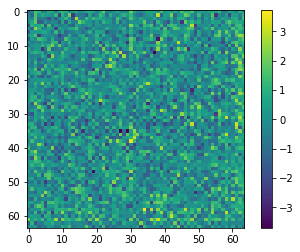

241 [D loss: 0.173088, acc.: 92.19%] [G loss: 3.104545]
242 [D loss: 0.501001, acc.: 81.25%] [G loss: 2.978713]
243 [D loss: 0.291683, acc.: 82.81%] [G loss: 3.650788]
244 [D loss: 0.243990, acc.: 92.19%] [G loss: 3.759920]
245 [D loss: 0.335673, acc.: 85.94%] [G loss: 4.306243]
246 [D loss: 0.209896, acc.: 92.19%] [G loss: 3.394188]
247 [D loss: 0.345019, acc.: 87.50%] [G loss: 3.487994]
248 [D loss: 0.300353, acc.: 90.62%] [G loss: 4.043796]
249 [D loss: 0.141388, acc.: 96.88%] [G loss: 3.090467]
250 [D loss: 0.134456, acc.: 95.31%] [G loss: 3.562141]
251 [D loss: 0.243585, acc.: 87.50%] [G loss: 3.447849]
252 [D loss: 0.304885, acc.: 89.06%] [G loss: 4.115999]
253 [D loss: 0.145816, acc.: 95.31%] [G loss: 3.692135]
254 [D loss: 0.157872, acc.: 92.19%] [G loss: 4.337972]
255 [D loss: 0.150339, acc.: 93.75%] [G loss: 4.272090]
256 [D loss: 0.127935, acc.: 96.88%] [G loss: 4.505053]
257 [D loss: 0.174874, acc.: 92.19%] [G loss: 3.695139]
258 [D loss: 0.205420, acc.: 92.19%] [G loss: 3.

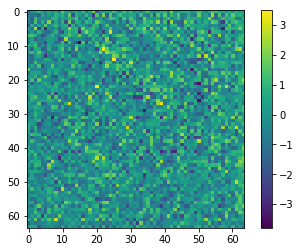

261 [D loss: 0.096124, acc.: 96.88%] [G loss: 5.713702]
262 [D loss: 0.227812, acc.: 89.06%] [G loss: 4.586776]
263 [D loss: 0.105613, acc.: 96.88%] [G loss: 4.570251]
264 [D loss: 0.177981, acc.: 90.62%] [G loss: 4.374422]
265 [D loss: 0.201159, acc.: 92.19%] [G loss: 3.445454]
266 [D loss: 0.172185, acc.: 92.19%] [G loss: 5.621896]
267 [D loss: 0.081705, acc.: 98.44%] [G loss: 5.005844]
268 [D loss: 0.169858, acc.: 89.06%] [G loss: 5.184089]
269 [D loss: 0.276770, acc.: 93.75%] [G loss: 4.475579]
270 [D loss: 0.077696, acc.: 93.75%] [G loss: 4.130070]
271 [D loss: 0.147609, acc.: 93.75%] [G loss: 3.974428]
272 [D loss: 0.166715, acc.: 92.19%] [G loss: 3.789060]
273 [D loss: 0.040437, acc.: 100.00%] [G loss: 5.278722]
274 [D loss: 0.084661, acc.: 96.88%] [G loss: 4.250946]
275 [D loss: 0.107281, acc.: 95.31%] [G loss: 5.169709]
276 [D loss: 0.035498, acc.: 100.00%] [G loss: 5.078965]
277 [D loss: 0.190571, acc.: 92.19%] [G loss: 4.648449]
278 [D loss: 0.214929, acc.: 90.62%] [G loss: 

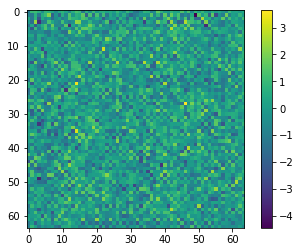

281 [D loss: 0.224763, acc.: 89.06%] [G loss: 5.104822]
282 [D loss: 0.104586, acc.: 93.75%] [G loss: 4.339728]
283 [D loss: 0.135955, acc.: 93.75%] [G loss: 4.575105]
284 [D loss: 0.122476, acc.: 93.75%] [G loss: 5.753819]
285 [D loss: 0.105328, acc.: 95.31%] [G loss: 5.029407]
286 [D loss: 0.092038, acc.: 96.88%] [G loss: 5.897857]
287 [D loss: 0.136892, acc.: 95.31%] [G loss: 5.190694]
288 [D loss: 0.043204, acc.: 100.00%] [G loss: 3.876114]
289 [D loss: 0.109030, acc.: 95.31%] [G loss: 5.011367]
290 [D loss: 0.023739, acc.: 100.00%] [G loss: 5.326714]
291 [D loss: 0.128482, acc.: 98.44%] [G loss: 6.422249]
292 [D loss: 0.119094, acc.: 93.75%] [G loss: 6.361871]
293 [D loss: 0.079114, acc.: 96.88%] [G loss: 6.884858]
294 [D loss: 0.112467, acc.: 96.88%] [G loss: 8.244476]
295 [D loss: 0.099639, acc.: 95.31%] [G loss: 6.685687]
296 [D loss: 0.040844, acc.: 100.00%] [G loss: 6.685421]
297 [D loss: 0.120696, acc.: 95.31%] [G loss: 5.497550]
298 [D loss: 0.110252, acc.: 95.31%] [G loss:

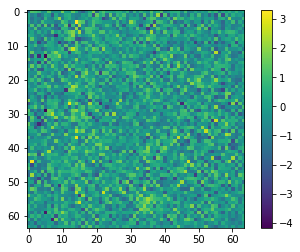

301 [D loss: 0.045960, acc.: 98.44%] [G loss: 6.422466]
302 [D loss: 0.095709, acc.: 95.31%] [G loss: 4.795869]
303 [D loss: 0.222863, acc.: 92.19%] [G loss: 4.949841]
304 [D loss: 0.058855, acc.: 98.44%] [G loss: 7.010862]
305 [D loss: 0.133769, acc.: 95.31%] [G loss: 6.630845]
306 [D loss: 0.042920, acc.: 100.00%] [G loss: 6.940626]
307 [D loss: 0.144739, acc.: 93.75%] [G loss: 6.383312]
308 [D loss: 0.216684, acc.: 95.31%] [G loss: 4.908741]
309 [D loss: 0.059247, acc.: 98.44%] [G loss: 6.668727]
310 [D loss: 0.085848, acc.: 96.88%] [G loss: 5.717171]
311 [D loss: 0.148541, acc.: 93.75%] [G loss: 4.682248]
312 [D loss: 0.223857, acc.: 93.75%] [G loss: 5.554914]
313 [D loss: 0.119847, acc.: 95.31%] [G loss: 6.710960]
314 [D loss: 0.068997, acc.: 96.88%] [G loss: 7.004103]
315 [D loss: 0.247222, acc.: 90.62%] [G loss: 5.797663]
316 [D loss: 0.074131, acc.: 96.88%] [G loss: 5.713403]
317 [D loss: 0.206731, acc.: 95.31%] [G loss: 4.845283]
318 [D loss: 0.152067, acc.: 93.75%] [G loss: 7

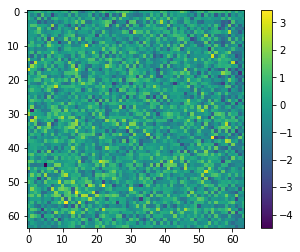

321 [D loss: 0.067433, acc.: 100.00%] [G loss: 4.395539]
322 [D loss: 0.236558, acc.: 90.62%] [G loss: 5.896537]
323 [D loss: 0.793060, acc.: 73.44%] [G loss: 7.826808]
324 [D loss: 0.048870, acc.: 100.00%] [G loss: 10.912506]
325 [D loss: 1.013322, acc.: 65.62%] [G loss: 6.910419]
326 [D loss: 0.563594, acc.: 70.31%] [G loss: 3.181557]
327 [D loss: 1.627231, acc.: 53.12%] [G loss: 3.892099]
328 [D loss: 0.365812, acc.: 84.38%] [G loss: 6.378453]
329 [D loss: 0.469790, acc.: 75.00%] [G loss: 5.816720]
330 [D loss: 0.292155, acc.: 85.94%] [G loss: 4.813857]
331 [D loss: 0.377246, acc.: 76.56%] [G loss: 3.948021]
332 [D loss: 0.437539, acc.: 79.69%] [G loss: 4.090053]
333 [D loss: 0.206758, acc.: 95.31%] [G loss: 4.444445]
334 [D loss: 0.234434, acc.: 87.50%] [G loss: 3.253011]
335 [D loss: 0.297148, acc.: 89.06%] [G loss: 3.590642]
336 [D loss: 0.551586, acc.: 70.31%] [G loss: 3.683352]
337 [D loss: 0.646603, acc.: 60.94%] [G loss: 1.953432]
338 [D loss: 0.265496, acc.: 85.94%] [G loss:

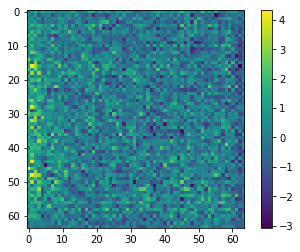

341 [D loss: 0.220350, acc.: 92.19%] [G loss: 3.797788]
342 [D loss: 0.088657, acc.: 98.44%] [G loss: 3.598179]
343 [D loss: 0.278856, acc.: 85.94%] [G loss: 3.164245]
344 [D loss: 0.138545, acc.: 92.19%] [G loss: 4.106291]
345 [D loss: 0.123495, acc.: 95.31%] [G loss: 3.951958]
346 [D loss: 0.113025, acc.: 98.44%] [G loss: 4.243163]
347 [D loss: 0.105702, acc.: 96.88%] [G loss: 4.048314]
348 [D loss: 0.069585, acc.: 98.44%] [G loss: 5.009511]
349 [D loss: 0.049906, acc.: 98.44%] [G loss: 4.968051]
350 [D loss: 0.144586, acc.: 95.31%] [G loss: 5.624974]
351 [D loss: 0.056048, acc.: 100.00%] [G loss: 4.320453]
352 [D loss: 0.122088, acc.: 95.31%] [G loss: 4.734543]
353 [D loss: 0.207776, acc.: 90.62%] [G loss: 4.577882]
354 [D loss: 0.127193, acc.: 96.88%] [G loss: 4.777524]
355 [D loss: 0.223904, acc.: 90.62%] [G loss: 4.579169]
356 [D loss: 0.237233, acc.: 92.19%] [G loss: 5.469934]
357 [D loss: 0.078811, acc.: 98.44%] [G loss: 5.974301]
358 [D loss: 0.079805, acc.: 98.44%] [G loss: 6

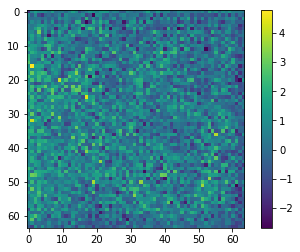

361 [D loss: 0.189091, acc.: 92.19%] [G loss: 4.826919]
362 [D loss: 0.140117, acc.: 96.88%] [G loss: 5.385594]
363 [D loss: 0.105139, acc.: 93.75%] [G loss: 6.157319]
364 [D loss: 0.080194, acc.: 95.31%] [G loss: 5.594961]
365 [D loss: 0.113319, acc.: 96.88%] [G loss: 5.973368]
366 [D loss: 0.060700, acc.: 98.44%] [G loss: 6.609385]
367 [D loss: 0.045947, acc.: 100.00%] [G loss: 5.988005]
368 [D loss: 0.093670, acc.: 96.88%] [G loss: 5.656583]
369 [D loss: 0.077041, acc.: 98.44%] [G loss: 5.042660]
370 [D loss: 0.070324, acc.: 96.88%] [G loss: 5.336476]
371 [D loss: 0.073060, acc.: 100.00%] [G loss: 4.984803]
372 [D loss: 0.035769, acc.: 100.00%] [G loss: 6.549157]
373 [D loss: 0.077245, acc.: 98.44%] [G loss: 5.721957]
374 [D loss: 0.256090, acc.: 92.19%] [G loss: 5.911609]
375 [D loss: 0.088212, acc.: 96.88%] [G loss: 5.807365]
376 [D loss: 0.044837, acc.: 100.00%] [G loss: 6.182306]
377 [D loss: 0.049287, acc.: 100.00%] [G loss: 6.938147]
378 [D loss: 0.055912, acc.: 100.00%] [G lo

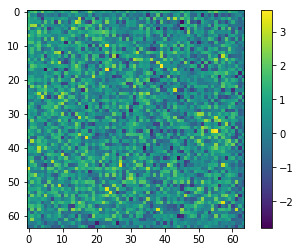

381 [D loss: 0.061456, acc.: 96.88%] [G loss: 6.330750]
382 [D loss: 0.035791, acc.: 98.44%] [G loss: 6.946321]
383 [D loss: 0.018979, acc.: 100.00%] [G loss: 5.721629]
384 [D loss: 0.022615, acc.: 100.00%] [G loss: 6.843154]
385 [D loss: 0.040031, acc.: 98.44%] [G loss: 6.396866]
386 [D loss: 0.037540, acc.: 100.00%] [G loss: 7.927156]
387 [D loss: 0.025330, acc.: 100.00%] [G loss: 8.071287]
388 [D loss: 0.051730, acc.: 96.88%] [G loss: 7.332682]
389 [D loss: 0.103062, acc.: 98.44%] [G loss: 8.159791]
390 [D loss: 0.064322, acc.: 96.88%] [G loss: 9.038691]
391 [D loss: 0.054925, acc.: 100.00%] [G loss: 8.545831]
392 [D loss: 0.035478, acc.: 98.44%] [G loss: 7.671609]
393 [D loss: 0.084831, acc.: 98.44%] [G loss: 6.048203]
394 [D loss: 0.052078, acc.: 96.88%] [G loss: 8.096992]
395 [D loss: 0.099572, acc.: 98.44%] [G loss: 6.945962]
396 [D loss: 0.037286, acc.: 100.00%] [G loss: 7.429222]
397 [D loss: 0.158577, acc.: 93.75%] [G loss: 5.984898]
398 [D loss: 0.150660, acc.: 95.31%] [G lo

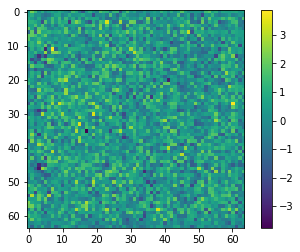

401 [D loss: 0.038719, acc.: 98.44%] [G loss: 9.378064]
402 [D loss: 0.226690, acc.: 90.62%] [G loss: 6.620564]
403 [D loss: 0.193593, acc.: 92.19%] [G loss: 7.534225]
404 [D loss: 0.019227, acc.: 100.00%] [G loss: 9.624699]
405 [D loss: 0.036575, acc.: 98.44%] [G loss: 9.604307]
406 [D loss: 0.058214, acc.: 96.88%] [G loss: 10.260941]
407 [D loss: 0.025236, acc.: 100.00%] [G loss: 10.323614]
408 [D loss: 0.065103, acc.: 98.44%] [G loss: 8.355880]
409 [D loss: 0.043822, acc.: 98.44%] [G loss: 7.266773]
410 [D loss: 0.050406, acc.: 98.44%] [G loss: 7.780102]
411 [D loss: 0.026357, acc.: 100.00%] [G loss: 7.736866]
412 [D loss: 0.040108, acc.: 98.44%] [G loss: 8.744484]
413 [D loss: 0.036265, acc.: 98.44%] [G loss: 8.395994]
414 [D loss: 0.024354, acc.: 100.00%] [G loss: 6.156918]
415 [D loss: 0.207920, acc.: 90.62%] [G loss: 6.557102]
416 [D loss: 0.157448, acc.: 93.75%] [G loss: 7.305329]
417 [D loss: 0.089650, acc.: 96.88%] [G loss: 8.191888]
418 [D loss: 0.353076, acc.: 85.94%] [G lo

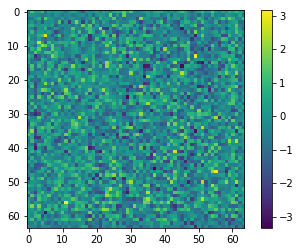

421 [D loss: 0.227796, acc.: 93.75%] [G loss: 7.699629]
422 [D loss: 0.059770, acc.: 96.88%] [G loss: 7.670420]
423 [D loss: 0.075648, acc.: 98.44%] [G loss: 7.987467]
424 [D loss: 0.114897, acc.: 95.31%] [G loss: 6.588919]
425 [D loss: 0.118790, acc.: 95.31%] [G loss: 5.383722]
426 [D loss: 0.065112, acc.: 98.44%] [G loss: 5.872956]
427 [D loss: 0.091720, acc.: 95.31%] [G loss: 4.379258]
428 [D loss: 0.092626, acc.: 96.88%] [G loss: 5.598336]
429 [D loss: 0.046049, acc.: 98.44%] [G loss: 7.656988]
430 [D loss: 0.154388, acc.: 95.31%] [G loss: 7.958562]
431 [D loss: 0.141422, acc.: 96.88%] [G loss: 7.383441]
432 [D loss: 0.113774, acc.: 95.31%] [G loss: 5.727309]
433 [D loss: 0.127950, acc.: 95.31%] [G loss: 6.829506]
434 [D loss: 0.031116, acc.: 100.00%] [G loss: 6.880442]
435 [D loss: 0.060524, acc.: 100.00%] [G loss: 6.765022]
436 [D loss: 0.095106, acc.: 98.44%] [G loss: 6.631206]
437 [D loss: 0.053511, acc.: 98.44%] [G loss: 5.566534]
438 [D loss: 0.088481, acc.: 96.88%] [G loss: 

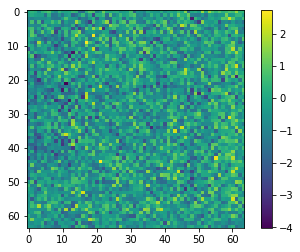

441 [D loss: 0.100764, acc.: 100.00%] [G loss: 5.757635]
442 [D loss: 0.204115, acc.: 89.06%] [G loss: 6.357424]
443 [D loss: 0.067967, acc.: 98.44%] [G loss: 5.989171]
444 [D loss: 0.045766, acc.: 98.44%] [G loss: 8.675097]
445 [D loss: 0.093326, acc.: 96.88%] [G loss: 7.690636]
446 [D loss: 0.030648, acc.: 100.00%] [G loss: 5.959625]
447 [D loss: 0.134412, acc.: 95.31%] [G loss: 6.754345]
448 [D loss: 0.098348, acc.: 95.31%] [G loss: 7.797074]
449 [D loss: 0.058583, acc.: 98.44%] [G loss: 8.409757]
450 [D loss: 0.043405, acc.: 98.44%] [G loss: 9.569535]
451 [D loss: 0.041735, acc.: 100.00%] [G loss: 7.426387]
452 [D loss: 0.259842, acc.: 92.19%] [G loss: 4.887663]
453 [D loss: 0.088649, acc.: 98.44%] [G loss: 7.729773]
454 [D loss: 0.012819, acc.: 100.00%] [G loss: 10.132114]
455 [D loss: 0.165115, acc.: 89.06%] [G loss: 7.928863]
456 [D loss: 0.016182, acc.: 100.00%] [G loss: 5.517304]
457 [D loss: 0.083755, acc.: 96.88%] [G loss: 6.153146]
458 [D loss: 0.021904, acc.: 100.00%] [G l

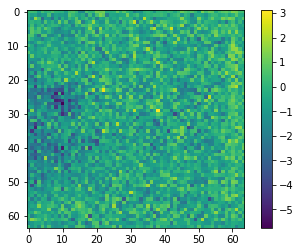

461 [D loss: 0.013129, acc.: 100.00%] [G loss: 9.675596]
462 [D loss: 0.045211, acc.: 96.88%] [G loss: 9.291264]
463 [D loss: 0.017470, acc.: 100.00%] [G loss: 8.089806]
464 [D loss: 0.013247, acc.: 100.00%] [G loss: 7.337096]
465 [D loss: 0.085967, acc.: 98.44%] [G loss: 6.363648]
466 [D loss: 0.079355, acc.: 95.31%] [G loss: 6.691162]
467 [D loss: 0.067761, acc.: 95.31%] [G loss: 6.207187]
468 [D loss: 0.104621, acc.: 96.88%] [G loss: 5.791163]
469 [D loss: 0.042643, acc.: 98.44%] [G loss: 8.349674]
470 [D loss: 0.069923, acc.: 96.88%] [G loss: 8.166286]
471 [D loss: 0.169486, acc.: 96.88%] [G loss: 7.654762]
472 [D loss: 0.059013, acc.: 98.44%] [G loss: 5.712389]
473 [D loss: 0.022179, acc.: 98.44%] [G loss: 6.954523]
474 [D loss: 0.048511, acc.: 98.44%] [G loss: 4.399665]
475 [D loss: 0.070157, acc.: 96.88%] [G loss: 5.310056]
476 [D loss: 0.132543, acc.: 96.88%] [G loss: 9.998096]
477 [D loss: 0.227615, acc.: 89.06%] [G loss: 8.737894]
478 [D loss: 0.042799, acc.: 100.00%] [G loss

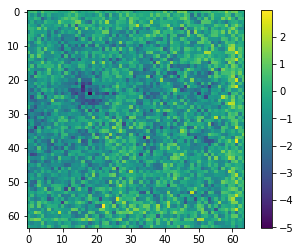

481 [D loss: 0.181837, acc.: 93.75%] [G loss: 6.704022]
482 [D loss: 0.101507, acc.: 98.44%] [G loss: 7.765260]
483 [D loss: 0.012528, acc.: 100.00%] [G loss: 5.648181]
484 [D loss: 0.066489, acc.: 98.44%] [G loss: 6.827539]
485 [D loss: 0.009967, acc.: 100.00%] [G loss: 6.910942]
486 [D loss: 0.190858, acc.: 93.75%] [G loss: 7.991373]
487 [D loss: 0.338807, acc.: 85.94%] [G loss: 6.353289]
488 [D loss: 0.024759, acc.: 100.00%] [G loss: 5.436354]
489 [D loss: 0.086757, acc.: 96.88%] [G loss: 4.713419]
490 [D loss: 0.020369, acc.: 100.00%] [G loss: 7.396326]
491 [D loss: 0.014184, acc.: 100.00%] [G loss: 7.958966]
492 [D loss: 0.016175, acc.: 100.00%] [G loss: 7.115380]
493 [D loss: 0.061548, acc.: 96.88%] [G loss: 7.469410]
494 [D loss: 0.143469, acc.: 96.88%] [G loss: 1.778364]
495 [D loss: 0.593416, acc.: 75.00%] [G loss: 5.620817]
496 [D loss: 0.013684, acc.: 100.00%] [G loss: 11.336189]
497 [D loss: 0.923812, acc.: 73.44%] [G loss: 5.266879]
498 [D loss: 0.254201, acc.: 87.50%] [G 

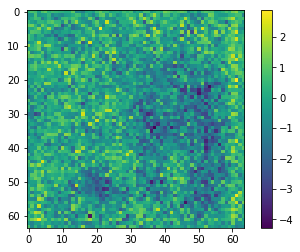

501 [D loss: 0.017586, acc.: 100.00%] [G loss: 7.477595]
502 [D loss: 0.024607, acc.: 100.00%] [G loss: 7.135457]
503 [D loss: 0.011524, acc.: 100.00%] [G loss: 7.086033]
504 [D loss: 0.045632, acc.: 98.44%] [G loss: 9.139652]
505 [D loss: 0.012539, acc.: 100.00%] [G loss: 7.600802]
506 [D loss: 0.151362, acc.: 98.44%] [G loss: 4.930737]
507 [D loss: 0.030035, acc.: 98.44%] [G loss: 5.582068]
508 [D loss: 0.057645, acc.: 98.44%] [G loss: 5.033376]
509 [D loss: 0.041734, acc.: 98.44%] [G loss: 5.076425]
510 [D loss: 0.043490, acc.: 98.44%] [G loss: 5.751477]
511 [D loss: 0.019107, acc.: 100.00%] [G loss: 6.636757]
512 [D loss: 0.231875, acc.: 95.31%] [G loss: 7.017172]
513 [D loss: 0.052563, acc.: 96.88%] [G loss: 7.093391]
514 [D loss: 0.093225, acc.: 98.44%] [G loss: 6.510066]
515 [D loss: 0.333691, acc.: 85.94%] [G loss: 7.565022]
516 [D loss: 0.075333, acc.: 96.88%] [G loss: 7.506660]
517 [D loss: 0.081817, acc.: 98.44%] [G loss: 6.206028]
518 [D loss: 0.062438, acc.: 96.88%] [G los

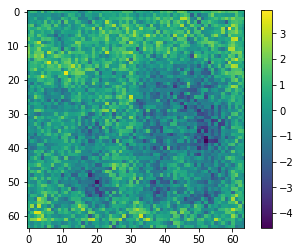

521 [D loss: 0.055387, acc.: 98.44%] [G loss: 7.666520]
522 [D loss: 0.122485, acc.: 95.31%] [G loss: 7.046327]
523 [D loss: 0.022846, acc.: 100.00%] [G loss: 6.490016]
524 [D loss: 0.040138, acc.: 98.44%] [G loss: 9.010002]
525 [D loss: 0.176830, acc.: 90.62%] [G loss: 5.270564]
526 [D loss: 0.227072, acc.: 84.38%] [G loss: 6.463751]
527 [D loss: 0.409715, acc.: 82.81%] [G loss: 5.286745]
528 [D loss: 0.550391, acc.: 81.25%] [G loss: 6.959117]
529 [D loss: 0.039992, acc.: 96.88%] [G loss: 11.187685]
530 [D loss: 0.007589, acc.: 100.00%] [G loss: 10.989975]
531 [D loss: 0.247373, acc.: 93.75%] [G loss: 10.289272]
532 [D loss: 0.013361, acc.: 100.00%] [G loss: 9.292053]
533 [D loss: 0.042605, acc.: 98.44%] [G loss: 8.262108]
534 [D loss: 0.033092, acc.: 100.00%] [G loss: 7.201881]
535 [D loss: 0.030190, acc.: 98.44%] [G loss: 7.262410]
536 [D loss: 0.078041, acc.: 96.88%] [G loss: 7.034268]
537 [D loss: 0.088566, acc.: 96.88%] [G loss: 6.436852]
538 [D loss: 0.133311, acc.: 96.88%] [G l

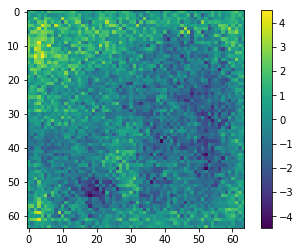

541 [D loss: 0.072635, acc.: 96.88%] [G loss: 5.517605]
542 [D loss: 0.101564, acc.: 96.88%] [G loss: 8.319271]
543 [D loss: 0.027628, acc.: 100.00%] [G loss: 7.386323]
544 [D loss: 0.024275, acc.: 100.00%] [G loss: 7.916311]
545 [D loss: 0.023271, acc.: 98.44%] [G loss: 8.057280]
546 [D loss: 0.014199, acc.: 100.00%] [G loss: 7.012640]
547 [D loss: 0.017098, acc.: 100.00%] [G loss: 5.330106]
548 [D loss: 0.022389, acc.: 100.00%] [G loss: 4.402085]
549 [D loss: 0.212520, acc.: 95.31%] [G loss: 5.079405]
550 [D loss: 0.068045, acc.: 98.44%] [G loss: 3.659139]
551 [D loss: 0.013076, acc.: 100.00%] [G loss: 8.907750]
552 [D loss: 0.038877, acc.: 98.44%] [G loss: 5.671355]
553 [D loss: 0.039194, acc.: 98.44%] [G loss: 7.000921]
554 [D loss: 0.068827, acc.: 95.31%] [G loss: 4.859764]
555 [D loss: 0.026386, acc.: 100.00%] [G loss: 8.980186]
556 [D loss: 0.083403, acc.: 96.88%] [G loss: 8.218138]
557 [D loss: 0.021772, acc.: 100.00%] [G loss: 7.838120]
558 [D loss: 0.239313, acc.: 87.50%] [G 

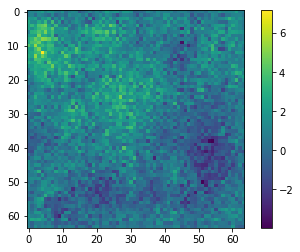

561 [D loss: 0.321087, acc.: 93.75%] [G loss: 6.890734]
562 [D loss: 0.042315, acc.: 98.44%] [G loss: 8.524503]
563 [D loss: 0.007284, acc.: 100.00%] [G loss: 9.930409]
564 [D loss: 0.061083, acc.: 96.88%] [G loss: 9.360934]
565 [D loss: 0.051367, acc.: 98.44%] [G loss: 6.533205]
566 [D loss: 0.143329, acc.: 95.31%] [G loss: 5.539460]
567 [D loss: 0.109771, acc.: 95.31%] [G loss: 6.094501]
568 [D loss: 0.029325, acc.: 98.44%] [G loss: 7.860985]
569 [D loss: 0.060087, acc.: 96.88%] [G loss: 10.218924]
570 [D loss: 0.058006, acc.: 96.88%] [G loss: 8.962168]
571 [D loss: 0.040869, acc.: 100.00%] [G loss: 6.452025]
572 [D loss: 0.105729, acc.: 96.88%] [G loss: 7.017439]
573 [D loss: 0.405711, acc.: 90.62%] [G loss: 8.069162]
574 [D loss: 0.087063, acc.: 95.31%] [G loss: 10.458611]
575 [D loss: 0.054535, acc.: 98.44%] [G loss: 9.493015]
576 [D loss: 0.098581, acc.: 96.88%] [G loss: 9.082275]
577 [D loss: 0.124201, acc.: 95.31%] [G loss: 7.317181]
578 [D loss: 0.063620, acc.: 98.44%] [G loss

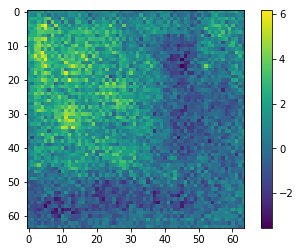

581 [D loss: 0.035196, acc.: 98.44%] [G loss: 7.951141]
582 [D loss: 0.022180, acc.: 98.44%] [G loss: 8.628775]
583 [D loss: 0.017123, acc.: 98.44%] [G loss: 9.664799]
584 [D loss: 0.014327, acc.: 100.00%] [G loss: 9.110718]
585 [D loss: 0.080865, acc.: 96.88%] [G loss: 8.553308]
586 [D loss: 0.088319, acc.: 96.88%] [G loss: 5.786759]
587 [D loss: 0.223823, acc.: 93.75%] [G loss: 4.439361]
588 [D loss: 0.061813, acc.: 98.44%] [G loss: 7.089078]
589 [D loss: 0.041651, acc.: 98.44%] [G loss: 7.041299]
590 [D loss: 0.355968, acc.: 90.62%] [G loss: 3.744647]
591 [D loss: 0.270393, acc.: 90.62%] [G loss: 4.249493]
592 [D loss: 0.054785, acc.: 96.88%] [G loss: 4.934586]
593 [D loss: 0.111536, acc.: 93.75%] [G loss: 4.941247]
594 [D loss: 0.127264, acc.: 93.75%] [G loss: 6.528096]
595 [D loss: 0.225151, acc.: 95.31%] [G loss: 5.742520]
596 [D loss: 0.101414, acc.: 96.88%] [G loss: 4.720690]
597 [D loss: 0.170692, acc.: 93.75%] [G loss: 5.619703]
598 [D loss: 0.223540, acc.: 90.62%] [G loss: 5

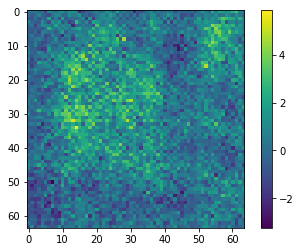

601 [D loss: 0.065868, acc.: 98.44%] [G loss: 7.340375]
602 [D loss: 0.160877, acc.: 93.75%] [G loss: 6.109580]
603 [D loss: 0.209466, acc.: 93.75%] [G loss: 4.332445]
604 [D loss: 0.264638, acc.: 87.50%] [G loss: 5.231459]
605 [D loss: 0.035445, acc.: 98.44%] [G loss: 6.444088]
606 [D loss: 0.088011, acc.: 98.44%] [G loss: 6.212664]
607 [D loss: 0.206359, acc.: 92.19%] [G loss: 3.945569]
608 [D loss: 0.110676, acc.: 93.75%] [G loss: 4.162110]
609 [D loss: 0.116826, acc.: 96.88%] [G loss: 5.338657]
610 [D loss: 0.184676, acc.: 93.75%] [G loss: 6.602674]
611 [D loss: 0.092232, acc.: 98.44%] [G loss: 7.096128]
612 [D loss: 0.209945, acc.: 93.75%] [G loss: 5.010584]
613 [D loss: 0.360299, acc.: 84.38%] [G loss: 4.220957]
614 [D loss: 0.106082, acc.: 95.31%] [G loss: 6.494676]
615 [D loss: 0.138666, acc.: 93.75%] [G loss: 5.781511]
616 [D loss: 0.128941, acc.: 93.75%] [G loss: 5.525522]
617 [D loss: 0.191758, acc.: 93.75%] [G loss: 5.525665]
618 [D loss: 0.095913, acc.: 93.75%] [G loss: 6.

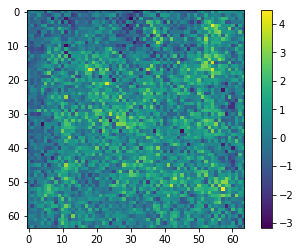

621 [D loss: 0.089760, acc.: 95.31%] [G loss: 5.407113]
622 [D loss: 0.015552, acc.: 100.00%] [G loss: 6.982905]
623 [D loss: 0.108318, acc.: 95.31%] [G loss: 6.285395]
624 [D loss: 0.037833, acc.: 100.00%] [G loss: 4.880413]
625 [D loss: 0.165277, acc.: 93.75%] [G loss: 4.479552]
626 [D loss: 0.459034, acc.: 78.12%] [G loss: 4.271892]
627 [D loss: 0.131731, acc.: 93.75%] [G loss: 5.569065]
628 [D loss: 0.152809, acc.: 96.88%] [G loss: 5.681041]
629 [D loss: 0.331274, acc.: 92.19%] [G loss: 4.214953]
630 [D loss: 0.154902, acc.: 96.88%] [G loss: 3.808209]
631 [D loss: 0.603998, acc.: 78.12%] [G loss: 4.759784]
632 [D loss: 0.133519, acc.: 93.75%] [G loss: 5.378713]
633 [D loss: 0.235326, acc.: 90.62%] [G loss: 4.542309]
634 [D loss: 0.138797, acc.: 96.88%] [G loss: 5.052394]
635 [D loss: 0.142088, acc.: 95.31%] [G loss: 4.924485]
636 [D loss: 0.165460, acc.: 93.75%] [G loss: 4.814885]
637 [D loss: 0.090083, acc.: 96.88%] [G loss: 4.950864]
638 [D loss: 0.068940, acc.: 96.88%] [G loss: 

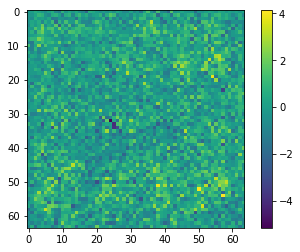

641 [D loss: 0.057969, acc.: 98.44%] [G loss: 5.549818]
642 [D loss: 0.038484, acc.: 98.44%] [G loss: 5.982310]
643 [D loss: 0.096153, acc.: 95.31%] [G loss: 7.415724]
644 [D loss: 0.033027, acc.: 100.00%] [G loss: 5.813119]
645 [D loss: 0.078856, acc.: 98.44%] [G loss: 4.910473]
646 [D loss: 0.063268, acc.: 96.88%] [G loss: 5.101396]
647 [D loss: 0.043749, acc.: 98.44%] [G loss: 5.732240]
648 [D loss: 0.073946, acc.: 98.44%] [G loss: 6.731905]
649 [D loss: 0.073675, acc.: 96.88%] [G loss: 7.084543]
650 [D loss: 0.041760, acc.: 98.44%] [G loss: 6.236703]
651 [D loss: 0.017324, acc.: 100.00%] [G loss: 6.004310]
652 [D loss: 0.045828, acc.: 98.44%] [G loss: 5.214973]
653 [D loss: 0.038846, acc.: 100.00%] [G loss: 4.350244]
654 [D loss: 0.027713, acc.: 100.00%] [G loss: 5.312148]
655 [D loss: 0.043621, acc.: 98.44%] [G loss: 5.354931]
656 [D loss: 0.025697, acc.: 98.44%] [G loss: 5.197184]
657 [D loss: 0.084990, acc.: 98.44%] [G loss: 6.364403]
658 [D loss: 0.058028, acc.: 98.44%] [G loss

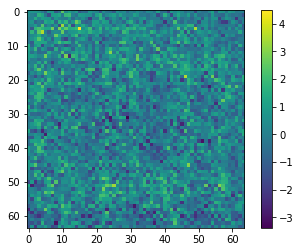

661 [D loss: 0.022386, acc.: 100.00%] [G loss: 6.413987]
662 [D loss: 0.071538, acc.: 96.88%] [G loss: 5.972979]
663 [D loss: 0.021248, acc.: 100.00%] [G loss: 5.194590]
664 [D loss: 0.026095, acc.: 100.00%] [G loss: 5.475057]
665 [D loss: 0.055831, acc.: 98.44%] [G loss: 5.395510]
666 [D loss: 0.018506, acc.: 100.00%] [G loss: 6.406535]
667 [D loss: 0.113827, acc.: 98.44%] [G loss: 6.486461]
668 [D loss: 0.072816, acc.: 96.88%] [G loss: 7.473709]
669 [D loss: 0.049953, acc.: 98.44%] [G loss: 5.420224]
670 [D loss: 0.044190, acc.: 98.44%] [G loss: 6.456702]
671 [D loss: 0.024505, acc.: 100.00%] [G loss: 6.893099]
672 [D loss: 0.018162, acc.: 100.00%] [G loss: 7.207596]
673 [D loss: 0.014061, acc.: 100.00%] [G loss: 6.141199]
674 [D loss: 0.045597, acc.: 96.88%] [G loss: 6.288902]
675 [D loss: 0.034918, acc.: 98.44%] [G loss: 6.855830]
676 [D loss: 0.092709, acc.: 96.88%] [G loss: 6.952793]
677 [D loss: 0.318417, acc.: 89.06%] [G loss: 4.792965]
678 [D loss: 0.108353, acc.: 92.19%] [G l

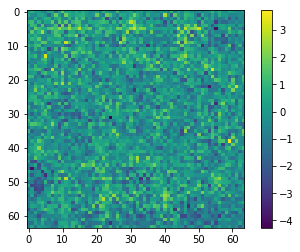

681 [D loss: 0.011351, acc.: 100.00%] [G loss: 9.455442]
682 [D loss: 0.013893, acc.: 100.00%] [G loss: 6.699616]
683 [D loss: 0.014265, acc.: 100.00%] [G loss: 6.740306]
684 [D loss: 0.071645, acc.: 96.88%] [G loss: 5.457661]
685 [D loss: 0.046576, acc.: 98.44%] [G loss: 6.136086]
686 [D loss: 0.046577, acc.: 96.88%] [G loss: 6.900469]
687 [D loss: 0.052089, acc.: 98.44%] [G loss: 8.591887]
688 [D loss: 0.088477, acc.: 95.31%] [G loss: 6.154619]
689 [D loss: 0.053401, acc.: 100.00%] [G loss: 5.260284]
690 [D loss: 0.011522, acc.: 100.00%] [G loss: 7.244054]
691 [D loss: 0.007313, acc.: 100.00%] [G loss: 8.058020]
692 [D loss: 0.041450, acc.: 98.44%] [G loss: 8.581812]
693 [D loss: 0.032401, acc.: 100.00%] [G loss: 7.438505]
694 [D loss: 0.022848, acc.: 98.44%] [G loss: 6.649399]
695 [D loss: 0.083412, acc.: 98.44%] [G loss: 8.125017]
696 [D loss: 0.026405, acc.: 98.44%] [G loss: 8.441579]
697 [D loss: 0.008320, acc.: 100.00%] [G loss: 7.367013]
698 [D loss: 0.012414, acc.: 100.00%] [G

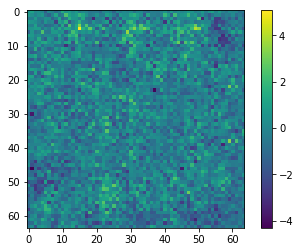

701 [D loss: 0.020109, acc.: 100.00%] [G loss: 8.769299]
702 [D loss: 0.063135, acc.: 98.44%] [G loss: 6.630203]
703 [D loss: 0.157470, acc.: 95.31%] [G loss: 4.124732]
704 [D loss: 0.011880, acc.: 100.00%] [G loss: 6.797435]
705 [D loss: 0.031749, acc.: 98.44%] [G loss: 8.705059]
706 [D loss: 0.125626, acc.: 92.19%] [G loss: 6.575706]
707 [D loss: 0.091495, acc.: 98.44%] [G loss: 6.097898]
708 [D loss: 0.010666, acc.: 100.00%] [G loss: 10.288550]
709 [D loss: 0.005470, acc.: 100.00%] [G loss: 10.007360]
710 [D loss: 0.028291, acc.: 100.00%] [G loss: 10.043189]
711 [D loss: 0.101634, acc.: 98.44%] [G loss: 6.104538]
712 [D loss: 0.129709, acc.: 95.31%] [G loss: 8.888062]
713 [D loss: 0.080266, acc.: 98.44%] [G loss: 12.478813]
714 [D loss: 0.019111, acc.: 100.00%] [G loss: 12.833295]
715 [D loss: 0.130382, acc.: 98.44%] [G loss: 12.264239]
716 [D loss: 0.075894, acc.: 98.44%] [G loss: 9.979095]
717 [D loss: 0.086089, acc.: 98.44%] [G loss: 5.356515]
718 [D loss: 0.130647, acc.: 93.75%]

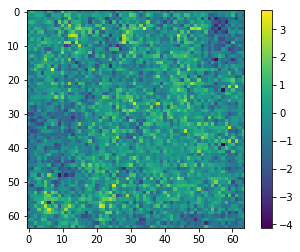

721 [D loss: 0.014300, acc.: 100.00%] [G loss: 12.805493]
722 [D loss: 0.060436, acc.: 96.88%] [G loss: 7.737297]
723 [D loss: 0.020377, acc.: 100.00%] [G loss: 4.942774]
724 [D loss: 0.084015, acc.: 96.88%] [G loss: 4.070126]
725 [D loss: 0.058067, acc.: 100.00%] [G loss: 4.332213]
726 [D loss: 0.034432, acc.: 98.44%] [G loss: 6.018790]
727 [D loss: 0.006880, acc.: 100.00%] [G loss: 9.474800]
728 [D loss: 0.059859, acc.: 96.88%] [G loss: 8.543591]
729 [D loss: 0.017758, acc.: 100.00%] [G loss: 9.823835]
730 [D loss: 0.199531, acc.: 90.62%] [G loss: 0.708417]
731 [D loss: 1.571128, acc.: 56.25%] [G loss: 9.413821]
732 [D loss: 0.037055, acc.: 96.88%] [G loss: 14.997135]
733 [D loss: 1.969729, acc.: 60.94%] [G loss: 13.947241]
734 [D loss: 0.144828, acc.: 95.31%] [G loss: 11.157701]
735 [D loss: 0.016781, acc.: 100.00%] [G loss: 8.872993]
736 [D loss: 0.033064, acc.: 98.44%] [G loss: 6.071976]
737 [D loss: 0.230090, acc.: 92.19%] [G loss: 6.634657]
738 [D loss: 0.103625, acc.: 96.88%] [

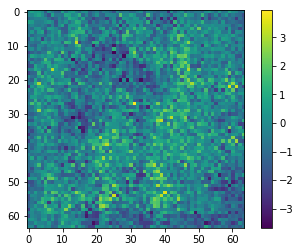

741 [D loss: 0.027090, acc.: 98.44%] [G loss: 8.964734]
742 [D loss: 0.164170, acc.: 93.75%] [G loss: 5.179397]
743 [D loss: 0.071829, acc.: 98.44%] [G loss: 3.449882]
744 [D loss: 0.311273, acc.: 92.19%] [G loss: 4.441873]
745 [D loss: 0.068991, acc.: 96.88%] [G loss: 5.911743]
746 [D loss: 0.250804, acc.: 93.75%] [G loss: 5.790281]
747 [D loss: 0.019957, acc.: 100.00%] [G loss: 4.366495]
748 [D loss: 0.357397, acc.: 84.38%] [G loss: 7.557339]
749 [D loss: 0.068676, acc.: 100.00%] [G loss: 6.645636]
750 [D loss: 0.166198, acc.: 95.31%] [G loss: 6.885364]
751 [D loss: 0.113754, acc.: 96.88%] [G loss: 6.193687]
752 [D loss: 0.106038, acc.: 95.31%] [G loss: 6.552556]
753 [D loss: 0.221850, acc.: 90.62%] [G loss: 4.564475]
754 [D loss: 0.290405, acc.: 90.62%] [G loss: 8.345270]
755 [D loss: 0.008231, acc.: 100.00%] [G loss: 11.657366]
756 [D loss: 0.097043, acc.: 96.88%] [G loss: 10.955472]
757 [D loss: 0.047193, acc.: 98.44%] [G loss: 10.104892]
758 [D loss: 0.040999, acc.: 100.00%] [G l

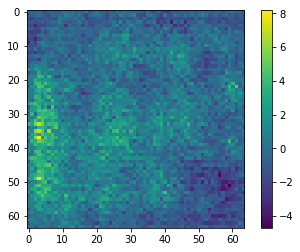

761 [D loss: 0.487451, acc.: 78.12%] [G loss: 9.675435]
762 [D loss: 0.054810, acc.: 96.88%] [G loss: 11.770912]
763 [D loss: 0.180339, acc.: 90.62%] [G loss: 11.475334]
764 [D loss: 0.118117, acc.: 92.19%] [G loss: 12.212200]
765 [D loss: 0.235957, acc.: 92.19%] [G loss: 8.123957]
766 [D loss: 0.113027, acc.: 98.44%] [G loss: 5.857307]
767 [D loss: 0.557304, acc.: 76.56%] [G loss: 5.370618]
768 [D loss: 0.011914, acc.: 100.00%] [G loss: 10.020300]
769 [D loss: 0.259482, acc.: 89.06%] [G loss: 8.865301]
770 [D loss: 0.081632, acc.: 95.31%] [G loss: 7.876541]
771 [D loss: 0.109706, acc.: 95.31%] [G loss: 5.519737]
772 [D loss: 0.101324, acc.: 96.88%] [G loss: 4.032891]
773 [D loss: 0.057699, acc.: 98.44%] [G loss: 3.283543]
774 [D loss: 0.134582, acc.: 95.31%] [G loss: 2.857779]
775 [D loss: 0.142103, acc.: 96.88%] [G loss: 5.879571]
776 [D loss: 0.184452, acc.: 92.19%] [G loss: 5.637369]
777 [D loss: 0.048428, acc.: 98.44%] [G loss: 5.152303]
778 [D loss: 0.121546, acc.: 93.75%] [G los

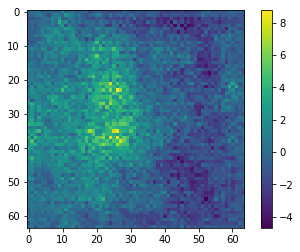

781 [D loss: 0.136165, acc.: 96.88%] [G loss: 3.630776]
782 [D loss: 0.151470, acc.: 95.31%] [G loss: 2.164763]
783 [D loss: 0.211220, acc.: 90.62%] [G loss: 4.015369]
784 [D loss: 0.058238, acc.: 98.44%] [G loss: 4.668771]
785 [D loss: 0.165045, acc.: 93.75%] [G loss: 5.379565]
786 [D loss: 0.121460, acc.: 92.19%] [G loss: 4.411411]
787 [D loss: 0.181347, acc.: 90.62%] [G loss: 2.844117]
788 [D loss: 0.308749, acc.: 92.19%] [G loss: 2.656057]
789 [D loss: 0.197667, acc.: 95.31%] [G loss: 4.402363]
790 [D loss: 0.017273, acc.: 100.00%] [G loss: 6.872283]
791 [D loss: 0.055433, acc.: 98.44%] [G loss: 6.874786]
792 [D loss: 0.067978, acc.: 96.88%] [G loss: 6.393195]
793 [D loss: 0.194723, acc.: 95.31%] [G loss: 5.536870]
794 [D loss: 0.072516, acc.: 98.44%] [G loss: 4.187770]
795 [D loss: 0.086711, acc.: 98.44%] [G loss: 4.298985]
796 [D loss: 0.051004, acc.: 96.88%] [G loss: 5.617233]
797 [D loss: 0.024623, acc.: 100.00%] [G loss: 6.781353]
798 [D loss: 0.013884, acc.: 100.00%] [G loss:

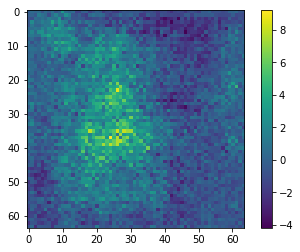

801 [D loss: 0.084968, acc.: 98.44%] [G loss: 6.306633]
802 [D loss: 0.119136, acc.: 95.31%] [G loss: 6.436575]
803 [D loss: 0.193933, acc.: 96.88%] [G loss: 5.188038]
804 [D loss: 0.092711, acc.: 98.44%] [G loss: 6.061755]
805 [D loss: 0.086910, acc.: 96.88%] [G loss: 6.447198]
806 [D loss: 0.078822, acc.: 98.44%] [G loss: 5.803038]
807 [D loss: 0.063405, acc.: 96.88%] [G loss: 5.595834]
808 [D loss: 0.094369, acc.: 98.44%] [G loss: 5.208599]
809 [D loss: 0.051275, acc.: 100.00%] [G loss: 5.000726]
810 [D loss: 0.134060, acc.: 93.75%] [G loss: 7.243955]
811 [D loss: 0.116356, acc.: 98.44%] [G loss: 7.812051]
812 [D loss: 0.346638, acc.: 89.06%] [G loss: 4.298438]
813 [D loss: 0.119183, acc.: 95.31%] [G loss: 4.792040]
814 [D loss: 0.054948, acc.: 98.44%] [G loss: 4.726443]
815 [D loss: 0.171972, acc.: 89.06%] [G loss: 4.699444]
816 [D loss: 0.323436, acc.: 84.38%] [G loss: 4.062299]
817 [D loss: 0.255812, acc.: 87.50%] [G loss: 4.938125]
818 [D loss: 0.092976, acc.: 95.31%] [G loss: 5

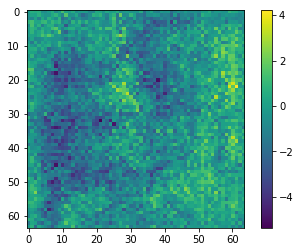

821 [D loss: 0.018977, acc.: 100.00%] [G loss: 5.957053]
822 [D loss: 0.093301, acc.: 96.88%] [G loss: 6.031341]
823 [D loss: 0.208656, acc.: 89.06%] [G loss: 3.780845]
824 [D loss: 0.100046, acc.: 98.44%] [G loss: 2.977014]
825 [D loss: 0.128302, acc.: 96.88%] [G loss: 4.747509]
826 [D loss: 0.296758, acc.: 89.06%] [G loss: 6.091372]
827 [D loss: 0.195436, acc.: 93.75%] [G loss: 7.336123]
828 [D loss: 0.252357, acc.: 89.06%] [G loss: 5.799742]
829 [D loss: 0.281218, acc.: 92.19%] [G loss: 3.917850]
830 [D loss: 0.204263, acc.: 90.62%] [G loss: 3.519153]
831 [D loss: 0.073684, acc.: 96.88%] [G loss: 4.962399]
832 [D loss: 0.039247, acc.: 100.00%] [G loss: 6.048423]
833 [D loss: 0.065907, acc.: 98.44%] [G loss: 5.373081]
834 [D loss: 0.261486, acc.: 90.62%] [G loss: 4.031297]
835 [D loss: 0.317087, acc.: 87.50%] [G loss: 5.167068]
836 [D loss: 0.072433, acc.: 98.44%] [G loss: 5.692876]
837 [D loss: 0.165052, acc.: 95.31%] [G loss: 4.813806]
838 [D loss: 0.249744, acc.: 90.62%] [G loss: 

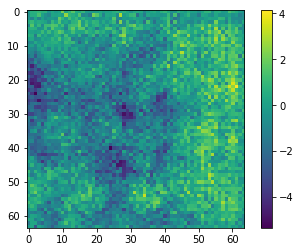

841 [D loss: 0.022528, acc.: 100.00%] [G loss: 7.142341]
842 [D loss: 0.158102, acc.: 92.19%] [G loss: 5.531443]
843 [D loss: 0.136358, acc.: 90.62%] [G loss: 4.658651]
844 [D loss: 0.210024, acc.: 90.62%] [G loss: 5.240743]
845 [D loss: 0.082703, acc.: 96.88%] [G loss: 4.431325]
846 [D loss: 0.156297, acc.: 89.06%] [G loss: 6.182057]
847 [D loss: 0.255096, acc.: 85.94%] [G loss: 4.986132]
848 [D loss: 0.264720, acc.: 92.19%] [G loss: 5.632386]
849 [D loss: 0.196636, acc.: 92.19%] [G loss: 4.432684]
850 [D loss: 0.052479, acc.: 100.00%] [G loss: 5.421501]
851 [D loss: 0.036888, acc.: 100.00%] [G loss: 6.803305]
852 [D loss: 0.283435, acc.: 89.06%] [G loss: 6.382340]
853 [D loss: 0.141099, acc.: 93.75%] [G loss: 5.450668]
854 [D loss: 0.034414, acc.: 98.44%] [G loss: 5.528785]
855 [D loss: 0.093847, acc.: 96.88%] [G loss: 5.760365]
856 [D loss: 0.203517, acc.: 92.19%] [G loss: 6.196309]
857 [D loss: 0.157024, acc.: 95.31%] [G loss: 5.942039]
858 [D loss: 0.144810, acc.: 93.75%] [G loss:

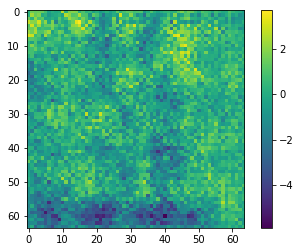

861 [D loss: 0.468846, acc.: 85.94%] [G loss: 5.553739]
862 [D loss: 0.059340, acc.: 98.44%] [G loss: 7.746349]
863 [D loss: 0.062766, acc.: 98.44%] [G loss: 7.484325]
864 [D loss: 0.045626, acc.: 98.44%] [G loss: 6.863452]
865 [D loss: 0.016006, acc.: 100.00%] [G loss: 6.797988]
866 [D loss: 0.036658, acc.: 98.44%] [G loss: 5.763039]
867 [D loss: 0.027538, acc.: 100.00%] [G loss: 6.077165]
868 [D loss: 0.025548, acc.: 100.00%] [G loss: 6.593926]
869 [D loss: 0.007326, acc.: 100.00%] [G loss: 6.117531]
870 [D loss: 0.030499, acc.: 100.00%] [G loss: 6.546657]
871 [D loss: 0.016415, acc.: 100.00%] [G loss: 6.984930]
872 [D loss: 0.041155, acc.: 98.44%] [G loss: 5.952018]
873 [D loss: 0.059892, acc.: 98.44%] [G loss: 5.784847]
874 [D loss: 0.152151, acc.: 96.88%] [G loss: 5.656845]
875 [D loss: 0.034578, acc.: 100.00%] [G loss: 6.198024]
876 [D loss: 0.079539, acc.: 98.44%] [G loss: 6.204678]
877 [D loss: 0.271383, acc.: 85.94%] [G loss: 6.106021]
878 [D loss: 0.069010, acc.: 96.88%] [G l

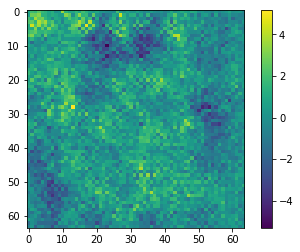

881 [D loss: 0.107705, acc.: 95.31%] [G loss: 6.008095]
882 [D loss: 0.165017, acc.: 90.62%] [G loss: 5.987421]
883 [D loss: 0.105268, acc.: 96.88%] [G loss: 5.562018]
884 [D loss: 0.164395, acc.: 93.75%] [G loss: 5.842795]
885 [D loss: 0.523445, acc.: 79.69%] [G loss: 4.520154]
886 [D loss: 0.232573, acc.: 90.62%] [G loss: 5.905404]
887 [D loss: 0.054261, acc.: 98.44%] [G loss: 5.789782]
888 [D loss: 0.041956, acc.: 100.00%] [G loss: 5.966926]
889 [D loss: 0.036463, acc.: 100.00%] [G loss: 4.848608]
890 [D loss: 0.093550, acc.: 96.88%] [G loss: 4.707407]
891 [D loss: 0.075266, acc.: 96.88%] [G loss: 5.453731]
892 [D loss: 0.047264, acc.: 98.44%] [G loss: 5.372205]
893 [D loss: 0.128025, acc.: 93.75%] [G loss: 5.978949]
894 [D loss: 0.050059, acc.: 98.44%] [G loss: 5.403810]
895 [D loss: 0.062025, acc.: 96.88%] [G loss: 6.565349]
896 [D loss: 0.221654, acc.: 89.06%] [G loss: 5.969159]
897 [D loss: 0.232351, acc.: 85.94%] [G loss: 5.550145]
898 [D loss: 0.078722, acc.: 95.31%] [G loss: 

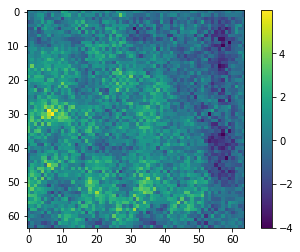

901 [D loss: 0.081023, acc.: 98.44%] [G loss: 5.156219]
902 [D loss: 0.074002, acc.: 96.88%] [G loss: 7.084922]
903 [D loss: 0.045737, acc.: 98.44%] [G loss: 7.538343]
904 [D loss: 0.131743, acc.: 95.31%] [G loss: 6.764682]
905 [D loss: 0.054428, acc.: 98.44%] [G loss: 5.556926]
906 [D loss: 0.070833, acc.: 100.00%] [G loss: 5.607203]
907 [D loss: 0.117693, acc.: 96.88%] [G loss: 5.506875]
908 [D loss: 0.032457, acc.: 98.44%] [G loss: 6.473098]
909 [D loss: 0.059819, acc.: 98.44%] [G loss: 5.744694]
910 [D loss: 0.127966, acc.: 95.31%] [G loss: 4.430394]
911 [D loss: 0.382856, acc.: 79.69%] [G loss: 5.002915]
912 [D loss: 0.108647, acc.: 96.88%] [G loss: 7.489811]
913 [D loss: 0.104381, acc.: 98.44%] [G loss: 6.859992]
914 [D loss: 0.128370, acc.: 92.19%] [G loss: 5.888818]
915 [D loss: 0.199393, acc.: 93.75%] [G loss: 4.664847]
916 [D loss: 0.090967, acc.: 100.00%] [G loss: 3.917616]
917 [D loss: 1.026738, acc.: 60.94%] [G loss: 3.073659]
918 [D loss: 0.309599, acc.: 90.62%] [G loss: 

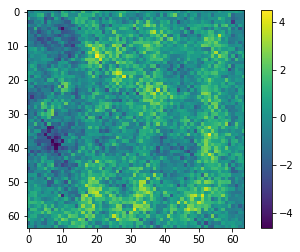

921 [D loss: 0.551662, acc.: 76.56%] [G loss: 3.096603]
922 [D loss: 0.231124, acc.: 89.06%] [G loss: 4.275636]
923 [D loss: 0.114127, acc.: 96.88%] [G loss: 5.407116]
924 [D loss: 0.307387, acc.: 85.94%] [G loss: 4.883160]
925 [D loss: 0.184982, acc.: 92.19%] [G loss: 4.743870]
926 [D loss: 0.258605, acc.: 92.19%] [G loss: 4.275882]
927 [D loss: 0.112036, acc.: 98.44%] [G loss: 5.633279]
928 [D loss: 0.143752, acc.: 93.75%] [G loss: 6.992616]
929 [D loss: 0.225992, acc.: 89.06%] [G loss: 6.580784]
930 [D loss: 0.314449, acc.: 85.94%] [G loss: 6.122670]
931 [D loss: 0.082753, acc.: 96.88%] [G loss: 7.585930]
932 [D loss: 0.034831, acc.: 98.44%] [G loss: 7.219257]
933 [D loss: 0.082107, acc.: 95.31%] [G loss: 6.336035]
934 [D loss: 0.049537, acc.: 100.00%] [G loss: 5.762701]
935 [D loss: 0.066770, acc.: 98.44%] [G loss: 4.176284]
936 [D loss: 0.333633, acc.: 85.94%] [G loss: 4.859258]
937 [D loss: 0.080563, acc.: 96.88%] [G loss: 5.283644]
938 [D loss: 0.124187, acc.: 96.88%] [G loss: 5

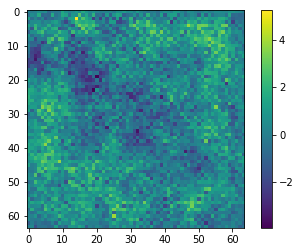

941 [D loss: 0.077930, acc.: 98.44%] [G loss: 6.277460]
942 [D loss: 0.130959, acc.: 96.88%] [G loss: 4.380519]
943 [D loss: 0.211454, acc.: 92.19%] [G loss: 4.228786]
944 [D loss: 0.075457, acc.: 98.44%] [G loss: 5.386311]
945 [D loss: 0.082544, acc.: 98.44%] [G loss: 5.717643]
946 [D loss: 0.158550, acc.: 95.31%] [G loss: 5.285818]
947 [D loss: 0.415783, acc.: 85.94%] [G loss: 4.088889]
948 [D loss: 0.221281, acc.: 90.62%] [G loss: 5.041410]
949 [D loss: 0.212169, acc.: 90.62%] [G loss: 5.022488]
950 [D loss: 0.537890, acc.: 78.12%] [G loss: 5.021891]
951 [D loss: 0.311451, acc.: 85.94%] [G loss: 5.420380]
952 [D loss: 0.101653, acc.: 95.31%] [G loss: 4.271052]
953 [D loss: 0.563634, acc.: 81.25%] [G loss: 4.794379]
954 [D loss: 0.231112, acc.: 90.62%] [G loss: 3.584940]
955 [D loss: 0.333559, acc.: 92.19%] [G loss: 4.410240]
956 [D loss: 0.261256, acc.: 90.62%] [G loss: 4.593793]
957 [D loss: 0.180767, acc.: 92.19%] [G loss: 3.819621]
958 [D loss: 0.232521, acc.: 87.50%] [G loss: 4.

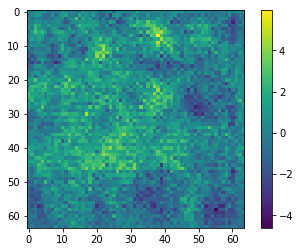

961 [D loss: 0.405327, acc.: 81.25%] [G loss: 4.856004]
962 [D loss: 0.255852, acc.: 87.50%] [G loss: 3.601081]
963 [D loss: 0.132763, acc.: 95.31%] [G loss: 4.241138]
964 [D loss: 0.087964, acc.: 100.00%] [G loss: 3.499930]
965 [D loss: 0.202531, acc.: 90.62%] [G loss: 3.323063]
966 [D loss: 0.166723, acc.: 92.19%] [G loss: 4.046206]
967 [D loss: 0.114263, acc.: 96.88%] [G loss: 3.870969]
968 [D loss: 0.193062, acc.: 90.62%] [G loss: 3.988827]
969 [D loss: 0.182060, acc.: 95.31%] [G loss: 4.180428]
970 [D loss: 0.094033, acc.: 96.88%] [G loss: 4.675756]
971 [D loss: 0.210928, acc.: 93.75%] [G loss: 4.685698]
972 [D loss: 0.265484, acc.: 93.75%] [G loss: 4.673002]
973 [D loss: 0.134406, acc.: 96.88%] [G loss: 4.214893]
974 [D loss: 0.087368, acc.: 98.44%] [G loss: 4.711802]
975 [D loss: 0.241391, acc.: 92.19%] [G loss: 3.895801]
976 [D loss: 0.197193, acc.: 92.19%] [G loss: 5.479143]
977 [D loss: 0.151962, acc.: 95.31%] [G loss: 4.609703]
978 [D loss: 0.234228, acc.: 90.62%] [G loss: 4

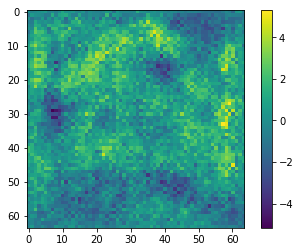

981 [D loss: 0.351708, acc.: 85.94%] [G loss: 4.328582]
982 [D loss: 0.519896, acc.: 81.25%] [G loss: 4.043240]
983 [D loss: 0.511532, acc.: 81.25%] [G loss: 5.623981]
984 [D loss: 0.490570, acc.: 79.69%] [G loss: 4.612400]
985 [D loss: 0.143716, acc.: 93.75%] [G loss: 4.045561]
986 [D loss: 0.246367, acc.: 90.62%] [G loss: 4.022871]
987 [D loss: 0.267271, acc.: 95.31%] [G loss: 4.582079]
988 [D loss: 0.093150, acc.: 96.88%] [G loss: 5.926571]
989 [D loss: 0.061321, acc.: 98.44%] [G loss: 6.269070]
990 [D loss: 0.159484, acc.: 92.19%] [G loss: 5.112392]
991 [D loss: 0.257795, acc.: 92.19%] [G loss: 4.152990]
992 [D loss: 0.145294, acc.: 95.31%] [G loss: 3.564255]
993 [D loss: 0.256292, acc.: 90.62%] [G loss: 4.738786]
994 [D loss: 0.132642, acc.: 95.31%] [G loss: 4.792690]
995 [D loss: 0.072412, acc.: 98.44%] [G loss: 5.707090]
996 [D loss: 0.345332, acc.: 89.06%] [G loss: 3.675861]
997 [D loss: 0.369288, acc.: 84.38%] [G loss: 4.227105]
998 [D loss: 0.140033, acc.: 92.19%] [G loss: 5.

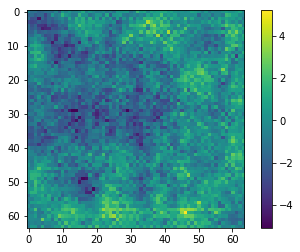

1001 [D loss: 0.187101, acc.: 87.50%] [G loss: 4.464690]
1002 [D loss: 0.231838, acc.: 92.19%] [G loss: 4.375064]
1003 [D loss: 0.179666, acc.: 90.62%] [G loss: 4.311899]
1004 [D loss: 0.094846, acc.: 96.88%] [G loss: 4.390477]
1005 [D loss: 0.228303, acc.: 92.19%] [G loss: 4.059777]
1006 [D loss: 0.094384, acc.: 96.88%] [G loss: 4.560777]
1007 [D loss: 0.218109, acc.: 90.62%] [G loss: 3.503633]
1008 [D loss: 0.288713, acc.: 87.50%] [G loss: 4.275780]
1009 [D loss: 0.170289, acc.: 92.19%] [G loss: 5.633541]
1010 [D loss: 0.509673, acc.: 82.81%] [G loss: 5.036268]
1011 [D loss: 0.484073, acc.: 89.06%] [G loss: 3.103139]
1012 [D loss: 0.319490, acc.: 85.94%] [G loss: 3.056259]
1013 [D loss: 0.452348, acc.: 79.69%] [G loss: 4.432553]
1014 [D loss: 0.554573, acc.: 79.69%] [G loss: 4.398660]
1015 [D loss: 0.200746, acc.: 92.19%] [G loss: 3.620537]
1016 [D loss: 0.231944, acc.: 87.50%] [G loss: 2.214618]
1017 [D loss: 0.161453, acc.: 92.19%] [G loss: 2.559381]
1018 [D loss: 0.168359, acc.: 9

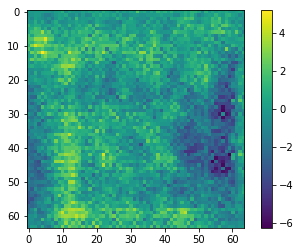

1021 [D loss: 0.051152, acc.: 100.00%] [G loss: 4.032365]
1022 [D loss: 0.122024, acc.: 92.19%] [G loss: 4.711302]
1023 [D loss: 0.190623, acc.: 92.19%] [G loss: 4.623418]
1024 [D loss: 0.100344, acc.: 96.88%] [G loss: 4.979831]
1025 [D loss: 0.191241, acc.: 92.19%] [G loss: 4.711579]
1026 [D loss: 0.129678, acc.: 96.88%] [G loss: 2.775223]
1027 [D loss: 0.382799, acc.: 84.38%] [G loss: 4.486379]
1028 [D loss: 0.061601, acc.: 98.44%] [G loss: 5.954730]
1029 [D loss: 0.087873, acc.: 96.88%] [G loss: 6.760267]
1030 [D loss: 0.017302, acc.: 100.00%] [G loss: 6.245299]
1031 [D loss: 0.065055, acc.: 96.88%] [G loss: 4.697840]
1032 [D loss: 0.123855, acc.: 98.44%] [G loss: 3.954843]
1033 [D loss: 0.320336, acc.: 93.75%] [G loss: 3.757015]
1034 [D loss: 0.172040, acc.: 92.19%] [G loss: 4.235942]
1035 [D loss: 0.094805, acc.: 95.31%] [G loss: 5.502521]
1036 [D loss: 0.136423, acc.: 93.75%] [G loss: 4.668270]
1037 [D loss: 0.105334, acc.: 96.88%] [G loss: 4.611732]
1038 [D loss: 0.150375, acc.:

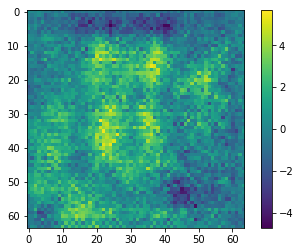

1041 [D loss: 0.326626, acc.: 85.94%] [G loss: 5.148638]
1042 [D loss: 0.388064, acc.: 87.50%] [G loss: 4.582370]
1043 [D loss: 0.123500, acc.: 96.88%] [G loss: 5.311136]
1044 [D loss: 0.206712, acc.: 89.06%] [G loss: 4.863678]
1045 [D loss: 0.228493, acc.: 93.75%] [G loss: 4.874841]
1046 [D loss: 0.240955, acc.: 89.06%] [G loss: 4.015438]
1047 [D loss: 0.081242, acc.: 98.44%] [G loss: 3.915977]
1048 [D loss: 0.061087, acc.: 100.00%] [G loss: 4.471334]
1049 [D loss: 0.152552, acc.: 92.19%] [G loss: 5.908635]
1050 [D loss: 0.105589, acc.: 98.44%] [G loss: 6.851566]
1051 [D loss: 0.072227, acc.: 98.44%] [G loss: 5.316898]
1052 [D loss: 0.068620, acc.: 100.00%] [G loss: 5.240780]
1053 [D loss: 0.159457, acc.: 96.88%] [G loss: 5.551162]
1054 [D loss: 0.129471, acc.: 96.88%] [G loss: 6.879745]
1055 [D loss: 0.185995, acc.: 92.19%] [G loss: 5.432300]
1056 [D loss: 0.374967, acc.: 89.06%] [G loss: 4.199503]
1057 [D loss: 0.295129, acc.: 89.06%] [G loss: 4.158981]
1058 [D loss: 0.174461, acc.:

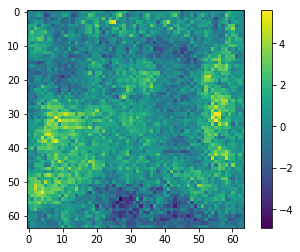

1061 [D loss: 0.152191, acc.: 93.75%] [G loss: 4.730907]
1062 [D loss: 0.203298, acc.: 93.75%] [G loss: 4.579911]
1063 [D loss: 0.438719, acc.: 84.38%] [G loss: 4.080734]
1064 [D loss: 0.140773, acc.: 95.31%] [G loss: 2.512196]
1065 [D loss: 0.257324, acc.: 90.62%] [G loss: 3.684973]
1066 [D loss: 0.195196, acc.: 95.31%] [G loss: 3.932736]
1067 [D loss: 0.186304, acc.: 92.19%] [G loss: 4.134217]
1068 [D loss: 0.142772, acc.: 95.31%] [G loss: 3.849697]
1069 [D loss: 0.074717, acc.: 98.44%] [G loss: 3.686039]
1070 [D loss: 0.131499, acc.: 93.75%] [G loss: 3.778553]
1071 [D loss: 0.090838, acc.: 98.44%] [G loss: 4.113089]
1072 [D loss: 0.111984, acc.: 98.44%] [G loss: 4.506751]
1073 [D loss: 0.160971, acc.: 92.19%] [G loss: 3.964768]
1074 [D loss: 0.252410, acc.: 90.62%] [G loss: 3.547395]
1075 [D loss: 0.212422, acc.: 90.62%] [G loss: 3.999796]
1076 [D loss: 0.247938, acc.: 89.06%] [G loss: 3.782529]
1077 [D loss: 0.249229, acc.: 92.19%] [G loss: 3.503201]
1078 [D loss: 0.139189, acc.: 9

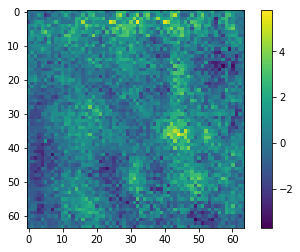

1081 [D loss: 0.356263, acc.: 84.38%] [G loss: 4.346622]
1082 [D loss: 0.234431, acc.: 87.50%] [G loss: 4.107123]
1083 [D loss: 0.340230, acc.: 87.50%] [G loss: 3.735924]
1084 [D loss: 0.177205, acc.: 93.75%] [G loss: 3.086931]
1085 [D loss: 0.126631, acc.: 96.88%] [G loss: 3.908761]
1086 [D loss: 0.200008, acc.: 90.62%] [G loss: 4.289865]
1087 [D loss: 0.143981, acc.: 95.31%] [G loss: 3.762254]
1088 [D loss: 0.235568, acc.: 92.19%] [G loss: 5.162555]
1089 [D loss: 0.117594, acc.: 96.88%] [G loss: 4.976637]
1090 [D loss: 0.390083, acc.: 76.56%] [G loss: 6.079631]
1091 [D loss: 0.283091, acc.: 93.75%] [G loss: 5.241023]
1092 [D loss: 0.180083, acc.: 92.19%] [G loss: 5.017127]
1093 [D loss: 0.265755, acc.: 90.62%] [G loss: 6.002167]
1094 [D loss: 0.146868, acc.: 93.75%] [G loss: 5.681490]
1095 [D loss: 0.276366, acc.: 92.19%] [G loss: 4.795195]
1096 [D loss: 0.132930, acc.: 96.88%] [G loss: 4.491145]
1097 [D loss: 0.147014, acc.: 93.75%] [G loss: 5.391609]
1098 [D loss: 0.092655, acc.: 9

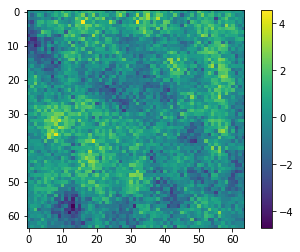

1101 [D loss: 0.358746, acc.: 84.38%] [G loss: 5.065040]
1102 [D loss: 0.266318, acc.: 90.62%] [G loss: 5.246818]
1103 [D loss: 0.154799, acc.: 93.75%] [G loss: 4.176301]
1104 [D loss: 0.158641, acc.: 92.19%] [G loss: 4.168622]
1105 [D loss: 0.060426, acc.: 98.44%] [G loss: 5.293330]
1106 [D loss: 0.066012, acc.: 98.44%] [G loss: 4.152881]
1107 [D loss: 0.129489, acc.: 96.88%] [G loss: 3.871421]
1108 [D loss: 0.210083, acc.: 95.31%] [G loss: 5.220766]
1109 [D loss: 0.150625, acc.: 95.31%] [G loss: 5.209115]
1110 [D loss: 0.061464, acc.: 96.88%] [G loss: 4.374066]
1111 [D loss: 0.081328, acc.: 98.44%] [G loss: 3.896820]
1112 [D loss: 0.094550, acc.: 95.31%] [G loss: 4.348744]
1113 [D loss: 0.128714, acc.: 95.31%] [G loss: 3.754771]
1114 [D loss: 0.058674, acc.: 98.44%] [G loss: 3.708288]
1115 [D loss: 0.236892, acc.: 90.62%] [G loss: 4.499732]
1116 [D loss: 0.102799, acc.: 96.88%] [G loss: 5.244616]
1117 [D loss: 0.135126, acc.: 96.88%] [G loss: 4.028296]
1118 [D loss: 0.085811, acc.: 9

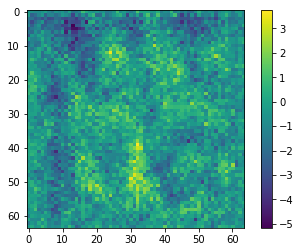

1121 [D loss: 0.221372, acc.: 92.19%] [G loss: 4.426928]
1122 [D loss: 0.132202, acc.: 95.31%] [G loss: 5.742616]
1123 [D loss: 0.410012, acc.: 89.06%] [G loss: 3.030344]
1124 [D loss: 0.132668, acc.: 95.31%] [G loss: 4.073960]
1125 [D loss: 0.531563, acc.: 79.69%] [G loss: 3.582733]
1126 [D loss: 0.070728, acc.: 96.88%] [G loss: 5.711995]
1127 [D loss: 0.880246, acc.: 73.44%] [G loss: 2.993995]
1128 [D loss: 0.405335, acc.: 81.25%] [G loss: 2.545574]
1129 [D loss: 0.651532, acc.: 70.31%] [G loss: 3.900786]
1130 [D loss: 0.154857, acc.: 93.75%] [G loss: 5.563382]
1131 [D loss: 0.457720, acc.: 89.06%] [G loss: 5.603958]
1132 [D loss: 0.686439, acc.: 81.25%] [G loss: 2.870918]
1133 [D loss: 0.629499, acc.: 71.88%] [G loss: 3.024676]
1134 [D loss: 0.223578, acc.: 90.62%] [G loss: 4.309680]
1135 [D loss: 0.158883, acc.: 93.75%] [G loss: 4.778974]
1136 [D loss: 0.272896, acc.: 89.06%] [G loss: 4.005364]
1137 [D loss: 0.358630, acc.: 90.62%] [G loss: 4.321319]
1138 [D loss: 0.383525, acc.: 8

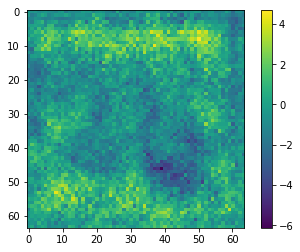

1141 [D loss: 0.079623, acc.: 98.44%] [G loss: 4.198016]
1142 [D loss: 0.283805, acc.: 89.06%] [G loss: 4.294965]
1143 [D loss: 0.136528, acc.: 96.88%] [G loss: 4.440032]
1144 [D loss: 0.232105, acc.: 85.94%] [G loss: 4.919003]
1145 [D loss: 0.169650, acc.: 95.31%] [G loss: 4.200111]
1146 [D loss: 0.161371, acc.: 93.75%] [G loss: 4.970567]
1147 [D loss: 0.152202, acc.: 93.75%] [G loss: 4.862498]
1148 [D loss: 0.367065, acc.: 85.94%] [G loss: 6.061374]
1149 [D loss: 0.335803, acc.: 84.38%] [G loss: 4.286143]
1150 [D loss: 0.070382, acc.: 96.88%] [G loss: 4.117919]
1151 [D loss: 0.229891, acc.: 90.62%] [G loss: 4.691842]
1152 [D loss: 0.127225, acc.: 95.31%] [G loss: 4.592061]
1153 [D loss: 0.121187, acc.: 98.44%] [G loss: 3.737725]
1154 [D loss: 0.123441, acc.: 96.88%] [G loss: 4.834075]
1155 [D loss: 0.090997, acc.: 95.31%] [G loss: 5.142050]
1156 [D loss: 0.049261, acc.: 100.00%] [G loss: 6.142862]
1157 [D loss: 0.099983, acc.: 98.44%] [G loss: 5.785935]
1158 [D loss: 0.166130, acc.: 

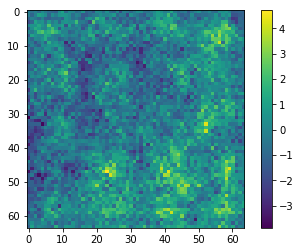

1161 [D loss: 0.144880, acc.: 98.44%] [G loss: 5.647682]
1162 [D loss: 0.049306, acc.: 98.44%] [G loss: 7.160715]
1163 [D loss: 0.442869, acc.: 81.25%] [G loss: 5.336833]
1164 [D loss: 0.253294, acc.: 90.62%] [G loss: 4.494599]
1165 [D loss: 0.180654, acc.: 93.75%] [G loss: 4.371887]
1166 [D loss: 0.105117, acc.: 96.88%] [G loss: 4.867260]
1167 [D loss: 0.066438, acc.: 98.44%] [G loss: 5.089461]
1168 [D loss: 0.101925, acc.: 96.88%] [G loss: 4.808749]
1169 [D loss: 0.218303, acc.: 93.75%] [G loss: 5.129536]
1170 [D loss: 0.223788, acc.: 92.19%] [G loss: 4.856228]
1171 [D loss: 0.183596, acc.: 95.31%] [G loss: 4.164493]
1172 [D loss: 0.211501, acc.: 92.19%] [G loss: 4.217403]
1173 [D loss: 0.190531, acc.: 92.19%] [G loss: 4.782108]
1174 [D loss: 0.183952, acc.: 93.75%] [G loss: 5.698611]
1175 [D loss: 0.190961, acc.: 92.19%] [G loss: 4.121237]
1176 [D loss: 0.870352, acc.: 71.88%] [G loss: 4.196006]
1177 [D loss: 0.336515, acc.: 85.94%] [G loss: 4.991426]
1178 [D loss: 0.282757, acc.: 9

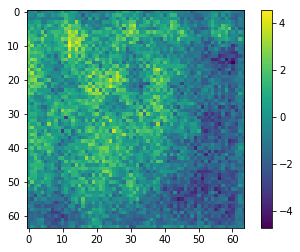

1181 [D loss: 0.230219, acc.: 84.38%] [G loss: 4.700715]
1182 [D loss: 0.116497, acc.: 95.31%] [G loss: 3.879900]
1183 [D loss: 0.286467, acc.: 90.62%] [G loss: 4.215137]
1184 [D loss: 0.374482, acc.: 89.06%] [G loss: 4.220639]
1185 [D loss: 0.576438, acc.: 84.38%] [G loss: 2.941488]
1186 [D loss: 0.257592, acc.: 89.06%] [G loss: 3.839034]
1187 [D loss: 0.276142, acc.: 92.19%] [G loss: 3.615903]
1188 [D loss: 0.434481, acc.: 82.81%] [G loss: 3.968897]
1189 [D loss: 0.136133, acc.: 96.88%] [G loss: 4.521194]
1190 [D loss: 0.251790, acc.: 90.62%] [G loss: 3.383147]
1191 [D loss: 0.148056, acc.: 93.75%] [G loss: 3.900396]
1192 [D loss: 0.245241, acc.: 93.75%] [G loss: 4.143596]
1193 [D loss: 0.031115, acc.: 100.00%] [G loss: 5.351098]
1194 [D loss: 0.244502, acc.: 90.62%] [G loss: 4.217316]
1195 [D loss: 0.193865, acc.: 89.06%] [G loss: 4.101140]
1196 [D loss: 0.364094, acc.: 87.50%] [G loss: 3.936406]
1197 [D loss: 0.195254, acc.: 96.88%] [G loss: 4.913268]
1198 [D loss: 0.212331, acc.: 

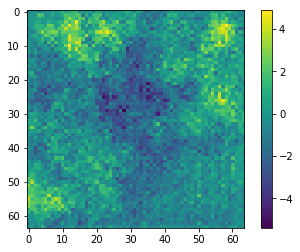

1201 [D loss: 0.146577, acc.: 95.31%] [G loss: 4.347717]
1202 [D loss: 0.223288, acc.: 95.31%] [G loss: 3.589874]
1203 [D loss: 0.338330, acc.: 82.81%] [G loss: 2.799067]
1204 [D loss: 0.290093, acc.: 89.06%] [G loss: 2.428926]
1205 [D loss: 0.320109, acc.: 85.94%] [G loss: 3.183044]
1206 [D loss: 0.233321, acc.: 92.19%] [G loss: 3.046725]
1207 [D loss: 0.166804, acc.: 95.31%] [G loss: 4.461031]
1208 [D loss: 0.096649, acc.: 98.44%] [G loss: 5.597823]
1209 [D loss: 0.097719, acc.: 95.31%] [G loss: 5.327043]
1210 [D loss: 0.045991, acc.: 100.00%] [G loss: 5.308715]
1211 [D loss: 0.210473, acc.: 90.62%] [G loss: 4.491664]
1212 [D loss: 0.443087, acc.: 82.81%] [G loss: 5.237157]
1213 [D loss: 0.064740, acc.: 96.88%] [G loss: 6.504351]
1214 [D loss: 0.217170, acc.: 90.62%] [G loss: 5.587881]
1215 [D loss: 0.196062, acc.: 95.31%] [G loss: 4.175841]
1216 [D loss: 0.162262, acc.: 95.31%] [G loss: 3.394786]
1217 [D loss: 0.157329, acc.: 96.88%] [G loss: 4.629257]
1218 [D loss: 0.124507, acc.: 

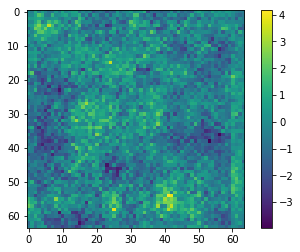

1221 [D loss: 0.295600, acc.: 92.19%] [G loss: 4.584389]
1222 [D loss: 0.159473, acc.: 95.31%] [G loss: 5.674970]
1223 [D loss: 0.534074, acc.: 79.69%] [G loss: 4.152734]
1224 [D loss: 0.289089, acc.: 90.62%] [G loss: 3.680297]
1225 [D loss: 0.460427, acc.: 82.81%] [G loss: 3.219567]
1226 [D loss: 0.255372, acc.: 87.50%] [G loss: 4.103545]
1227 [D loss: 0.426032, acc.: 79.69%] [G loss: 4.471809]
1228 [D loss: 0.504592, acc.: 85.94%] [G loss: 3.293079]
1229 [D loss: 0.336983, acc.: 85.94%] [G loss: 2.821523]
1230 [D loss: 0.570380, acc.: 78.12%] [G loss: 4.091674]
1231 [D loss: 0.258309, acc.: 89.06%] [G loss: 6.080886]
1232 [D loss: 0.504937, acc.: 78.12%] [G loss: 4.694615]
1233 [D loss: 0.165855, acc.: 93.75%] [G loss: 3.786919]
1234 [D loss: 0.310980, acc.: 87.50%] [G loss: 3.074151]
1235 [D loss: 0.329745, acc.: 89.06%] [G loss: 3.975092]
1236 [D loss: 0.295469, acc.: 93.75%] [G loss: 2.904159]
1237 [D loss: 0.124313, acc.: 95.31%] [G loss: 3.560971]
1238 [D loss: 0.405629, acc.: 8

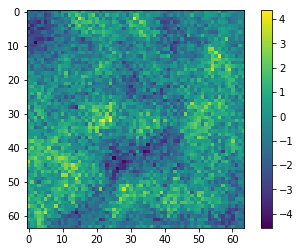

1241 [D loss: 0.579854, acc.: 79.69%] [G loss: 3.531795]
1242 [D loss: 0.224976, acc.: 89.06%] [G loss: 3.441160]
1243 [D loss: 0.519775, acc.: 79.69%] [G loss: 2.948629]
1244 [D loss: 0.427884, acc.: 81.25%] [G loss: 2.487435]
1245 [D loss: 0.154939, acc.: 95.31%] [G loss: 3.155527]
1246 [D loss: 0.187792, acc.: 96.88%] [G loss: 3.671959]
1247 [D loss: 0.082578, acc.: 96.88%] [G loss: 3.694796]
1248 [D loss: 0.150786, acc.: 92.19%] [G loss: 3.713470]
1249 [D loss: 0.177536, acc.: 92.19%] [G loss: 4.249517]
1250 [D loss: 0.159612, acc.: 93.75%] [G loss: 4.058919]
1251 [D loss: 0.187797, acc.: 95.31%] [G loss: 4.163953]
1252 [D loss: 0.218061, acc.: 89.06%] [G loss: 3.935766]
1253 [D loss: 0.217904, acc.: 92.19%] [G loss: 4.122568]
1254 [D loss: 0.352389, acc.: 87.50%] [G loss: 3.578706]
1255 [D loss: 0.315595, acc.: 85.94%] [G loss: 3.233301]
1256 [D loss: 0.212953, acc.: 93.75%] [G loss: 3.523878]
1257 [D loss: 0.201363, acc.: 93.75%] [G loss: 3.704100]
1258 [D loss: 0.330509, acc.: 8

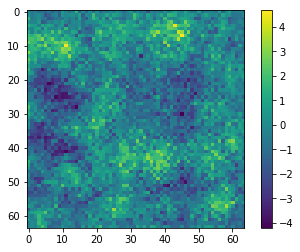

1261 [D loss: 0.448043, acc.: 79.69%] [G loss: 2.945034]
1262 [D loss: 0.462954, acc.: 79.69%] [G loss: 2.644088]
1263 [D loss: 0.168940, acc.: 92.19%] [G loss: 4.322022]
1264 [D loss: 0.110634, acc.: 96.88%] [G loss: 3.591300]
1265 [D loss: 0.125719, acc.: 95.31%] [G loss: 3.305441]
1266 [D loss: 0.219637, acc.: 90.62%] [G loss: 3.379739]
1267 [D loss: 0.316610, acc.: 85.94%] [G loss: 3.063583]
1268 [D loss: 0.186749, acc.: 95.31%] [G loss: 2.727163]
1269 [D loss: 0.534659, acc.: 75.00%] [G loss: 2.649486]
1270 [D loss: 0.371813, acc.: 82.81%] [G loss: 2.383897]
1271 [D loss: 0.720004, acc.: 70.31%] [G loss: 2.404857]
1272 [D loss: 0.339143, acc.: 82.81%] [G loss: 2.929529]
1273 [D loss: 0.302270, acc.: 84.38%] [G loss: 3.199253]
1274 [D loss: 0.382350, acc.: 89.06%] [G loss: 3.171154]
1275 [D loss: 0.424462, acc.: 85.94%] [G loss: 3.103525]
1276 [D loss: 0.261578, acc.: 90.62%] [G loss: 3.415028]
1277 [D loss: 0.229890, acc.: 95.31%] [G loss: 2.866800]
1278 [D loss: 0.216185, acc.: 8

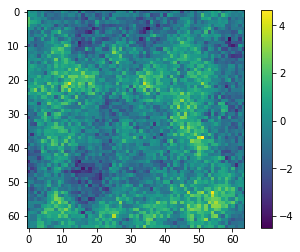

1281 [D loss: 0.209237, acc.: 93.75%] [G loss: 4.217385]
1282 [D loss: 0.293050, acc.: 89.06%] [G loss: 3.252841]
1283 [D loss: 0.409806, acc.: 79.69%] [G loss: 3.190030]
1284 [D loss: 0.524963, acc.: 81.25%] [G loss: 2.488359]
1285 [D loss: 0.612522, acc.: 71.88%] [G loss: 2.762584]
1286 [D loss: 0.522899, acc.: 71.88%] [G loss: 3.735502]
1287 [D loss: 0.479649, acc.: 82.81%] [G loss: 2.530522]
1288 [D loss: 0.269006, acc.: 89.06%] [G loss: 2.271928]
1289 [D loss: 0.320326, acc.: 85.94%] [G loss: 2.001970]
1290 [D loss: 0.289820, acc.: 92.19%] [G loss: 2.019227]
1291 [D loss: 0.133194, acc.: 98.44%] [G loss: 2.556782]
1292 [D loss: 0.152023, acc.: 96.88%] [G loss: 3.463047]
1293 [D loss: 0.141724, acc.: 96.88%] [G loss: 2.590150]
1294 [D loss: 0.251327, acc.: 92.19%] [G loss: 3.222647]
1295 [D loss: 0.111627, acc.: 98.44%] [G loss: 2.916658]
1296 [D loss: 0.143859, acc.: 95.31%] [G loss: 3.382525]
1297 [D loss: 0.089988, acc.: 100.00%] [G loss: 3.514209]
1298 [D loss: 0.114649, acc.: 

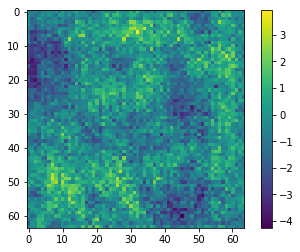

1301 [D loss: 0.230111, acc.: 92.19%] [G loss: 4.612313]
1302 [D loss: 0.117107, acc.: 96.88%] [G loss: 3.462342]
1303 [D loss: 0.190647, acc.: 95.31%] [G loss: 2.975886]
1304 [D loss: 0.540182, acc.: 75.00%] [G loss: 5.715261]
1305 [D loss: 0.187136, acc.: 92.19%] [G loss: 6.021526]
1306 [D loss: 0.332684, acc.: 87.50%] [G loss: 4.051666]
1307 [D loss: 0.880320, acc.: 56.25%] [G loss: 2.009890]
1308 [D loss: 0.916201, acc.: 60.94%] [G loss: 2.488328]
1309 [D loss: 0.445780, acc.: 76.56%] [G loss: 3.695582]
1310 [D loss: 0.361002, acc.: 82.81%] [G loss: 2.884221]
1311 [D loss: 0.488224, acc.: 84.38%] [G loss: 2.223407]
1312 [D loss: 0.323836, acc.: 87.50%] [G loss: 1.803009]
1313 [D loss: 0.438386, acc.: 82.81%] [G loss: 2.275691]
1314 [D loss: 0.218322, acc.: 93.75%] [G loss: 2.011853]
1315 [D loss: 0.234073, acc.: 92.19%] [G loss: 2.336325]
1316 [D loss: 0.236988, acc.: 90.62%] [G loss: 1.737487]
1317 [D loss: 0.378437, acc.: 87.50%] [G loss: 3.835302]
1318 [D loss: 0.491095, acc.: 7

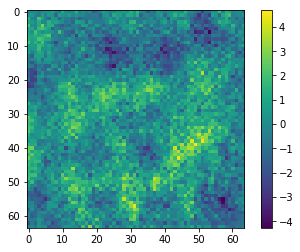

1321 [D loss: 0.478817, acc.: 78.12%] [G loss: 2.327862]
1322 [D loss: 0.412753, acc.: 84.38%] [G loss: 2.993070]
1323 [D loss: 0.229854, acc.: 90.62%] [G loss: 2.613812]
1324 [D loss: 0.581401, acc.: 67.19%] [G loss: 2.248175]
1325 [D loss: 0.319381, acc.: 90.62%] [G loss: 3.070558]
1326 [D loss: 0.415290, acc.: 87.50%] [G loss: 2.851524]
1327 [D loss: 0.164379, acc.: 93.75%] [G loss: 2.792516]
1328 [D loss: 0.300630, acc.: 89.06%] [G loss: 3.126611]
1329 [D loss: 0.178603, acc.: 95.31%] [G loss: 3.221822]
1330 [D loss: 0.127435, acc.: 98.44%] [G loss: 3.097972]
1331 [D loss: 0.129265, acc.: 96.88%] [G loss: 3.719640]
1332 [D loss: 0.109594, acc.: 98.44%] [G loss: 3.277565]
1333 [D loss: 0.212954, acc.: 92.19%] [G loss: 3.184938]
1334 [D loss: 0.228910, acc.: 90.62%] [G loss: 2.524291]
1335 [D loss: 0.311413, acc.: 84.38%] [G loss: 3.904888]
1336 [D loss: 0.383437, acc.: 84.38%] [G loss: 4.071648]
1337 [D loss: 0.306796, acc.: 89.06%] [G loss: 4.135239]
1338 [D loss: 0.219428, acc.: 9

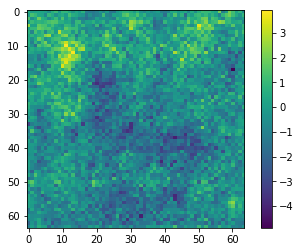

1341 [D loss: 0.286142, acc.: 89.06%] [G loss: 2.784354]
1342 [D loss: 0.302342, acc.: 87.50%] [G loss: 2.463795]
1343 [D loss: 0.389999, acc.: 84.38%] [G loss: 2.015139]
1344 [D loss: 0.202896, acc.: 95.31%] [G loss: 2.320516]
1345 [D loss: 0.180514, acc.: 93.75%] [G loss: 2.683898]
1346 [D loss: 0.317981, acc.: 81.25%] [G loss: 2.879581]
1347 [D loss: 0.339588, acc.: 89.06%] [G loss: 3.650774]
1348 [D loss: 0.336558, acc.: 85.94%] [G loss: 2.909162]
1349 [D loss: 0.419303, acc.: 78.12%] [G loss: 2.604869]
1350 [D loss: 0.234538, acc.: 90.62%] [G loss: 3.119853]
1351 [D loss: 0.311102, acc.: 85.94%] [G loss: 3.446210]
1352 [D loss: 0.324657, acc.: 87.50%] [G loss: 2.738487]
1353 [D loss: 0.273394, acc.: 89.06%] [G loss: 2.894811]
1354 [D loss: 0.363309, acc.: 85.94%] [G loss: 2.320726]
1355 [D loss: 0.827233, acc.: 67.19%] [G loss: 2.645699]
1356 [D loss: 0.321545, acc.: 89.06%] [G loss: 4.736020]
1357 [D loss: 0.662541, acc.: 78.12%] [G loss: 3.456055]
1358 [D loss: 0.506048, acc.: 7

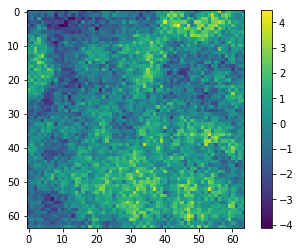

1361 [D loss: 0.138515, acc.: 96.88%] [G loss: 3.408205]
1362 [D loss: 0.418953, acc.: 82.81%] [G loss: 2.794150]
1363 [D loss: 0.238084, acc.: 90.62%] [G loss: 2.156800]
1364 [D loss: 0.587912, acc.: 70.31%] [G loss: 2.154969]
1365 [D loss: 0.253606, acc.: 90.62%] [G loss: 2.338530]
1366 [D loss: 0.558420, acc.: 76.56%] [G loss: 1.445479]
1367 [D loss: 0.314741, acc.: 87.50%] [G loss: 1.314000]
1368 [D loss: 0.465048, acc.: 81.25%] [G loss: 1.457952]
1369 [D loss: 0.262956, acc.: 92.19%] [G loss: 1.527794]
1370 [D loss: 0.273118, acc.: 87.50%] [G loss: 1.220241]
1371 [D loss: 0.343689, acc.: 87.50%] [G loss: 1.319050]
1372 [D loss: 0.311999, acc.: 82.81%] [G loss: 1.261635]
1373 [D loss: 0.743236, acc.: 65.62%] [G loss: 1.749822]
1374 [D loss: 0.205942, acc.: 92.19%] [G loss: 1.686906]
1375 [D loss: 0.282579, acc.: 87.50%] [G loss: 1.073005]
1376 [D loss: 0.391778, acc.: 78.12%] [G loss: 1.289231]
1377 [D loss: 0.289056, acc.: 87.50%] [G loss: 2.192506]
1378 [D loss: 0.183626, acc.: 9

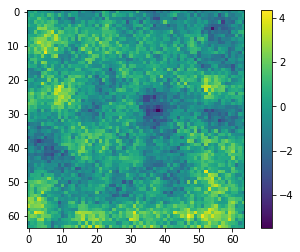

1381 [D loss: 0.326531, acc.: 87.50%] [G loss: 2.881413]
1382 [D loss: 0.516919, acc.: 75.00%] [G loss: 2.288330]
1383 [D loss: 0.324110, acc.: 84.38%] [G loss: 2.326081]
1384 [D loss: 0.243246, acc.: 93.75%] [G loss: 3.103186]
1385 [D loss: 0.205283, acc.: 90.62%] [G loss: 3.167936]
1386 [D loss: 0.293659, acc.: 87.50%] [G loss: 2.441161]
1387 [D loss: 0.381353, acc.: 81.25%] [G loss: 2.720489]
1388 [D loss: 0.604531, acc.: 67.19%] [G loss: 2.409336]
1389 [D loss: 0.806675, acc.: 65.62%] [G loss: 2.778505]
1390 [D loss: 0.485605, acc.: 85.94%] [G loss: 2.810838]
1391 [D loss: 0.247263, acc.: 92.19%] [G loss: 2.314719]
1392 [D loss: 0.629948, acc.: 78.12%] [G loss: 1.871943]
1393 [D loss: 0.433846, acc.: 87.50%] [G loss: 1.568741]
1394 [D loss: 0.308648, acc.: 82.81%] [G loss: 2.266791]
1395 [D loss: 0.273219, acc.: 92.19%] [G loss: 2.797652]
1396 [D loss: 0.523084, acc.: 79.69%] [G loss: 2.379440]
1397 [D loss: 0.450965, acc.: 75.00%] [G loss: 1.395733]
1398 [D loss: 0.425368, acc.: 7

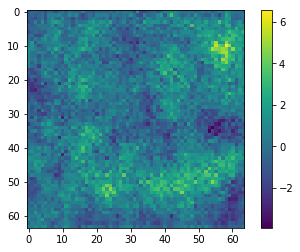

1401 [D loss: 0.312790, acc.: 90.62%] [G loss: 2.113715]
1402 [D loss: 0.172604, acc.: 95.31%] [G loss: 2.437410]
1403 [D loss: 0.317364, acc.: 90.62%] [G loss: 2.695474]
1404 [D loss: 0.285620, acc.: 89.06%] [G loss: 2.465886]
1405 [D loss: 0.223438, acc.: 92.19%] [G loss: 1.688705]
1406 [D loss: 0.350515, acc.: 82.81%] [G loss: 1.870801]
1407 [D loss: 0.233510, acc.: 90.62%] [G loss: 2.812393]
1408 [D loss: 0.320038, acc.: 87.50%] [G loss: 2.950885]
1409 [D loss: 0.451952, acc.: 81.25%] [G loss: 2.296154]
1410 [D loss: 0.615878, acc.: 70.31%] [G loss: 2.133076]
1411 [D loss: 0.239172, acc.: 93.75%] [G loss: 2.880213]
1412 [D loss: 0.385563, acc.: 85.94%] [G loss: 2.135232]
1413 [D loss: 0.376376, acc.: 84.38%] [G loss: 2.040316]
1414 [D loss: 0.316814, acc.: 85.94%] [G loss: 1.536344]
1415 [D loss: 0.163282, acc.: 95.31%] [G loss: 2.563680]
1416 [D loss: 0.182327, acc.: 95.31%] [G loss: 2.403325]
1417 [D loss: 0.179267, acc.: 95.31%] [G loss: 2.416066]
1418 [D loss: 0.368151, acc.: 8

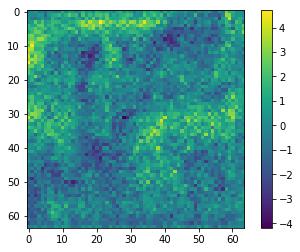

1421 [D loss: 0.559490, acc.: 76.56%] [G loss: 2.078070]
1422 [D loss: 0.391694, acc.: 87.50%] [G loss: 2.742571]
1423 [D loss: 0.467693, acc.: 79.69%] [G loss: 1.389392]
1424 [D loss: 0.369246, acc.: 85.94%] [G loss: 1.239681]
1425 [D loss: 0.663037, acc.: 67.19%] [G loss: 2.265088]
1426 [D loss: 0.373273, acc.: 90.62%] [G loss: 2.317106]
1427 [D loss: 0.769308, acc.: 68.75%] [G loss: 1.555926]
1428 [D loss: 0.599369, acc.: 75.00%] [G loss: 1.758156]
1429 [D loss: 0.387016, acc.: 82.81%] [G loss: 1.846012]
1430 [D loss: 0.436858, acc.: 78.12%] [G loss: 1.681680]
1431 [D loss: 0.648607, acc.: 68.75%] [G loss: 1.198970]
1432 [D loss: 0.419830, acc.: 81.25%] [G loss: 1.236150]
1433 [D loss: 0.675397, acc.: 71.88%] [G loss: 1.541813]
1434 [D loss: 0.367543, acc.: 79.69%] [G loss: 1.524267]
1435 [D loss: 0.305189, acc.: 89.06%] [G loss: 2.026390]
1436 [D loss: 0.355774, acc.: 87.50%] [G loss: 2.266296]
1437 [D loss: 0.305779, acc.: 89.06%] [G loss: 1.963832]
1438 [D loss: 0.348026, acc.: 8

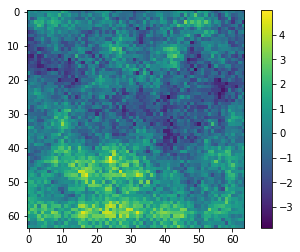

1441 [D loss: 0.108132, acc.: 96.88%] [G loss: 3.942054]
1442 [D loss: 0.217345, acc.: 92.19%] [G loss: 3.432971]
1443 [D loss: 0.144006, acc.: 96.88%] [G loss: 3.648010]
1444 [D loss: 0.169659, acc.: 96.88%] [G loss: 2.408055]
1445 [D loss: 0.142521, acc.: 95.31%] [G loss: 2.921207]
1446 [D loss: 0.097510, acc.: 100.00%] [G loss: 3.927236]
1447 [D loss: 0.110257, acc.: 95.31%] [G loss: 4.511264]
1448 [D loss: 0.196931, acc.: 93.75%] [G loss: 3.222259]
1449 [D loss: 0.451810, acc.: 76.56%] [G loss: 3.411081]
1450 [D loss: 0.082380, acc.: 98.44%] [G loss: 5.839976]
1451 [D loss: 0.344334, acc.: 84.38%] [G loss: 3.164163]
1452 [D loss: 0.571254, acc.: 71.88%] [G loss: 2.088458]
1453 [D loss: 0.914406, acc.: 57.81%] [G loss: 2.993493]
1454 [D loss: 0.803425, acc.: 73.44%] [G loss: 3.114327]
1455 [D loss: 1.043055, acc.: 64.06%] [G loss: 1.415144]
1456 [D loss: 0.789532, acc.: 54.69%] [G loss: 1.249547]
1457 [D loss: 0.613455, acc.: 82.81%] [G loss: 1.506896]
1458 [D loss: 0.507847, acc.: 

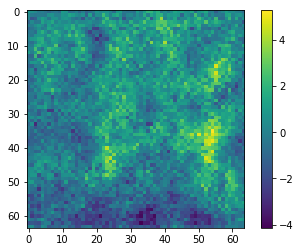

1461 [D loss: 0.508186, acc.: 84.38%] [G loss: 1.499210]
1462 [D loss: 0.453402, acc.: 84.38%] [G loss: 1.672751]
1463 [D loss: 0.372101, acc.: 85.94%] [G loss: 2.002139]
1464 [D loss: 0.196135, acc.: 98.44%] [G loss: 2.340446]
1465 [D loss: 0.291984, acc.: 89.06%] [G loss: 1.965147]
1466 [D loss: 0.314980, acc.: 93.75%] [G loss: 1.541814]
1467 [D loss: 0.273035, acc.: 89.06%] [G loss: 1.214354]
1468 [D loss: 0.286386, acc.: 84.38%] [G loss: 1.527111]
1469 [D loss: 0.438345, acc.: 78.12%] [G loss: 2.290658]
1470 [D loss: 0.460361, acc.: 82.81%] [G loss: 2.204413]
1471 [D loss: 0.297602, acc.: 89.06%] [G loss: 2.125412]
1472 [D loss: 0.463384, acc.: 76.56%] [G loss: 2.064238]
1473 [D loss: 0.251997, acc.: 93.75%] [G loss: 1.752513]
1474 [D loss: 0.159642, acc.: 96.88%] [G loss: 1.783268]
1475 [D loss: 0.157777, acc.: 96.88%] [G loss: 1.696203]
1476 [D loss: 0.139928, acc.: 98.44%] [G loss: 1.989328]
1477 [D loss: 0.450954, acc.: 81.25%] [G loss: 1.702087]
1478 [D loss: 0.119525, acc.: 9

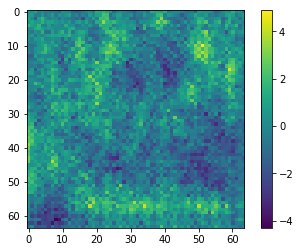

1481 [D loss: 0.608865, acc.: 68.75%] [G loss: 2.844487]
1482 [D loss: 0.306845, acc.: 89.06%] [G loss: 3.787912]
1483 [D loss: 0.261994, acc.: 89.06%] [G loss: 3.634125]
1484 [D loss: 0.345312, acc.: 85.94%] [G loss: 2.106983]
1485 [D loss: 0.292761, acc.: 87.50%] [G loss: 2.004552]
1486 [D loss: 0.348321, acc.: 85.94%] [G loss: 1.504806]
1487 [D loss: 0.242507, acc.: 87.50%] [G loss: 1.830517]
1488 [D loss: 0.508245, acc.: 82.81%] [G loss: 3.419444]
1489 [D loss: 0.436652, acc.: 78.12%] [G loss: 3.148863]
1490 [D loss: 0.255430, acc.: 92.19%] [G loss: 3.373659]
1491 [D loss: 0.700437, acc.: 78.12%] [G loss: 2.323510]
1492 [D loss: 0.579181, acc.: 71.88%] [G loss: 2.244276]
1493 [D loss: 0.620549, acc.: 78.12%] [G loss: 1.873736]
1494 [D loss: 0.377856, acc.: 78.12%] [G loss: 1.978214]
1495 [D loss: 0.579983, acc.: 71.88%] [G loss: 2.086313]
1496 [D loss: 0.511639, acc.: 71.88%] [G loss: 1.701211]
1497 [D loss: 0.551128, acc.: 71.88%] [G loss: 2.162592]
1498 [D loss: 0.568223, acc.: 7

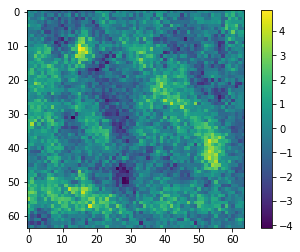

1501 [D loss: 0.664119, acc.: 70.31%] [G loss: 1.974029]
1502 [D loss: 0.702725, acc.: 60.94%] [G loss: 1.597926]
1503 [D loss: 0.605375, acc.: 68.75%] [G loss: 1.580398]
1504 [D loss: 0.561410, acc.: 71.88%] [G loss: 1.868093]
1505 [D loss: 0.717649, acc.: 64.06%] [G loss: 1.586045]
1506 [D loss: 0.736655, acc.: 67.19%] [G loss: 1.897657]
1507 [D loss: 0.554718, acc.: 73.44%] [G loss: 1.743067]
1508 [D loss: 0.510841, acc.: 81.25%] [G loss: 1.625213]
1509 [D loss: 0.538905, acc.: 75.00%] [G loss: 1.425935]
1510 [D loss: 0.544199, acc.: 73.44%] [G loss: 1.382352]
1511 [D loss: 0.500416, acc.: 78.12%] [G loss: 1.909465]
1512 [D loss: 0.601999, acc.: 62.50%] [G loss: 1.664808]
1513 [D loss: 0.574210, acc.: 70.31%] [G loss: 1.885139]
1514 [D loss: 0.567079, acc.: 75.00%] [G loss: 1.579606]
1515 [D loss: 0.596625, acc.: 75.00%] [G loss: 2.084175]
1516 [D loss: 0.627073, acc.: 65.62%] [G loss: 1.709680]
1517 [D loss: 0.497749, acc.: 75.00%] [G loss: 2.100028]
1518 [D loss: 0.443545, acc.: 8

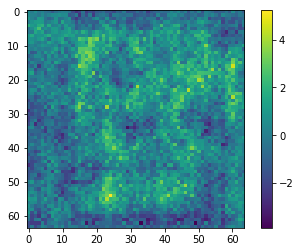

1521 [D loss: 0.256075, acc.: 93.75%] [G loss: 2.105764]
1522 [D loss: 0.252786, acc.: 92.19%] [G loss: 2.866127]
1523 [D loss: 0.229732, acc.: 93.75%] [G loss: 2.449225]
1524 [D loss: 0.267462, acc.: 95.31%] [G loss: 2.084859]
1525 [D loss: 0.175937, acc.: 95.31%] [G loss: 2.269373]
1526 [D loss: 0.227544, acc.: 89.06%] [G loss: 2.548994]
1527 [D loss: 0.261858, acc.: 93.75%] [G loss: 2.574875]
1528 [D loss: 0.222441, acc.: 95.31%] [G loss: 2.807951]
1529 [D loss: 0.290221, acc.: 90.62%] [G loss: 2.623803]
1530 [D loss: 0.327614, acc.: 87.50%] [G loss: 3.159310]
1531 [D loss: 0.400058, acc.: 84.38%] [G loss: 2.080606]
1532 [D loss: 0.274094, acc.: 89.06%] [G loss: 2.305603]
1533 [D loss: 0.159419, acc.: 96.88%] [G loss: 3.213436]
1534 [D loss: 0.235390, acc.: 92.19%] [G loss: 2.219069]
1535 [D loss: 0.389702, acc.: 82.81%] [G loss: 2.353302]
1536 [D loss: 0.245783, acc.: 89.06%] [G loss: 2.055724]
1537 [D loss: 0.363446, acc.: 78.12%] [G loss: 1.404587]
1538 [D loss: 1.032609, acc.: 5

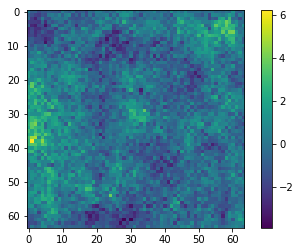

1541 [D loss: 0.278527, acc.: 92.19%] [G loss: 1.481989]
1542 [D loss: 0.307908, acc.: 89.06%] [G loss: 1.392398]
1543 [D loss: 0.301706, acc.: 92.19%] [G loss: 1.813588]
1544 [D loss: 0.227274, acc.: 96.88%] [G loss: 2.791166]
1545 [D loss: 0.223562, acc.: 89.06%] [G loss: 2.558040]
1546 [D loss: 0.232000, acc.: 92.19%] [G loss: 2.661749]
1547 [D loss: 0.285283, acc.: 89.06%] [G loss: 2.425617]
1548 [D loss: 0.401139, acc.: 85.94%] [G loss: 2.216794]
1549 [D loss: 0.225009, acc.: 95.31%] [G loss: 3.291348]
1550 [D loss: 0.190158, acc.: 92.19%] [G loss: 2.772994]
1551 [D loss: 0.387741, acc.: 85.94%] [G loss: 3.569253]
1552 [D loss: 0.279530, acc.: 89.06%] [G loss: 3.213983]
1553 [D loss: 0.330451, acc.: 84.38%] [G loss: 2.826076]
1554 [D loss: 0.198461, acc.: 93.75%] [G loss: 2.741194]
1555 [D loss: 0.307876, acc.: 87.50%] [G loss: 2.281605]
1556 [D loss: 0.449832, acc.: 76.56%] [G loss: 2.546677]
1557 [D loss: 0.356550, acc.: 84.38%] [G loss: 3.038329]
1558 [D loss: 0.471901, acc.: 7

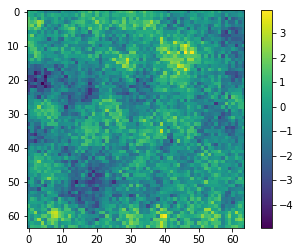

1561 [D loss: 0.477962, acc.: 79.69%] [G loss: 3.893661]
1562 [D loss: 0.328963, acc.: 82.81%] [G loss: 2.316390]
1563 [D loss: 0.361080, acc.: 87.50%] [G loss: 1.590296]
1564 [D loss: 0.404921, acc.: 87.50%] [G loss: 1.655097]
1565 [D loss: 0.343641, acc.: 90.62%] [G loss: 2.575133]
1566 [D loss: 0.166922, acc.: 98.44%] [G loss: 2.773527]
1567 [D loss: 0.148846, acc.: 95.31%] [G loss: 2.655146]
1568 [D loss: 0.186524, acc.: 96.88%] [G loss: 1.777012]
1569 [D loss: 0.450455, acc.: 78.12%] [G loss: 1.829349]
1570 [D loss: 0.496476, acc.: 76.56%] [G loss: 1.728555]
1571 [D loss: 0.593531, acc.: 64.06%] [G loss: 2.075585]
1572 [D loss: 0.757198, acc.: 56.25%] [G loss: 2.584372]
1573 [D loss: 0.596111, acc.: 68.75%] [G loss: 2.186546]
1574 [D loss: 0.906322, acc.: 64.06%] [G loss: 1.530062]
1575 [D loss: 0.918127, acc.: 53.12%] [G loss: 1.363947]
1576 [D loss: 0.664836, acc.: 67.19%] [G loss: 2.001218]
1577 [D loss: 0.696299, acc.: 56.25%] [G loss: 1.353197]
1578 [D loss: 0.459789, acc.: 8

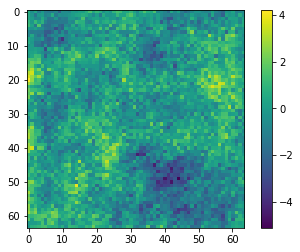

1581 [D loss: 0.480313, acc.: 78.12%] [G loss: 1.603603]
1582 [D loss: 0.363158, acc.: 85.94%] [G loss: 1.397847]
1583 [D loss: 0.408629, acc.: 81.25%] [G loss: 1.133395]
1584 [D loss: 0.666742, acc.: 67.19%] [G loss: 1.312736]
1585 [D loss: 0.489582, acc.: 76.56%] [G loss: 1.974107]
1586 [D loss: 0.375963, acc.: 82.81%] [G loss: 2.014991]
1587 [D loss: 0.591772, acc.: 78.12%] [G loss: 1.589786]
1588 [D loss: 0.518520, acc.: 81.25%] [G loss: 1.855668]
1589 [D loss: 0.457501, acc.: 81.25%] [G loss: 1.784176]
1590 [D loss: 0.335773, acc.: 85.94%] [G loss: 1.655476]
1591 [D loss: 0.429598, acc.: 85.94%] [G loss: 2.278481]
1592 [D loss: 0.282315, acc.: 93.75%] [G loss: 2.144002]
1593 [D loss: 0.321951, acc.: 92.19%] [G loss: 1.976331]
1594 [D loss: 0.372457, acc.: 84.38%] [G loss: 1.790137]
1595 [D loss: 0.216802, acc.: 93.75%] [G loss: 1.796383]
1596 [D loss: 0.320555, acc.: 92.19%] [G loss: 1.594018]
1597 [D loss: 0.363806, acc.: 87.50%] [G loss: 1.743907]
1598 [D loss: 0.309043, acc.: 8

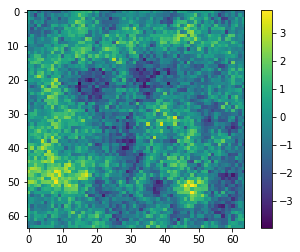

1601 [D loss: 0.728096, acc.: 71.88%] [G loss: 2.055125]
1602 [D loss: 0.448037, acc.: 82.81%] [G loss: 1.912652]
1603 [D loss: 0.692190, acc.: 65.62%] [G loss: 1.934152]
1604 [D loss: 0.411495, acc.: 84.38%] [G loss: 1.798898]
1605 [D loss: 0.334441, acc.: 84.38%] [G loss: 1.580518]
1606 [D loss: 0.340686, acc.: 87.50%] [G loss: 1.481295]
1607 [D loss: 0.329195, acc.: 82.81%] [G loss: 1.621423]
1608 [D loss: 0.374966, acc.: 84.38%] [G loss: 1.902763]
1609 [D loss: 0.458219, acc.: 76.56%] [G loss: 1.933925]
1610 [D loss: 0.514783, acc.: 73.44%] [G loss: 2.076368]
1611 [D loss: 0.558174, acc.: 76.56%] [G loss: 2.424048]
1612 [D loss: 0.637320, acc.: 76.56%] [G loss: 1.520211]
1613 [D loss: 0.481709, acc.: 81.25%] [G loss: 1.896881]
1614 [D loss: 0.356858, acc.: 87.50%] [G loss: 2.174133]
1615 [D loss: 0.507581, acc.: 81.25%] [G loss: 1.745648]
1616 [D loss: 0.303498, acc.: 85.94%] [G loss: 2.019702]
1617 [D loss: 0.420368, acc.: 76.56%] [G loss: 2.081067]
1618 [D loss: 0.571443, acc.: 7

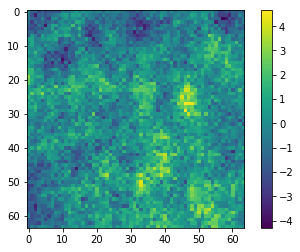

1621 [D loss: 0.604247, acc.: 71.88%] [G loss: 1.666144]
1622 [D loss: 0.453119, acc.: 78.12%] [G loss: 1.958773]
1623 [D loss: 0.472510, acc.: 82.81%] [G loss: 1.778761]
1624 [D loss: 0.547404, acc.: 71.88%] [G loss: 1.561088]
1625 [D loss: 0.443379, acc.: 82.81%] [G loss: 1.979559]
1626 [D loss: 0.407099, acc.: 87.50%] [G loss: 2.129313]
1627 [D loss: 0.382002, acc.: 85.94%] [G loss: 1.730675]
1628 [D loss: 0.288062, acc.: 90.62%] [G loss: 1.551561]
1629 [D loss: 0.404086, acc.: 81.25%] [G loss: 1.823425]
1630 [D loss: 0.428963, acc.: 81.25%] [G loss: 2.052746]
1631 [D loss: 0.667844, acc.: 67.19%] [G loss: 1.627168]
1632 [D loss: 0.572597, acc.: 78.12%] [G loss: 2.385198]
1633 [D loss: 0.270440, acc.: 85.94%] [G loss: 2.276073]
1634 [D loss: 0.410700, acc.: 79.69%] [G loss: 2.245531]
1635 [D loss: 0.448313, acc.: 78.12%] [G loss: 1.851102]
1636 [D loss: 0.518710, acc.: 79.69%] [G loss: 1.855295]
1637 [D loss: 0.479152, acc.: 78.12%] [G loss: 1.902304]
1638 [D loss: 0.546148, acc.: 6

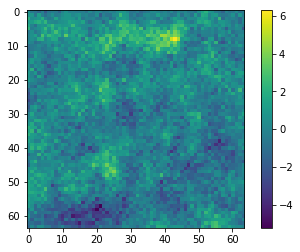

1641 [D loss: 0.396834, acc.: 84.38%] [G loss: 1.688291]
1642 [D loss: 0.529616, acc.: 70.31%] [G loss: 1.325078]
1643 [D loss: 0.658946, acc.: 75.00%] [G loss: 1.588154]
1644 [D loss: 0.476836, acc.: 71.88%] [G loss: 1.602204]
1645 [D loss: 0.707625, acc.: 62.50%] [G loss: 1.769433]
1646 [D loss: 0.383457, acc.: 81.25%] [G loss: 2.347833]
1647 [D loss: 0.837195, acc.: 62.50%] [G loss: 1.929111]
1648 [D loss: 0.805768, acc.: 56.25%] [G loss: 1.393256]
1649 [D loss: 0.588087, acc.: 64.06%] [G loss: 1.267473]
1650 [D loss: 0.633024, acc.: 68.75%] [G loss: 1.412279]
1651 [D loss: 0.509718, acc.: 71.88%] [G loss: 1.237360]
1652 [D loss: 0.533813, acc.: 78.12%] [G loss: 1.382622]
1653 [D loss: 0.712259, acc.: 60.94%] [G loss: 1.246392]
1654 [D loss: 0.540937, acc.: 79.69%] [G loss: 1.918730]
1655 [D loss: 0.406218, acc.: 81.25%] [G loss: 1.665035]
1656 [D loss: 0.381041, acc.: 81.25%] [G loss: 1.510683]
1657 [D loss: 0.675921, acc.: 65.62%] [G loss: 1.089776]
1658 [D loss: 0.451353, acc.: 7

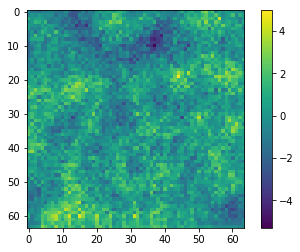

1661 [D loss: 0.438320, acc.: 81.25%] [G loss: 1.624238]
1662 [D loss: 0.517621, acc.: 73.44%] [G loss: 1.523607]
1663 [D loss: 0.408858, acc.: 89.06%] [G loss: 1.764945]
1664 [D loss: 0.629046, acc.: 75.00%] [G loss: 1.453412]
1665 [D loss: 0.445206, acc.: 79.69%] [G loss: 1.802132]
1666 [D loss: 0.413092, acc.: 73.44%] [G loss: 1.671496]
1667 [D loss: 0.431829, acc.: 73.44%] [G loss: 1.578299]
1668 [D loss: 0.527383, acc.: 76.56%] [G loss: 1.505131]
1669 [D loss: 0.341208, acc.: 85.94%] [G loss: 1.688030]
1670 [D loss: 0.417057, acc.: 79.69%] [G loss: 1.552299]
1671 [D loss: 0.626289, acc.: 62.50%] [G loss: 1.446992]
1672 [D loss: 0.510445, acc.: 78.12%] [G loss: 1.797720]
1673 [D loss: 0.424242, acc.: 79.69%] [G loss: 1.889614]
1674 [D loss: 0.425703, acc.: 84.38%] [G loss: 1.613087]
1675 [D loss: 0.469802, acc.: 81.25%] [G loss: 1.392347]
1676 [D loss: 0.308157, acc.: 85.94%] [G loss: 1.671426]
1677 [D loss: 0.468529, acc.: 78.12%] [G loss: 1.570500]
1678 [D loss: 0.330764, acc.: 9

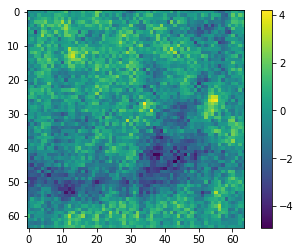

1681 [D loss: 0.412579, acc.: 82.81%] [G loss: 1.068257]
1682 [D loss: 0.394985, acc.: 84.38%] [G loss: 1.416189]
1683 [D loss: 0.493095, acc.: 75.00%] [G loss: 2.043260]
1684 [D loss: 0.496131, acc.: 76.56%] [G loss: 2.102083]
1685 [D loss: 0.526977, acc.: 75.00%] [G loss: 1.678370]
1686 [D loss: 0.532585, acc.: 71.88%] [G loss: 1.327520]
1687 [D loss: 0.602092, acc.: 60.94%] [G loss: 1.517173]
1688 [D loss: 0.432147, acc.: 82.81%] [G loss: 1.772715]
1689 [D loss: 0.432866, acc.: 82.81%] [G loss: 2.100122]
1690 [D loss: 0.583319, acc.: 71.88%] [G loss: 1.271184]
1691 [D loss: 0.380867, acc.: 82.81%] [G loss: 1.773051]
1692 [D loss: 0.548735, acc.: 75.00%] [G loss: 1.673361]
1693 [D loss: 0.411096, acc.: 78.12%] [G loss: 1.645406]
1694 [D loss: 0.293039, acc.: 93.75%] [G loss: 1.979086]
1695 [D loss: 0.310840, acc.: 90.62%] [G loss: 1.798971]
1696 [D loss: 0.480087, acc.: 75.00%] [G loss: 1.942806]
1697 [D loss: 0.295586, acc.: 87.50%] [G loss: 2.714621]
1698 [D loss: 0.630387, acc.: 7

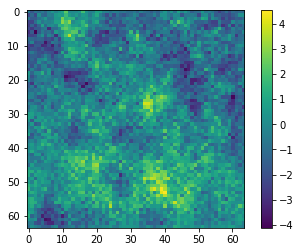

1701 [D loss: 0.780936, acc.: 51.56%] [G loss: 1.899125]
1702 [D loss: 0.530721, acc.: 73.44%] [G loss: 2.231908]
1703 [D loss: 0.440349, acc.: 79.69%] [G loss: 2.077854]
1704 [D loss: 0.579934, acc.: 73.44%] [G loss: 1.467944]
1705 [D loss: 0.823540, acc.: 59.38%] [G loss: 1.347236]
1706 [D loss: 0.550890, acc.: 78.12%] [G loss: 1.514369]
1707 [D loss: 0.454208, acc.: 82.81%] [G loss: 1.808382]
1708 [D loss: 0.474017, acc.: 79.69%] [G loss: 1.468368]
1709 [D loss: 0.782418, acc.: 56.25%] [G loss: 1.229440]
1710 [D loss: 0.400891, acc.: 76.56%] [G loss: 1.293208]
1711 [D loss: 0.375932, acc.: 87.50%] [G loss: 1.722370]
1712 [D loss: 0.657302, acc.: 56.25%] [G loss: 1.585603]
1713 [D loss: 0.671391, acc.: 67.19%] [G loss: 1.831915]
1714 [D loss: 0.552588, acc.: 78.12%] [G loss: 1.853736]
1715 [D loss: 0.555622, acc.: 75.00%] [G loss: 1.553941]
1716 [D loss: 0.545327, acc.: 70.31%] [G loss: 1.646597]
1717 [D loss: 0.658858, acc.: 67.19%] [G loss: 1.324077]
1718 [D loss: 0.460625, acc.: 7

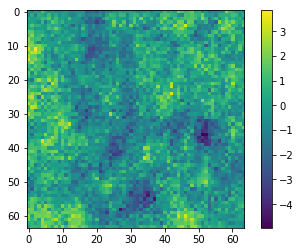

1721 [D loss: 0.473276, acc.: 82.81%] [G loss: 1.784103]
1722 [D loss: 0.566443, acc.: 64.06%] [G loss: 1.619540]
1723 [D loss: 0.637751, acc.: 65.62%] [G loss: 1.554060]
1724 [D loss: 0.638773, acc.: 73.44%] [G loss: 1.543534]
1725 [D loss: 0.632239, acc.: 60.94%] [G loss: 1.380491]
1726 [D loss: 0.631220, acc.: 67.19%] [G loss: 1.495833]
1727 [D loss: 0.643265, acc.: 71.88%] [G loss: 1.122517]
1728 [D loss: 0.626140, acc.: 76.56%] [G loss: 1.318277]
1729 [D loss: 0.534003, acc.: 78.12%] [G loss: 1.500202]
1730 [D loss: 0.513655, acc.: 76.56%] [G loss: 1.592223]
1731 [D loss: 0.341572, acc.: 93.75%] [G loss: 1.424424]
1732 [D loss: 0.385620, acc.: 82.81%] [G loss: 1.482758]
1733 [D loss: 0.386137, acc.: 79.69%] [G loss: 1.467754]
1734 [D loss: 0.313190, acc.: 89.06%] [G loss: 1.917627]
1735 [D loss: 0.239700, acc.: 96.88%] [G loss: 2.060206]
1736 [D loss: 0.292010, acc.: 93.75%] [G loss: 2.045552]
1737 [D loss: 0.202776, acc.: 96.88%] [G loss: 1.998134]
1738 [D loss: 0.425400, acc.: 7

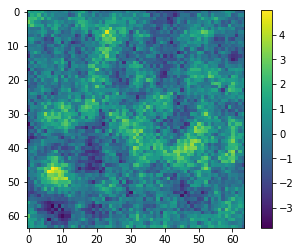

1741 [D loss: 0.293552, acc.: 87.50%] [G loss: 1.460322]
1742 [D loss: 0.655326, acc.: 62.50%] [G loss: 2.126413]
1743 [D loss: 0.854449, acc.: 54.69%] [G loss: 2.393193]
1744 [D loss: 0.510418, acc.: 70.31%] [G loss: 2.600254]
1745 [D loss: 0.617179, acc.: 65.62%] [G loss: 2.421915]
1746 [D loss: 0.605496, acc.: 71.88%] [G loss: 1.873431]
1747 [D loss: 0.593698, acc.: 67.19%] [G loss: 1.472796]
1748 [D loss: 0.283030, acc.: 92.19%] [G loss: 1.673687]
1749 [D loss: 0.481947, acc.: 76.56%] [G loss: 2.159467]
1750 [D loss: 0.255238, acc.: 93.75%] [G loss: 2.680869]
1751 [D loss: 0.622197, acc.: 65.62%] [G loss: 1.463500]
1752 [D loss: 1.404138, acc.: 35.94%] [G loss: 1.121141]
1753 [D loss: 0.710339, acc.: 64.06%] [G loss: 1.448488]
1754 [D loss: 0.735154, acc.: 60.94%] [G loss: 1.441459]
1755 [D loss: 0.702310, acc.: 71.88%] [G loss: 1.683408]
1756 [D loss: 0.628266, acc.: 65.62%] [G loss: 1.558540]
1757 [D loss: 0.744183, acc.: 59.38%] [G loss: 1.136164]
1758 [D loss: 0.736462, acc.: 6

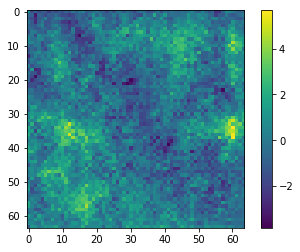

1761 [D loss: 0.555349, acc.: 67.19%] [G loss: 1.325044]
1762 [D loss: 0.621777, acc.: 71.88%] [G loss: 1.418997]
1763 [D loss: 0.473668, acc.: 78.12%] [G loss: 1.316344]
1764 [D loss: 0.525551, acc.: 67.19%] [G loss: 1.523314]
1765 [D loss: 0.458887, acc.: 81.25%] [G loss: 1.549611]
1766 [D loss: 0.456807, acc.: 76.56%] [G loss: 1.489850]
1767 [D loss: 0.500814, acc.: 68.75%] [G loss: 1.668227]
1768 [D loss: 0.374727, acc.: 89.06%] [G loss: 2.120190]
1769 [D loss: 0.394590, acc.: 82.81%] [G loss: 1.744737]
1770 [D loss: 0.611528, acc.: 62.50%] [G loss: 1.465507]
1771 [D loss: 0.827702, acc.: 50.00%] [G loss: 1.466076]
1772 [D loss: 0.760236, acc.: 57.81%] [G loss: 1.248582]
1773 [D loss: 0.628606, acc.: 57.81%] [G loss: 1.190402]
1774 [D loss: 0.817112, acc.: 51.56%] [G loss: 1.181504]
1775 [D loss: 0.665854, acc.: 62.50%] [G loss: 1.185527]
1776 [D loss: 0.774771, acc.: 48.44%] [G loss: 1.284017]
1777 [D loss: 0.608936, acc.: 68.75%] [G loss: 1.117180]
1778 [D loss: 0.650976, acc.: 6

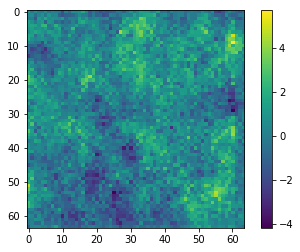

1781 [D loss: 0.575334, acc.: 71.88%] [G loss: 1.009254]
1782 [D loss: 0.556774, acc.: 71.88%] [G loss: 1.144633]
1783 [D loss: 0.685704, acc.: 60.94%] [G loss: 1.018425]
1784 [D loss: 0.523616, acc.: 75.00%] [G loss: 1.118291]
1785 [D loss: 0.513432, acc.: 79.69%] [G loss: 0.992186]
1786 [D loss: 0.523464, acc.: 79.69%] [G loss: 0.905832]
1787 [D loss: 0.662648, acc.: 65.62%] [G loss: 1.131445]
1788 [D loss: 0.571854, acc.: 71.88%] [G loss: 1.296028]
1789 [D loss: 0.567166, acc.: 68.75%] [G loss: 1.095430]
1790 [D loss: 0.476565, acc.: 82.81%] [G loss: 1.083822]
1791 [D loss: 0.502077, acc.: 81.25%] [G loss: 1.053911]
1792 [D loss: 0.500911, acc.: 73.44%] [G loss: 1.272851]
1793 [D loss: 0.574431, acc.: 70.31%] [G loss: 0.997989]
1794 [D loss: 0.584117, acc.: 73.44%] [G loss: 0.978865]
1795 [D loss: 0.517101, acc.: 75.00%] [G loss: 1.182557]
1796 [D loss: 0.518351, acc.: 67.19%] [G loss: 1.033043]
1797 [D loss: 0.530903, acc.: 76.56%] [G loss: 1.037622]
1798 [D loss: 0.493210, acc.: 8

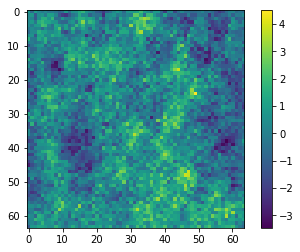

1801 [D loss: 0.372049, acc.: 89.06%] [G loss: 1.294665]
1802 [D loss: 0.452000, acc.: 79.69%] [G loss: 1.165445]
1803 [D loss: 0.421931, acc.: 87.50%] [G loss: 1.046975]
1804 [D loss: 0.388140, acc.: 82.81%] [G loss: 1.413952]
1805 [D loss: 0.364304, acc.: 84.38%] [G loss: 1.475549]
1806 [D loss: 0.307041, acc.: 93.75%] [G loss: 1.962104]
1807 [D loss: 0.350789, acc.: 93.75%] [G loss: 1.894162]
1808 [D loss: 0.321279, acc.: 90.62%] [G loss: 1.723031]
1809 [D loss: 0.271038, acc.: 89.06%] [G loss: 1.456798]
1810 [D loss: 0.447475, acc.: 81.25%] [G loss: 1.516703]
1811 [D loss: 0.476451, acc.: 79.69%] [G loss: 1.426950]
1812 [D loss: 0.698848, acc.: 67.19%] [G loss: 1.986852]
1813 [D loss: 0.606001, acc.: 67.19%] [G loss: 2.191364]
1814 [D loss: 0.536557, acc.: 78.12%] [G loss: 1.930087]
1815 [D loss: 0.485897, acc.: 76.56%] [G loss: 1.865857]
1816 [D loss: 0.458274, acc.: 82.81%] [G loss: 1.391349]
1817 [D loss: 0.440756, acc.: 82.81%] [G loss: 1.384087]
1818 [D loss: 0.456452, acc.: 8

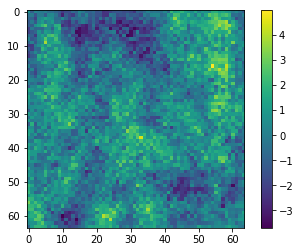

1821 [D loss: 0.745794, acc.: 57.81%] [G loss: 2.000778]
1822 [D loss: 0.684828, acc.: 59.38%] [G loss: 1.598731]
1823 [D loss: 0.626555, acc.: 65.62%] [G loss: 1.364498]
1824 [D loss: 0.844822, acc.: 45.31%] [G loss: 1.056382]
1825 [D loss: 0.892313, acc.: 48.44%] [G loss: 1.217731]
1826 [D loss: 0.712526, acc.: 59.38%] [G loss: 1.336964]
1827 [D loss: 0.738158, acc.: 56.25%] [G loss: 1.236728]
1828 [D loss: 0.718220, acc.: 53.12%] [G loss: 1.031902]
1829 [D loss: 0.623027, acc.: 68.75%] [G loss: 1.027514]
1830 [D loss: 0.667259, acc.: 60.94%] [G loss: 0.881815]
1831 [D loss: 0.648660, acc.: 68.75%] [G loss: 0.877267]
1832 [D loss: 0.651195, acc.: 62.50%] [G loss: 0.797580]
1833 [D loss: 0.632595, acc.: 64.06%] [G loss: 0.973130]
1834 [D loss: 0.575692, acc.: 68.75%] [G loss: 1.068447]
1835 [D loss: 0.569644, acc.: 65.62%] [G loss: 0.968253]
1836 [D loss: 0.593772, acc.: 71.88%] [G loss: 1.157714]
1837 [D loss: 0.513865, acc.: 81.25%] [G loss: 1.100738]
1838 [D loss: 0.519349, acc.: 7

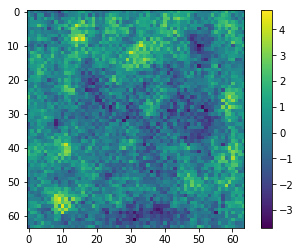

1841 [D loss: 0.475381, acc.: 81.25%] [G loss: 1.404368]
1842 [D loss: 0.427093, acc.: 81.25%] [G loss: 1.374914]
1843 [D loss: 0.473364, acc.: 81.25%] [G loss: 1.103563]
1844 [D loss: 0.447907, acc.: 81.25%] [G loss: 1.077744]
1845 [D loss: 0.550538, acc.: 70.31%] [G loss: 1.015424]
1846 [D loss: 0.655667, acc.: 70.31%] [G loss: 1.154138]
1847 [D loss: 0.616925, acc.: 75.00%] [G loss: 1.265887]
1848 [D loss: 0.447485, acc.: 79.69%] [G loss: 1.156579]
1849 [D loss: 0.632476, acc.: 70.31%] [G loss: 1.254676]
1850 [D loss: 0.689306, acc.: 60.94%] [G loss: 0.898528]
1851 [D loss: 0.882769, acc.: 43.75%] [G loss: 0.904928]
1852 [D loss: 0.639443, acc.: 64.06%] [G loss: 0.852431]
1853 [D loss: 0.749008, acc.: 51.56%] [G loss: 1.173135]
1854 [D loss: 0.895919, acc.: 39.06%] [G loss: 0.972045]
1855 [D loss: 0.828129, acc.: 40.62%] [G loss: 1.060740]
1856 [D loss: 0.921275, acc.: 37.50%] [G loss: 0.987586]
1857 [D loss: 0.709296, acc.: 59.38%] [G loss: 0.988187]
1858 [D loss: 0.702863, acc.: 5

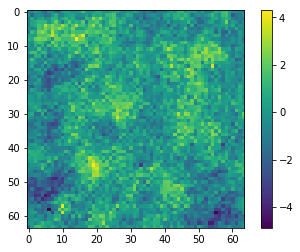

1861 [D loss: 0.621003, acc.: 62.50%] [G loss: 1.040008]
1862 [D loss: 0.461171, acc.: 79.69%] [G loss: 1.167390]
1863 [D loss: 0.474184, acc.: 82.81%] [G loss: 1.546536]
1864 [D loss: 0.396421, acc.: 93.75%] [G loss: 1.521386]
1865 [D loss: 0.396442, acc.: 82.81%] [G loss: 1.302695]
1866 [D loss: 0.439099, acc.: 76.56%] [G loss: 1.399017]
1867 [D loss: 0.505817, acc.: 67.19%] [G loss: 1.288880]
1868 [D loss: 0.446492, acc.: 78.12%] [G loss: 1.220733]
1869 [D loss: 0.433262, acc.: 87.50%] [G loss: 1.435238]
1870 [D loss: 0.423221, acc.: 85.94%] [G loss: 1.073376]
1871 [D loss: 0.599146, acc.: 65.62%] [G loss: 1.155356]
1872 [D loss: 0.578459, acc.: 70.31%] [G loss: 1.227993]
1873 [D loss: 0.601543, acc.: 70.31%] [G loss: 1.280438]
1874 [D loss: 0.569437, acc.: 64.06%] [G loss: 1.082472]
1875 [D loss: 0.653284, acc.: 57.81%] [G loss: 0.969303]
1876 [D loss: 0.586868, acc.: 65.62%] [G loss: 1.032153]
1877 [D loss: 0.566730, acc.: 71.88%] [G loss: 1.066962]
1878 [D loss: 0.494112, acc.: 7

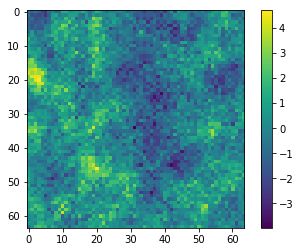

1881 [D loss: 0.449118, acc.: 75.00%] [G loss: 1.121175]
1882 [D loss: 0.487434, acc.: 75.00%] [G loss: 1.144433]
1883 [D loss: 0.406581, acc.: 85.94%] [G loss: 0.953230]
1884 [D loss: 0.472682, acc.: 76.56%] [G loss: 1.226440]
1885 [D loss: 0.461310, acc.: 85.94%] [G loss: 1.293200]
1886 [D loss: 0.419641, acc.: 84.38%] [G loss: 1.353838]
1887 [D loss: 0.594925, acc.: 64.06%] [G loss: 1.347984]
1888 [D loss: 0.606917, acc.: 68.75%] [G loss: 1.331624]
1889 [D loss: 0.532166, acc.: 76.56%] [G loss: 1.132585]
1890 [D loss: 0.619091, acc.: 78.12%] [G loss: 1.256214]
1891 [D loss: 0.474575, acc.: 79.69%] [G loss: 1.120336]
1892 [D loss: 0.611426, acc.: 64.06%] [G loss: 1.109739]
1893 [D loss: 0.602153, acc.: 67.19%] [G loss: 1.180595]
1894 [D loss: 0.613700, acc.: 70.31%] [G loss: 1.735995]
1895 [D loss: 0.680491, acc.: 65.62%] [G loss: 1.377017]
1896 [D loss: 0.530647, acc.: 70.31%] [G loss: 1.293509]
1897 [D loss: 0.623653, acc.: 60.94%] [G loss: 0.916329]
1898 [D loss: 0.720962, acc.: 5

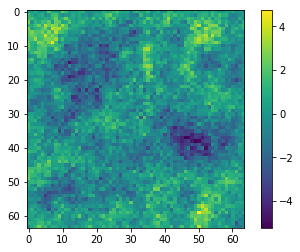

1901 [D loss: 0.605245, acc.: 71.88%] [G loss: 1.323990]
1902 [D loss: 0.493684, acc.: 75.00%] [G loss: 1.147076]
1903 [D loss: 0.641069, acc.: 60.94%] [G loss: 1.193764]
1904 [D loss: 0.723589, acc.: 56.25%] [G loss: 1.063271]
1905 [D loss: 0.433331, acc.: 79.69%] [G loss: 0.983463]
1906 [D loss: 0.603257, acc.: 64.06%] [G loss: 1.078486]
1907 [D loss: 0.437291, acc.: 79.69%] [G loss: 1.138514]
1908 [D loss: 0.519802, acc.: 70.31%] [G loss: 1.131527]
1909 [D loss: 0.460952, acc.: 73.44%] [G loss: 1.235824]
1910 [D loss: 0.472320, acc.: 76.56%] [G loss: 1.172108]
1911 [D loss: 0.361974, acc.: 85.94%] [G loss: 0.984140]
1912 [D loss: 0.604733, acc.: 67.19%] [G loss: 1.124559]
1913 [D loss: 0.530488, acc.: 68.75%] [G loss: 1.459311]
1914 [D loss: 0.497332, acc.: 73.44%] [G loss: 1.118343]
1915 [D loss: 0.617651, acc.: 67.19%] [G loss: 1.127298]
1916 [D loss: 0.672451, acc.: 71.88%] [G loss: 1.191772]
1917 [D loss: 0.534138, acc.: 75.00%] [G loss: 1.344830]
1918 [D loss: 0.518732, acc.: 7

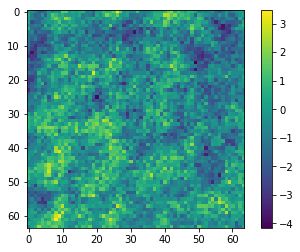

1921 [D loss: 0.590152, acc.: 73.44%] [G loss: 1.510121]
1922 [D loss: 0.512099, acc.: 79.69%] [G loss: 1.067940]
1923 [D loss: 0.661525, acc.: 57.81%] [G loss: 1.117940]
1924 [D loss: 0.518729, acc.: 73.44%] [G loss: 1.159620]
1925 [D loss: 0.483523, acc.: 79.69%] [G loss: 1.224291]
1926 [D loss: 0.581578, acc.: 73.44%] [G loss: 1.115698]
1927 [D loss: 0.551510, acc.: 70.31%] [G loss: 1.277785]
1928 [D loss: 0.867878, acc.: 53.12%] [G loss: 1.093235]
1929 [D loss: 0.521155, acc.: 76.56%] [G loss: 1.499783]
1930 [D loss: 0.497755, acc.: 75.00%] [G loss: 1.155281]
1931 [D loss: 0.875114, acc.: 45.31%] [G loss: 0.908253]
1932 [D loss: 0.826398, acc.: 46.88%] [G loss: 0.987184]
1933 [D loss: 0.784727, acc.: 51.56%] [G loss: 0.816165]
1934 [D loss: 0.775027, acc.: 48.44%] [G loss: 0.829360]
1935 [D loss: 0.620651, acc.: 57.81%] [G loss: 0.983983]
1936 [D loss: 0.632607, acc.: 64.06%] [G loss: 0.970511]
1937 [D loss: 0.678678, acc.: 62.50%] [G loss: 0.948595]
1938 [D loss: 0.825583, acc.: 4

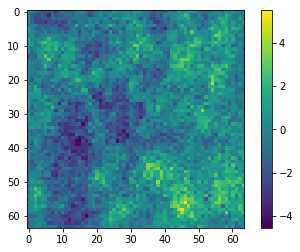

1941 [D loss: 0.648489, acc.: 62.50%] [G loss: 0.984223]
1942 [D loss: 0.602371, acc.: 62.50%] [G loss: 0.997541]
1943 [D loss: 0.562334, acc.: 75.00%] [G loss: 1.223993]
1944 [D loss: 0.514000, acc.: 73.44%] [G loss: 1.280206]
1945 [D loss: 0.338971, acc.: 93.75%] [G loss: 1.348663]
1946 [D loss: 0.368677, acc.: 87.50%] [G loss: 1.544660]
1947 [D loss: 0.494668, acc.: 76.56%] [G loss: 1.603892]
1948 [D loss: 0.371188, acc.: 92.19%] [G loss: 1.438329]
1949 [D loss: 0.483773, acc.: 76.56%] [G loss: 1.409261]
1950 [D loss: 0.544783, acc.: 70.31%] [G loss: 1.503268]
1951 [D loss: 0.484097, acc.: 73.44%] [G loss: 1.559139]
1952 [D loss: 0.535578, acc.: 76.56%] [G loss: 1.345949]
1953 [D loss: 0.643915, acc.: 68.75%] [G loss: 1.498253]
1954 [D loss: 0.770361, acc.: 57.81%] [G loss: 1.327501]
1955 [D loss: 0.727497, acc.: 54.69%] [G loss: 1.103463]
1956 [D loss: 0.825046, acc.: 43.75%] [G loss: 1.106686]
1957 [D loss: 0.804225, acc.: 59.38%] [G loss: 1.258962]
1958 [D loss: 0.915847, acc.: 5

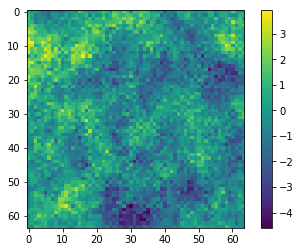

1961 [D loss: 0.592016, acc.: 64.06%] [G loss: 0.971560]
1962 [D loss: 0.606169, acc.: 64.06%] [G loss: 1.076167]
1963 [D loss: 0.529521, acc.: 75.00%] [G loss: 1.182183]
1964 [D loss: 0.417872, acc.: 87.50%] [G loss: 1.250315]
1965 [D loss: 0.489314, acc.: 78.12%] [G loss: 1.428070]
1966 [D loss: 0.434085, acc.: 85.94%] [G loss: 1.548064]
1967 [D loss: 0.536177, acc.: 65.62%] [G loss: 1.084715]
1968 [D loss: 0.577783, acc.: 68.75%] [G loss: 1.104091]
1969 [D loss: 0.450054, acc.: 78.12%] [G loss: 1.385872]
1970 [D loss: 0.412888, acc.: 87.50%] [G loss: 1.281620]
1971 [D loss: 0.458393, acc.: 82.81%] [G loss: 1.330507]
1972 [D loss: 0.482006, acc.: 78.12%] [G loss: 1.389827]
1973 [D loss: 0.587344, acc.: 70.31%] [G loss: 1.385526]
1974 [D loss: 0.441155, acc.: 78.12%] [G loss: 1.195247]
1975 [D loss: 0.453381, acc.: 76.56%] [G loss: 1.172745]
1976 [D loss: 0.479954, acc.: 73.44%] [G loss: 1.310580]
1977 [D loss: 0.337727, acc.: 93.75%] [G loss: 1.569425]
1978 [D loss: 0.374277, acc.: 9

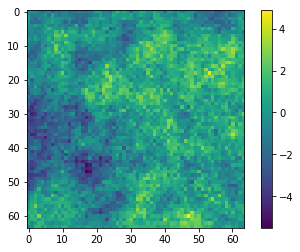

1981 [D loss: 0.365136, acc.: 82.81%] [G loss: 1.542735]
1982 [D loss: 0.388963, acc.: 79.69%] [G loss: 1.522118]
1983 [D loss: 0.418615, acc.: 81.25%] [G loss: 1.649098]
1984 [D loss: 0.435576, acc.: 75.00%] [G loss: 1.647956]
1985 [D loss: 0.265040, acc.: 92.19%] [G loss: 2.274411]
1986 [D loss: 0.390723, acc.: 84.38%] [G loss: 1.690229]
1987 [D loss: 0.415109, acc.: 84.38%] [G loss: 1.425287]
1988 [D loss: 0.532032, acc.: 67.19%] [G loss: 1.267377]
1989 [D loss: 0.521714, acc.: 78.12%] [G loss: 1.236764]
1990 [D loss: 0.541588, acc.: 70.31%] [G loss: 1.566264]
1991 [D loss: 0.434194, acc.: 81.25%] [G loss: 1.419502]
1992 [D loss: 0.515376, acc.: 75.00%] [G loss: 1.407612]
1993 [D loss: 0.583173, acc.: 59.38%] [G loss: 1.468484]
1994 [D loss: 0.502803, acc.: 75.00%] [G loss: 1.579866]
1995 [D loss: 0.696136, acc.: 56.25%] [G loss: 1.565680]
1996 [D loss: 0.657921, acc.: 59.38%] [G loss: 1.633880]
1997 [D loss: 0.518899, acc.: 70.31%] [G loss: 1.216729]
1998 [D loss: 0.459182, acc.: 7

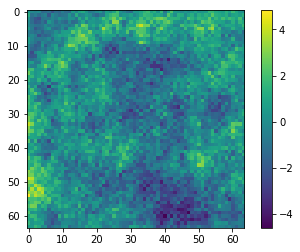

2001 [D loss: 0.382725, acc.: 89.06%] [G loss: 1.581652]
2002 [D loss: 0.436252, acc.: 82.81%] [G loss: 1.532722]
2003 [D loss: 0.433500, acc.: 78.12%] [G loss: 1.595164]
2004 [D loss: 0.425534, acc.: 81.25%] [G loss: 1.580039]
2005 [D loss: 0.731711, acc.: 67.19%] [G loss: 1.434428]
2006 [D loss: 1.007368, acc.: 50.00%] [G loss: 1.623633]
2007 [D loss: 1.138356, acc.: 35.94%] [G loss: 1.684826]
2008 [D loss: 0.974465, acc.: 54.69%] [G loss: 2.116246]
2009 [D loss: 0.937745, acc.: 53.12%] [G loss: 1.798458]
2010 [D loss: 0.832664, acc.: 60.94%] [G loss: 1.408987]
2011 [D loss: 0.622247, acc.: 65.62%] [G loss: 0.931151]
2012 [D loss: 0.834941, acc.: 42.19%] [G loss: 1.219126]
2013 [D loss: 0.738787, acc.: 50.00%] [G loss: 1.201106]
2014 [D loss: 0.654960, acc.: 57.81%] [G loss: 1.451569]
2015 [D loss: 0.696431, acc.: 53.12%] [G loss: 1.322139]
2016 [D loss: 0.671487, acc.: 59.38%] [G loss: 1.550750]
2017 [D loss: 0.637964, acc.: 64.06%] [G loss: 1.433196]
2018 [D loss: 0.741726, acc.: 5

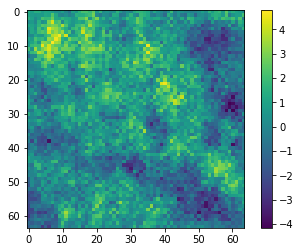

2021 [D loss: 0.675894, acc.: 59.38%] [G loss: 0.869112]
2022 [D loss: 0.845210, acc.: 43.75%] [G loss: 0.827284]
2023 [D loss: 0.639928, acc.: 62.50%] [G loss: 0.977634]
2024 [D loss: 0.661738, acc.: 54.69%] [G loss: 1.205226]
2025 [D loss: 0.526327, acc.: 70.31%] [G loss: 1.192579]
2026 [D loss: 0.590073, acc.: 70.31%] [G loss: 1.180721]
2027 [D loss: 0.524517, acc.: 73.44%] [G loss: 1.124750]
2028 [D loss: 0.537453, acc.: 75.00%] [G loss: 1.044785]
2029 [D loss: 0.510398, acc.: 82.81%] [G loss: 1.150673]
2030 [D loss: 0.519958, acc.: 76.56%] [G loss: 1.281072]
2031 [D loss: 0.530023, acc.: 65.62%] [G loss: 1.051076]
2032 [D loss: 0.492306, acc.: 82.81%] [G loss: 1.684457]
2033 [D loss: 0.648543, acc.: 65.62%] [G loss: 1.189658]
2034 [D loss: 0.603532, acc.: 62.50%] [G loss: 1.213711]
2035 [D loss: 0.591372, acc.: 67.19%] [G loss: 1.249098]
2036 [D loss: 0.573271, acc.: 65.62%] [G loss: 1.287437]
2037 [D loss: 0.695235, acc.: 60.94%] [G loss: 1.248519]
2038 [D loss: 0.652266, acc.: 5

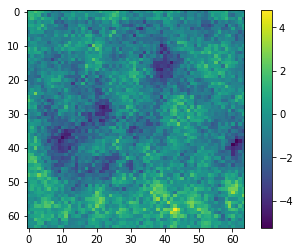

2041 [D loss: 0.516931, acc.: 71.88%] [G loss: 0.939338]
2042 [D loss: 0.473249, acc.: 79.69%] [G loss: 1.244619]
2043 [D loss: 0.507605, acc.: 68.75%] [G loss: 0.973836]
2044 [D loss: 0.510705, acc.: 75.00%] [G loss: 1.009895]
2045 [D loss: 0.495820, acc.: 68.75%] [G loss: 1.078036]
2046 [D loss: 0.580906, acc.: 64.06%] [G loss: 1.138565]
2047 [D loss: 0.605505, acc.: 60.94%] [G loss: 1.064496]
2048 [D loss: 0.521388, acc.: 73.44%] [G loss: 1.177000]
2049 [D loss: 0.469402, acc.: 78.12%] [G loss: 1.005324]
2050 [D loss: 0.765961, acc.: 46.88%] [G loss: 0.841512]
2051 [D loss: 0.689108, acc.: 57.81%] [G loss: 0.927722]
2052 [D loss: 0.470399, acc.: 89.06%] [G loss: 0.970638]
2053 [D loss: 0.454124, acc.: 82.81%] [G loss: 1.221045]
2054 [D loss: 0.414696, acc.: 81.25%] [G loss: 1.241884]
2055 [D loss: 0.367213, acc.: 92.19%] [G loss: 1.540908]
2056 [D loss: 0.279778, acc.: 90.62%] [G loss: 1.875012]
2057 [D loss: 0.249829, acc.: 92.19%] [G loss: 1.576909]
2058 [D loss: 0.300466, acc.: 8

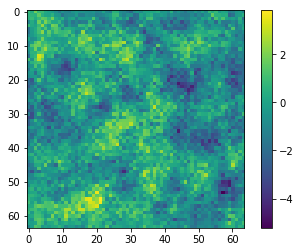

2061 [D loss: 1.092779, acc.: 57.81%] [G loss: 1.753426]
2062 [D loss: 0.497912, acc.: 75.00%] [G loss: 2.778304]
2063 [D loss: 0.558995, acc.: 73.44%] [G loss: 2.391995]
2064 [D loss: 0.751929, acc.: 65.62%] [G loss: 1.582813]
2065 [D loss: 0.692883, acc.: 59.38%] [G loss: 1.234560]
2066 [D loss: 0.540690, acc.: 67.19%] [G loss: 1.359157]
2067 [D loss: 0.470756, acc.: 78.12%] [G loss: 1.545721]
2068 [D loss: 0.533628, acc.: 70.31%] [G loss: 1.274033]
2069 [D loss: 0.548649, acc.: 67.19%] [G loss: 1.155724]
2070 [D loss: 0.627452, acc.: 70.31%] [G loss: 1.131638]
2071 [D loss: 0.705279, acc.: 64.06%] [G loss: 1.328785]
2072 [D loss: 0.700451, acc.: 62.50%] [G loss: 1.353025]
2073 [D loss: 0.552846, acc.: 70.31%] [G loss: 1.200100]
2074 [D loss: 0.532066, acc.: 73.44%] [G loss: 1.228177]
2075 [D loss: 0.592655, acc.: 75.00%] [G loss: 1.029409]
2076 [D loss: 0.535889, acc.: 75.00%] [G loss: 1.027646]
2077 [D loss: 0.535410, acc.: 71.88%] [G loss: 1.113408]
2078 [D loss: 0.481323, acc.: 7

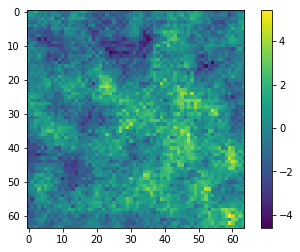

2081 [D loss: 0.349789, acc.: 82.81%] [G loss: 1.438060]
2082 [D loss: 0.397385, acc.: 85.94%] [G loss: 1.474283]
2083 [D loss: 0.469846, acc.: 75.00%] [G loss: 1.432346]
2084 [D loss: 0.461139, acc.: 82.81%] [G loss: 1.433654]
2085 [D loss: 0.428176, acc.: 81.25%] [G loss: 1.583628]
2086 [D loss: 0.609908, acc.: 60.94%] [G loss: 1.710191]
2087 [D loss: 0.394199, acc.: 85.94%] [G loss: 1.595284]
2088 [D loss: 0.327320, acc.: 87.50%] [G loss: 1.475823]
2089 [D loss: 0.418317, acc.: 79.69%] [G loss: 1.290988]
2090 [D loss: 0.532191, acc.: 70.31%] [G loss: 1.621395]
2091 [D loss: 0.753786, acc.: 54.69%] [G loss: 1.399482]
2092 [D loss: 0.536272, acc.: 70.31%] [G loss: 2.041351]
2093 [D loss: 0.723884, acc.: 56.25%] [G loss: 1.437634]
2094 [D loss: 0.997597, acc.: 25.00%] [G loss: 1.194269]
2095 [D loss: 1.134834, acc.: 20.31%] [G loss: 1.268592]
2096 [D loss: 0.873476, acc.: 42.19%] [G loss: 1.217857]
2097 [D loss: 0.820928, acc.: 48.44%] [G loss: 1.102464]
2098 [D loss: 0.802868, acc.: 5

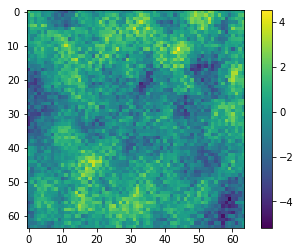

2101 [D loss: 0.743537, acc.: 53.12%] [G loss: 0.893723]
2102 [D loss: 0.637343, acc.: 65.62%] [G loss: 0.919216]
2103 [D loss: 0.539259, acc.: 70.31%] [G loss: 1.085522]
2104 [D loss: 0.552235, acc.: 71.88%] [G loss: 1.129011]
2105 [D loss: 0.548994, acc.: 70.31%] [G loss: 1.217837]
2106 [D loss: 0.538686, acc.: 70.31%] [G loss: 1.392893]
2107 [D loss: 0.515545, acc.: 76.56%] [G loss: 1.230448]
2108 [D loss: 0.483087, acc.: 71.88%] [G loss: 1.496953]
2109 [D loss: 0.457880, acc.: 78.12%] [G loss: 1.206880]
2110 [D loss: 0.583207, acc.: 67.19%] [G loss: 1.336096]
2111 [D loss: 0.543718, acc.: 60.94%] [G loss: 1.130929]
2112 [D loss: 0.435089, acc.: 75.00%] [G loss: 1.164590]
2113 [D loss: 0.650769, acc.: 54.69%] [G loss: 1.035641]
2114 [D loss: 0.587591, acc.: 56.25%] [G loss: 0.974588]
2115 [D loss: 0.694671, acc.: 46.88%] [G loss: 0.803900]
2116 [D loss: 0.676664, acc.: 56.25%] [G loss: 0.864893]
2117 [D loss: 0.597934, acc.: 57.81%] [G loss: 0.860738]
2118 [D loss: 0.589038, acc.: 6

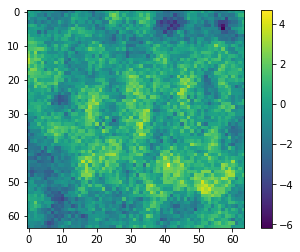

2121 [D loss: 0.568652, acc.: 71.88%] [G loss: 1.109112]
2122 [D loss: 0.467317, acc.: 82.81%] [G loss: 1.098274]
2123 [D loss: 0.481688, acc.: 82.81%] [G loss: 1.170051]
2124 [D loss: 0.508518, acc.: 71.88%] [G loss: 1.492081]
2125 [D loss: 0.466917, acc.: 75.00%] [G loss: 1.467149]
2126 [D loss: 0.457338, acc.: 85.94%] [G loss: 1.357413]
2127 [D loss: 0.522324, acc.: 71.88%] [G loss: 1.228225]
2128 [D loss: 0.481337, acc.: 68.75%] [G loss: 1.149572]
2129 [D loss: 0.732749, acc.: 62.50%] [G loss: 1.194511]
2130 [D loss: 0.797822, acc.: 54.69%] [G loss: 1.178962]
2131 [D loss: 0.627783, acc.: 65.62%] [G loss: 1.753254]
2132 [D loss: 0.732066, acc.: 54.69%] [G loss: 1.262631]
2133 [D loss: 0.704232, acc.: 64.06%] [G loss: 1.086611]
2134 [D loss: 0.723476, acc.: 56.25%] [G loss: 1.060222]
2135 [D loss: 0.691204, acc.: 57.81%] [G loss: 0.892317]
2136 [D loss: 0.734640, acc.: 48.44%] [G loss: 0.848050]
2137 [D loss: 0.839671, acc.: 46.88%] [G loss: 0.907790]
2138 [D loss: 0.875300, acc.: 3

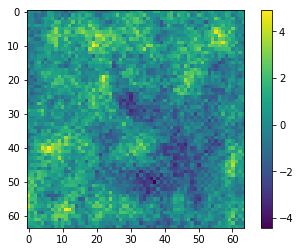

2141 [D loss: 0.617181, acc.: 64.06%] [G loss: 0.933280]
2142 [D loss: 0.575234, acc.: 73.44%] [G loss: 0.942754]
2143 [D loss: 0.640711, acc.: 60.94%] [G loss: 0.915927]
2144 [D loss: 0.568289, acc.: 79.69%] [G loss: 0.906839]
2145 [D loss: 0.585265, acc.: 67.19%] [G loss: 0.908030]
2146 [D loss: 0.515400, acc.: 78.12%] [G loss: 0.897380]
2147 [D loss: 0.619915, acc.: 70.31%] [G loss: 1.012455]
2148 [D loss: 0.563067, acc.: 59.38%] [G loss: 1.030642]
2149 [D loss: 0.623824, acc.: 68.75%] [G loss: 0.840448]
2150 [D loss: 0.495030, acc.: 75.00%] [G loss: 0.995015]
2151 [D loss: 0.573992, acc.: 76.56%] [G loss: 1.128595]
2152 [D loss: 0.587415, acc.: 68.75%] [G loss: 1.034615]
2153 [D loss: 0.518517, acc.: 82.81%] [G loss: 0.954037]
2154 [D loss: 0.502342, acc.: 84.38%] [G loss: 1.006812]
2155 [D loss: 0.508087, acc.: 76.56%] [G loss: 0.888976]
2156 [D loss: 0.475340, acc.: 79.69%] [G loss: 1.017161]
2157 [D loss: 0.679187, acc.: 67.19%] [G loss: 1.015528]
2158 [D loss: 0.501547, acc.: 7

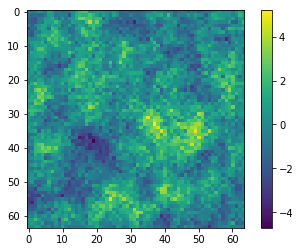

2161 [D loss: 0.530571, acc.: 70.31%] [G loss: 1.093651]
2162 [D loss: 0.641816, acc.: 54.69%] [G loss: 1.234904]
2163 [D loss: 0.649300, acc.: 64.06%] [G loss: 1.330683]
2164 [D loss: 0.510118, acc.: 71.88%] [G loss: 1.242471]
2165 [D loss: 0.494423, acc.: 82.81%] [G loss: 1.001153]
2166 [D loss: 0.556693, acc.: 73.44%] [G loss: 0.941767]
2167 [D loss: 0.572137, acc.: 64.06%] [G loss: 1.077957]
2168 [D loss: 0.489226, acc.: 75.00%] [G loss: 1.150050]
2169 [D loss: 0.592046, acc.: 67.19%] [G loss: 1.106919]
2170 [D loss: 0.644748, acc.: 64.06%] [G loss: 1.095014]
2171 [D loss: 0.691661, acc.: 51.56%] [G loss: 0.897142]
2172 [D loss: 0.827824, acc.: 48.44%] [G loss: 0.846956]
2173 [D loss: 0.771708, acc.: 43.75%] [G loss: 0.898106]
2174 [D loss: 0.642845, acc.: 59.38%] [G loss: 1.023221]
2175 [D loss: 0.733713, acc.: 53.12%] [G loss: 0.924466]
2176 [D loss: 0.747222, acc.: 59.38%] [G loss: 0.833248]
2177 [D loss: 0.690865, acc.: 56.25%] [G loss: 0.827780]
2178 [D loss: 0.710307, acc.: 5

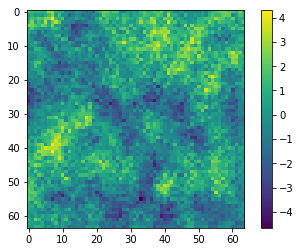

2181 [D loss: 0.560627, acc.: 71.88%] [G loss: 0.864027]
2182 [D loss: 0.632294, acc.: 65.62%] [G loss: 0.844882]
2183 [D loss: 0.646085, acc.: 59.38%] [G loss: 0.873053]
2184 [D loss: 0.661214, acc.: 56.25%] [G loss: 0.921341]
2185 [D loss: 0.594352, acc.: 64.06%] [G loss: 0.956884]
2186 [D loss: 0.622714, acc.: 73.44%] [G loss: 0.912398]
2187 [D loss: 0.606758, acc.: 68.75%] [G loss: 0.876777]
2188 [D loss: 0.658879, acc.: 54.69%] [G loss: 0.971411]
2189 [D loss: 0.587420, acc.: 78.12%] [G loss: 0.972663]
2190 [D loss: 0.539711, acc.: 76.56%] [G loss: 1.061115]
2191 [D loss: 0.617763, acc.: 64.06%] [G loss: 1.175641]
2192 [D loss: 0.558510, acc.: 68.75%] [G loss: 1.142150]
2193 [D loss: 0.551942, acc.: 73.44%] [G loss: 1.115812]
2194 [D loss: 0.596271, acc.: 70.31%] [G loss: 1.097371]
2195 [D loss: 0.519281, acc.: 75.00%] [G loss: 1.134355]
2196 [D loss: 0.627867, acc.: 65.62%] [G loss: 1.086043]
2197 [D loss: 0.493850, acc.: 79.69%] [G loss: 1.274879]
2198 [D loss: 0.615644, acc.: 6

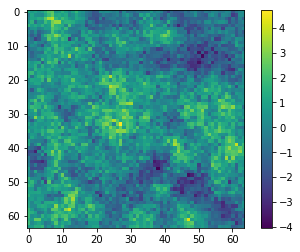

2201 [D loss: 0.623057, acc.: 60.94%] [G loss: 0.844232]
2202 [D loss: 0.492680, acc.: 79.69%] [G loss: 1.549358]
2203 [D loss: 0.434986, acc.: 89.06%] [G loss: 1.199866]
2204 [D loss: 0.541279, acc.: 70.31%] [G loss: 1.169031]
2205 [D loss: 0.465970, acc.: 81.25%] [G loss: 0.796454]
2206 [D loss: 0.824286, acc.: 56.25%] [G loss: 1.251747]
2207 [D loss: 0.491118, acc.: 75.00%] [G loss: 1.610039]
2208 [D loss: 0.580709, acc.: 75.00%] [G loss: 1.209632]
2209 [D loss: 0.828497, acc.: 48.44%] [G loss: 0.887084]
2210 [D loss: 1.009591, acc.: 39.06%] [G loss: 0.781482]
2211 [D loss: 0.758103, acc.: 56.25%] [G loss: 0.927426]
2212 [D loss: 0.671205, acc.: 64.06%] [G loss: 0.940052]
2213 [D loss: 0.728464, acc.: 59.38%] [G loss: 0.982191]
2214 [D loss: 0.684002, acc.: 59.38%] [G loss: 0.881633]
2215 [D loss: 0.735148, acc.: 50.00%] [G loss: 0.806962]
2216 [D loss: 0.684066, acc.: 51.56%] [G loss: 0.942696]
2217 [D loss: 0.633751, acc.: 60.94%] [G loss: 0.815013]
2218 [D loss: 0.649090, acc.: 6

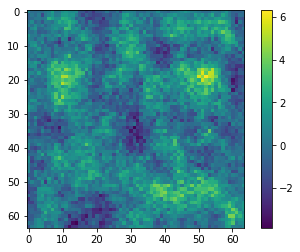

2221 [D loss: 0.536026, acc.: 79.69%] [G loss: 1.140338]
2222 [D loss: 0.546208, acc.: 71.88%] [G loss: 1.104419]
2223 [D loss: 0.605486, acc.: 65.62%] [G loss: 0.977560]
2224 [D loss: 0.707258, acc.: 57.81%] [G loss: 0.873403]
2225 [D loss: 0.588419, acc.: 60.94%] [G loss: 1.074216]
2226 [D loss: 0.519956, acc.: 73.44%] [G loss: 0.885658]
2227 [D loss: 0.566635, acc.: 65.62%] [G loss: 0.948136]
2228 [D loss: 0.608289, acc.: 68.75%] [G loss: 1.028586]
2229 [D loss: 0.549317, acc.: 75.00%] [G loss: 0.939324]
2230 [D loss: 0.611458, acc.: 70.31%] [G loss: 0.948638]
2231 [D loss: 0.708425, acc.: 51.56%] [G loss: 0.918952]
2232 [D loss: 0.693275, acc.: 57.81%] [G loss: 0.870851]
2233 [D loss: 0.602309, acc.: 67.19%] [G loss: 0.964970]
2234 [D loss: 0.700910, acc.: 53.12%] [G loss: 0.931660]
2235 [D loss: 0.815708, acc.: 43.75%] [G loss: 0.842137]
2236 [D loss: 0.767874, acc.: 53.12%] [G loss: 0.885475]
2237 [D loss: 0.708103, acc.: 62.50%] [G loss: 0.985231]
2238 [D loss: 0.688603, acc.: 5

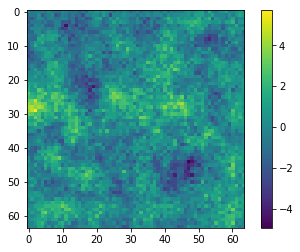

2241 [D loss: 0.738378, acc.: 45.31%] [G loss: 0.845389]
2242 [D loss: 0.739189, acc.: 46.88%] [G loss: 0.914188]
2243 [D loss: 0.674409, acc.: 59.38%] [G loss: 0.811434]
2244 [D loss: 0.684618, acc.: 54.69%] [G loss: 0.779528]
2245 [D loss: 0.684741, acc.: 62.50%] [G loss: 0.740650]
2246 [D loss: 0.661838, acc.: 60.94%] [G loss: 0.940631]
2247 [D loss: 0.604368, acc.: 68.75%] [G loss: 0.933866]
2248 [D loss: 0.640156, acc.: 62.50%] [G loss: 0.863144]
2249 [D loss: 0.686341, acc.: 56.25%] [G loss: 0.817851]
2250 [D loss: 0.728111, acc.: 39.06%] [G loss: 0.789743]
2251 [D loss: 0.603540, acc.: 71.88%] [G loss: 0.848056]
2252 [D loss: 0.632787, acc.: 64.06%] [G loss: 0.919415]
2253 [D loss: 0.551566, acc.: 79.69%] [G loss: 0.883296]
2254 [D loss: 0.577008, acc.: 68.75%] [G loss: 0.979322]
2255 [D loss: 0.599127, acc.: 73.44%] [G loss: 0.887172]
2256 [D loss: 0.601271, acc.: 73.44%] [G loss: 0.826564]
2257 [D loss: 0.629513, acc.: 59.38%] [G loss: 0.771930]
2258 [D loss: 0.506096, acc.: 7

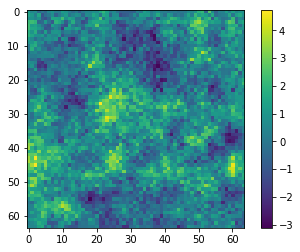

2261 [D loss: 0.534048, acc.: 71.88%] [G loss: 1.076025]
2262 [D loss: 0.593222, acc.: 73.44%] [G loss: 0.813763]
2263 [D loss: 0.553777, acc.: 67.19%] [G loss: 1.153593]
2264 [D loss: 0.549765, acc.: 71.88%] [G loss: 0.923706]
2265 [D loss: 0.520108, acc.: 67.19%] [G loss: 0.825812]
2266 [D loss: 0.497143, acc.: 76.56%] [G loss: 0.909667]
2267 [D loss: 0.567846, acc.: 70.31%] [G loss: 0.848596]
2268 [D loss: 0.464732, acc.: 89.06%] [G loss: 0.986422]
2269 [D loss: 0.499055, acc.: 82.81%] [G loss: 0.850807]
2270 [D loss: 0.590011, acc.: 62.50%] [G loss: 0.791909]
2271 [D loss: 0.605178, acc.: 59.38%] [G loss: 0.847357]
2272 [D loss: 0.644319, acc.: 62.50%] [G loss: 0.931871]
2273 [D loss: 0.609693, acc.: 71.88%] [G loss: 0.970382]
2274 [D loss: 0.660908, acc.: 65.62%] [G loss: 0.706210]
2275 [D loss: 0.661102, acc.: 59.38%] [G loss: 0.716715]
2276 [D loss: 0.648848, acc.: 57.81%] [G loss: 0.706127]
2277 [D loss: 0.626367, acc.: 59.38%] [G loss: 0.716897]
2278 [D loss: 0.680661, acc.: 5

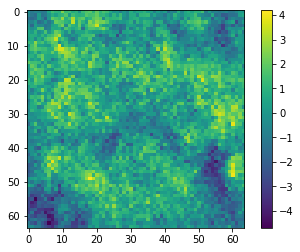

2281 [D loss: 0.560763, acc.: 70.31%] [G loss: 0.739409]
2282 [D loss: 0.561000, acc.: 78.12%] [G loss: 0.785830]
2283 [D loss: 0.485312, acc.: 85.94%] [G loss: 0.729132]
2284 [D loss: 0.528580, acc.: 76.56%] [G loss: 0.769940]
2285 [D loss: 0.453421, acc.: 85.94%] [G loss: 0.823883]
2286 [D loss: 0.431185, acc.: 81.25%] [G loss: 0.797761]
2287 [D loss: 0.460811, acc.: 87.50%] [G loss: 0.816583]
2288 [D loss: 0.481390, acc.: 79.69%] [G loss: 0.765379]
2289 [D loss: 0.467462, acc.: 79.69%] [G loss: 0.844170]
2290 [D loss: 0.421051, acc.: 81.25%] [G loss: 0.937755]
2291 [D loss: 0.429379, acc.: 79.69%] [G loss: 0.920574]
2292 [D loss: 0.387086, acc.: 84.38%] [G loss: 0.796974]
2293 [D loss: 0.339236, acc.: 90.62%] [G loss: 0.912221]
2294 [D loss: 0.445239, acc.: 82.81%] [G loss: 0.976445]
2295 [D loss: 0.386086, acc.: 85.94%] [G loss: 1.033610]
2296 [D loss: 0.451882, acc.: 82.81%] [G loss: 0.971273]
2297 [D loss: 0.372238, acc.: 87.50%] [G loss: 1.270388]
2298 [D loss: 0.393507, acc.: 8

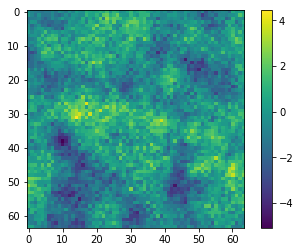

2301 [D loss: 0.503429, acc.: 71.88%] [G loss: 1.272400]
2302 [D loss: 0.619431, acc.: 56.25%] [G loss: 1.176832]
2303 [D loss: 0.603560, acc.: 70.31%] [G loss: 1.165456]
2304 [D loss: 0.580553, acc.: 67.19%] [G loss: 1.192904]
2305 [D loss: 0.534475, acc.: 71.88%] [G loss: 1.202945]
2306 [D loss: 0.652590, acc.: 65.62%] [G loss: 1.395000]
2307 [D loss: 0.539462, acc.: 73.44%] [G loss: 1.253969]
2308 [D loss: 0.661423, acc.: 57.81%] [G loss: 1.160837]
2309 [D loss: 0.582086, acc.: 62.50%] [G loss: 1.095082]
2310 [D loss: 0.703718, acc.: 57.81%] [G loss: 1.257161]
2311 [D loss: 0.638479, acc.: 62.50%] [G loss: 1.058623]
2312 [D loss: 0.606660, acc.: 65.62%] [G loss: 1.080426]
2313 [D loss: 0.611361, acc.: 65.62%] [G loss: 1.105815]
2314 [D loss: 0.846338, acc.: 39.06%] [G loss: 1.029421]
2315 [D loss: 0.516705, acc.: 76.56%] [G loss: 1.073714]
2316 [D loss: 0.524226, acc.: 81.25%] [G loss: 1.244745]
2317 [D loss: 0.494411, acc.: 79.69%] [G loss: 1.286251]
2318 [D loss: 0.418366, acc.: 7

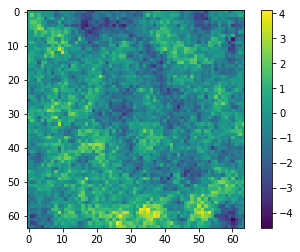

2321 [D loss: 0.420322, acc.: 79.69%] [G loss: 2.047344]
2322 [D loss: 0.454868, acc.: 75.00%] [G loss: 1.670992]
2323 [D loss: 0.570536, acc.: 67.19%] [G loss: 1.505228]
2324 [D loss: 0.564443, acc.: 81.25%] [G loss: 1.545811]
2325 [D loss: 0.605563, acc.: 75.00%] [G loss: 1.477978]
2326 [D loss: 0.585619, acc.: 60.94%] [G loss: 1.052181]
2327 [D loss: 0.522131, acc.: 75.00%] [G loss: 1.236169]
2328 [D loss: 0.547261, acc.: 67.19%] [G loss: 1.109628]
2329 [D loss: 0.579657, acc.: 67.19%] [G loss: 1.029312]
2330 [D loss: 1.091331, acc.: 43.75%] [G loss: 1.067850]
2331 [D loss: 0.538293, acc.: 81.25%] [G loss: 1.415580]
2332 [D loss: 0.521386, acc.: 73.44%] [G loss: 1.324417]
2333 [D loss: 0.652528, acc.: 60.94%] [G loss: 1.168351]
2334 [D loss: 0.564269, acc.: 67.19%] [G loss: 0.766085]
2335 [D loss: 0.677718, acc.: 57.81%] [G loss: 0.824380]
2336 [D loss: 0.603494, acc.: 75.00%] [G loss: 1.254146]
2337 [D loss: 0.621825, acc.: 67.19%] [G loss: 1.286841]
2338 [D loss: 0.668956, acc.: 6

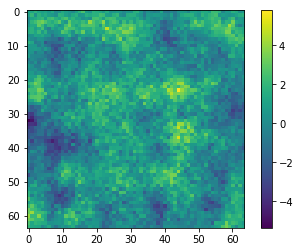

2341 [D loss: 0.908855, acc.: 35.94%] [G loss: 0.893396]
2342 [D loss: 0.800249, acc.: 51.56%] [G loss: 1.204732]
2343 [D loss: 0.745307, acc.: 53.12%] [G loss: 1.202343]
2344 [D loss: 0.694904, acc.: 54.69%] [G loss: 1.065629]
2345 [D loss: 0.882452, acc.: 48.44%] [G loss: 1.022307]
2346 [D loss: 0.824300, acc.: 42.19%] [G loss: 0.887332]
2347 [D loss: 0.840205, acc.: 50.00%] [G loss: 0.937201]
2348 [D loss: 0.747024, acc.: 51.56%] [G loss: 0.867868]
2349 [D loss: 0.759899, acc.: 53.12%] [G loss: 0.870480]
2350 [D loss: 0.658115, acc.: 57.81%] [G loss: 0.976995]
2351 [D loss: 0.716516, acc.: 51.56%] [G loss: 0.851543]
2352 [D loss: 0.763240, acc.: 46.88%] [G loss: 0.873427]
2353 [D loss: 0.699800, acc.: 53.12%] [G loss: 0.837614]
2354 [D loss: 0.713950, acc.: 46.88%] [G loss: 0.848221]
2355 [D loss: 0.697588, acc.: 51.56%] [G loss: 0.818027]
2356 [D loss: 0.702132, acc.: 53.12%] [G loss: 0.859605]
2357 [D loss: 0.652395, acc.: 57.81%] [G loss: 0.881455]
2358 [D loss: 0.650116, acc.: 5

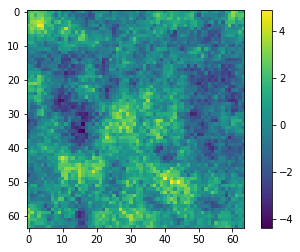

2361 [D loss: 0.639073, acc.: 57.81%] [G loss: 0.795718]
2362 [D loss: 0.661918, acc.: 57.81%] [G loss: 0.816764]
2363 [D loss: 0.658686, acc.: 57.81%] [G loss: 0.830838]
2364 [D loss: 0.670471, acc.: 53.12%] [G loss: 0.823344]
2365 [D loss: 0.638493, acc.: 59.38%] [G loss: 0.815778]
2366 [D loss: 0.677750, acc.: 51.56%] [G loss: 0.816447]
2367 [D loss: 0.647282, acc.: 62.50%] [G loss: 0.821977]
2368 [D loss: 0.658087, acc.: 67.19%] [G loss: 0.782934]
2369 [D loss: 0.683144, acc.: 45.31%] [G loss: 0.656193]
2370 [D loss: 0.767633, acc.: 45.31%] [G loss: 0.766589]
2371 [D loss: 0.648219, acc.: 59.38%] [G loss: 0.792015]
2372 [D loss: 0.637911, acc.: 59.38%] [G loss: 0.774740]
2373 [D loss: 0.647744, acc.: 60.94%] [G loss: 0.820089]
2374 [D loss: 0.653687, acc.: 65.62%] [G loss: 0.848184]
2375 [D loss: 0.645175, acc.: 59.38%] [G loss: 0.783437]
2376 [D loss: 0.631064, acc.: 59.38%] [G loss: 0.770470]
2377 [D loss: 0.611867, acc.: 65.62%] [G loss: 0.816640]
2378 [D loss: 0.607988, acc.: 6

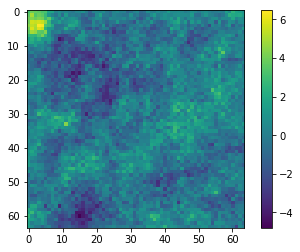

2381 [D loss: 0.621071, acc.: 64.06%] [G loss: 0.811897]
2382 [D loss: 0.655784, acc.: 54.69%] [G loss: 0.841021]
2383 [D loss: 0.587143, acc.: 64.06%] [G loss: 0.835778]
2384 [D loss: 0.614395, acc.: 68.75%] [G loss: 0.790269]
2385 [D loss: 0.623991, acc.: 65.62%] [G loss: 0.826084]
2386 [D loss: 0.579415, acc.: 73.44%] [G loss: 0.797227]
2387 [D loss: 0.628302, acc.: 68.75%] [G loss: 0.768384]
2388 [D loss: 0.607154, acc.: 71.88%] [G loss: 0.788562]
2389 [D loss: 0.691534, acc.: 65.62%] [G loss: 0.754827]
2390 [D loss: 0.628502, acc.: 59.38%] [G loss: 0.845810]
2391 [D loss: 0.615327, acc.: 73.44%] [G loss: 0.891299]
2392 [D loss: 0.656825, acc.: 59.38%] [G loss: 0.896903]
2393 [D loss: 0.660605, acc.: 59.38%] [G loss: 0.781152]
2394 [D loss: 0.718577, acc.: 50.00%] [G loss: 0.833340]
2395 [D loss: 0.604234, acc.: 67.19%] [G loss: 0.914614]
2396 [D loss: 0.606797, acc.: 68.75%] [G loss: 0.871388]
2397 [D loss: 0.665579, acc.: 59.38%] [G loss: 0.866238]
2398 [D loss: 0.643775, acc.: 6

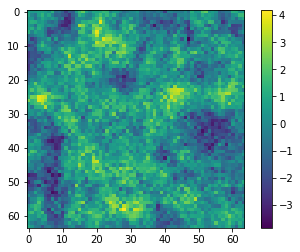

2401 [D loss: 0.649330, acc.: 65.62%] [G loss: 0.817812]
2402 [D loss: 0.611024, acc.: 68.75%] [G loss: 0.799449]
2403 [D loss: 0.631916, acc.: 70.31%] [G loss: 0.846524]
2404 [D loss: 0.741489, acc.: 45.31%] [G loss: 0.762229]
2405 [D loss: 0.622809, acc.: 67.19%] [G loss: 0.817524]
2406 [D loss: 0.623318, acc.: 67.19%] [G loss: 0.876985]
2407 [D loss: 0.584930, acc.: 70.31%] [G loss: 0.889710]
2408 [D loss: 0.583939, acc.: 85.94%] [G loss: 0.894080]
2409 [D loss: 0.532043, acc.: 81.25%] [G loss: 0.841542]
2410 [D loss: 0.539191, acc.: 75.00%] [G loss: 0.800131]
2411 [D loss: 0.618719, acc.: 68.75%] [G loss: 0.996093]
2412 [D loss: 0.423369, acc.: 92.19%] [G loss: 0.969989]
2413 [D loss: 0.427515, acc.: 95.31%] [G loss: 0.936881]
2414 [D loss: 0.405695, acc.: 90.62%] [G loss: 0.905100]
2415 [D loss: 0.451880, acc.: 81.25%] [G loss: 0.883018]
2416 [D loss: 0.480303, acc.: 81.25%] [G loss: 0.948067]
2417 [D loss: 0.453709, acc.: 78.12%] [G loss: 0.973636]
2418 [D loss: 0.490252, acc.: 8

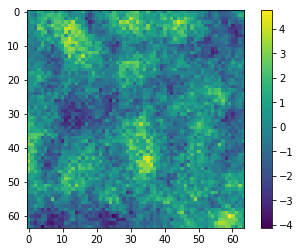

2421 [D loss: 0.504252, acc.: 73.44%] [G loss: 0.979563]
2422 [D loss: 0.453647, acc.: 78.12%] [G loss: 1.022843]
2423 [D loss: 0.475551, acc.: 84.38%] [G loss: 0.944136]
2424 [D loss: 0.477985, acc.: 75.00%] [G loss: 0.979223]
2425 [D loss: 0.621583, acc.: 59.38%] [G loss: 1.039894]
2426 [D loss: 0.560472, acc.: 71.88%] [G loss: 1.333870]
2427 [D loss: 0.526070, acc.: 70.31%] [G loss: 1.295846]
2428 [D loss: 0.586159, acc.: 68.75%] [G loss: 1.030816]
2429 [D loss: 0.676236, acc.: 60.94%] [G loss: 1.068014]
2430 [D loss: 0.507401, acc.: 75.00%] [G loss: 1.162223]
2431 [D loss: 0.504398, acc.: 78.12%] [G loss: 0.987694]
2432 [D loss: 0.441114, acc.: 81.25%] [G loss: 0.986205]
2433 [D loss: 0.607623, acc.: 64.06%] [G loss: 1.011743]
2434 [D loss: 0.927449, acc.: 45.31%] [G loss: 1.058126]
2435 [D loss: 0.663267, acc.: 54.69%] [G loss: 1.015540]
2436 [D loss: 0.696612, acc.: 62.50%] [G loss: 1.127308]
2437 [D loss: 0.711031, acc.: 56.25%] [G loss: 1.152193]
2438 [D loss: 0.720073, acc.: 5

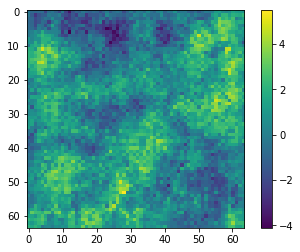

2441 [D loss: 0.726284, acc.: 43.75%] [G loss: 0.964178]
2442 [D loss: 0.692034, acc.: 60.94%] [G loss: 1.049369]
2443 [D loss: 0.645492, acc.: 65.62%] [G loss: 0.886219]
2444 [D loss: 0.664159, acc.: 62.50%] [G loss: 0.973880]
2445 [D loss: 0.646272, acc.: 62.50%] [G loss: 1.010749]
2446 [D loss: 0.741697, acc.: 53.12%] [G loss: 0.848628]
2447 [D loss: 0.680290, acc.: 57.81%] [G loss: 0.998963]
2448 [D loss: 0.628952, acc.: 54.69%] [G loss: 0.969211]
2449 [D loss: 0.646752, acc.: 53.12%] [G loss: 1.089752]
2450 [D loss: 0.704581, acc.: 56.25%] [G loss: 0.936826]
2451 [D loss: 0.744239, acc.: 45.31%] [G loss: 0.917183]
2452 [D loss: 0.758992, acc.: 40.62%] [G loss: 0.848129]
2453 [D loss: 0.743305, acc.: 51.56%] [G loss: 0.852294]
2454 [D loss: 0.667872, acc.: 53.12%] [G loss: 0.874012]
2455 [D loss: 0.765890, acc.: 40.62%] [G loss: 0.875013]
2456 [D loss: 0.676462, acc.: 57.81%] [G loss: 0.971605]
2457 [D loss: 0.716560, acc.: 51.56%] [G loss: 0.859345]
2458 [D loss: 0.711135, acc.: 4

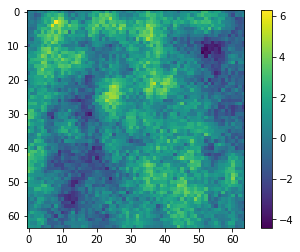

2461 [D loss: 0.709966, acc.: 43.75%] [G loss: 0.934773]
2462 [D loss: 0.678062, acc.: 53.12%] [G loss: 0.897629]
2463 [D loss: 0.706672, acc.: 50.00%] [G loss: 0.871275]
2464 [D loss: 0.678861, acc.: 50.00%] [G loss: 0.864126]
2465 [D loss: 0.705186, acc.: 51.56%] [G loss: 0.888484]
2466 [D loss: 0.699131, acc.: 50.00%] [G loss: 0.859711]
2467 [D loss: 0.707337, acc.: 50.00%] [G loss: 0.832284]
2468 [D loss: 0.685618, acc.: 54.69%] [G loss: 0.814360]
2469 [D loss: 0.703815, acc.: 51.56%] [G loss: 0.785552]
2470 [D loss: 0.704387, acc.: 50.00%] [G loss: 0.761831]
2471 [D loss: 0.696412, acc.: 46.88%] [G loss: 0.781312]
2472 [D loss: 0.704287, acc.: 46.88%] [G loss: 0.759169]
2473 [D loss: 0.688221, acc.: 48.44%] [G loss: 0.747082]
2474 [D loss: 0.704115, acc.: 50.00%] [G loss: 0.758417]
2475 [D loss: 0.692910, acc.: 51.56%] [G loss: 0.767566]
2476 [D loss: 0.688309, acc.: 51.56%] [G loss: 0.766964]
2477 [D loss: 0.673428, acc.: 53.12%] [G loss: 0.758300]
2478 [D loss: 0.669726, acc.: 5

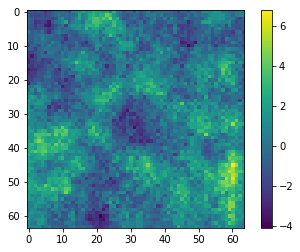

2481 [D loss: 0.708130, acc.: 45.31%] [G loss: 0.727452]
2482 [D loss: 0.692723, acc.: 48.44%] [G loss: 0.766537]
2483 [D loss: 0.692031, acc.: 51.56%] [G loss: 0.746563]
2484 [D loss: 0.680735, acc.: 51.56%] [G loss: 0.754502]
2485 [D loss: 0.663370, acc.: 57.81%] [G loss: 0.750254]
2486 [D loss: 0.679158, acc.: 59.38%] [G loss: 0.762951]
2487 [D loss: 0.653379, acc.: 59.38%] [G loss: 0.747723]
2488 [D loss: 0.657969, acc.: 60.94%] [G loss: 0.721482]
2489 [D loss: 0.691913, acc.: 46.88%] [G loss: 0.720666]
2490 [D loss: 0.660695, acc.: 54.69%] [G loss: 0.732290]
2491 [D loss: 0.664008, acc.: 53.12%] [G loss: 0.730435]
2492 [D loss: 0.654698, acc.: 60.94%] [G loss: 0.722024]
2493 [D loss: 0.681692, acc.: 53.12%] [G loss: 0.690998]
2494 [D loss: 0.635987, acc.: 60.94%] [G loss: 0.705352]
2495 [D loss: 0.738171, acc.: 51.56%] [G loss: 0.756517]
2496 [D loss: 0.667296, acc.: 60.94%] [G loss: 0.745080]
2497 [D loss: 0.673186, acc.: 59.38%] [G loss: 0.736582]
2498 [D loss: 0.642300, acc.: 6

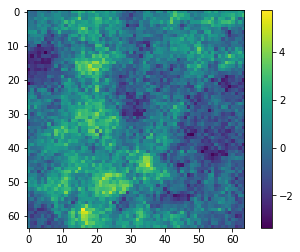

2501 [D loss: 0.674480, acc.: 59.38%] [G loss: 0.771297]
2502 [D loss: 0.714834, acc.: 45.31%] [G loss: 0.722785]
2503 [D loss: 0.732481, acc.: 43.75%] [G loss: 0.725033]
2504 [D loss: 0.678414, acc.: 42.19%] [G loss: 0.781773]
2505 [D loss: 0.651150, acc.: 60.94%] [G loss: 0.761602]
2506 [D loss: 0.682834, acc.: 50.00%] [G loss: 0.781417]
2507 [D loss: 0.660370, acc.: 62.50%] [G loss: 0.821836]
2508 [D loss: 0.657323, acc.: 53.12%] [G loss: 0.752424]
2509 [D loss: 0.649127, acc.: 53.12%] [G loss: 0.773306]
2510 [D loss: 0.660030, acc.: 50.00%] [G loss: 0.809667]
2511 [D loss: 0.637837, acc.: 60.94%] [G loss: 0.832023]
2512 [D loss: 0.594764, acc.: 71.88%] [G loss: 0.785269]
2513 [D loss: 0.619022, acc.: 60.94%] [G loss: 0.788145]
2514 [D loss: 0.592112, acc.: 64.06%] [G loss: 0.784679]
2515 [D loss: 0.623879, acc.: 64.06%] [G loss: 0.847296]
2516 [D loss: 0.586360, acc.: 64.06%] [G loss: 0.849658]
2517 [D loss: 0.630455, acc.: 62.50%] [G loss: 0.770758]
2518 [D loss: 0.642298, acc.: 5

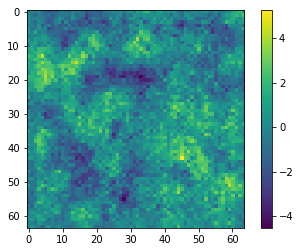

2521 [D loss: 0.569923, acc.: 62.50%] [G loss: 0.867427]
2522 [D loss: 0.613583, acc.: 59.38%] [G loss: 1.034120]
2523 [D loss: 0.603184, acc.: 59.38%] [G loss: 0.949254]
2524 [D loss: 0.635700, acc.: 57.81%] [G loss: 0.960698]
2525 [D loss: 0.626496, acc.: 57.81%] [G loss: 1.208937]
2526 [D loss: 0.662003, acc.: 54.69%] [G loss: 1.120077]
2527 [D loss: 0.660842, acc.: 59.38%] [G loss: 1.122610]
2528 [D loss: 0.654347, acc.: 59.38%] [G loss: 0.876596]
2529 [D loss: 0.660737, acc.: 56.25%] [G loss: 0.813913]
2530 [D loss: 0.680729, acc.: 51.56%] [G loss: 0.797203]
2531 [D loss: 0.695402, acc.: 51.56%] [G loss: 0.816917]
2532 [D loss: 0.693473, acc.: 46.88%] [G loss: 0.726779]
2533 [D loss: 0.695238, acc.: 51.56%] [G loss: 0.719345]
2534 [D loss: 0.726217, acc.: 43.75%] [G loss: 0.719917]
2535 [D loss: 0.692919, acc.: 40.62%] [G loss: 0.730462]
2536 [D loss: 0.693553, acc.: 50.00%] [G loss: 0.720832]
2537 [D loss: 0.676337, acc.: 62.50%] [G loss: 0.746536]
2538 [D loss: 0.696160, acc.: 5

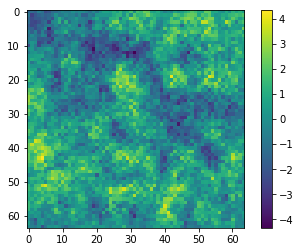

2541 [D loss: 0.704220, acc.: 50.00%] [G loss: 0.751150]
2542 [D loss: 0.691924, acc.: 57.81%] [G loss: 0.781077]
2543 [D loss: 0.681499, acc.: 51.56%] [G loss: 0.811614]
2544 [D loss: 0.668249, acc.: 53.12%] [G loss: 0.852096]
2545 [D loss: 0.671967, acc.: 54.69%] [G loss: 0.801617]
2546 [D loss: 0.679443, acc.: 60.94%] [G loss: 0.793331]
2547 [D loss: 0.675421, acc.: 54.69%] [G loss: 0.828309]
2548 [D loss: 0.681938, acc.: 62.50%] [G loss: 0.779727]
2549 [D loss: 0.679625, acc.: 56.25%] [G loss: 0.774665]
2550 [D loss: 0.717316, acc.: 45.31%] [G loss: 0.759736]
2551 [D loss: 0.681930, acc.: 54.69%] [G loss: 0.716057]
2552 [D loss: 0.678854, acc.: 50.00%] [G loss: 0.717496]
2553 [D loss: 0.710716, acc.: 50.00%] [G loss: 0.666870]
2554 [D loss: 0.645632, acc.: 56.25%] [G loss: 0.709269]
2555 [D loss: 0.693204, acc.: 45.31%] [G loss: 0.778450]
2556 [D loss: 0.648911, acc.: 64.06%] [G loss: 0.765551]
2557 [D loss: 0.667569, acc.: 59.38%] [G loss: 0.798383]
2558 [D loss: 0.661718, acc.: 5

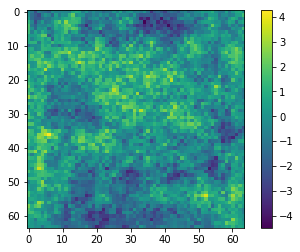

2561 [D loss: 0.662340, acc.: 53.12%] [G loss: 0.749521]
2562 [D loss: 0.645181, acc.: 62.50%] [G loss: 0.730476]
2563 [D loss: 0.710978, acc.: 42.19%] [G loss: 0.659894]
2564 [D loss: 0.713154, acc.: 50.00%] [G loss: 0.715236]
2565 [D loss: 0.648391, acc.: 48.44%] [G loss: 0.768957]
2566 [D loss: 0.639304, acc.: 60.94%] [G loss: 0.867426]
2567 [D loss: 0.656215, acc.: 62.50%] [G loss: 0.861777]
2568 [D loss: 0.626200, acc.: 56.25%] [G loss: 0.867217]
2569 [D loss: 0.636516, acc.: 56.25%] [G loss: 0.800841]
2570 [D loss: 0.637455, acc.: 56.25%] [G loss: 0.880239]
2571 [D loss: 0.619646, acc.: 67.19%] [G loss: 0.986521]
2572 [D loss: 0.633924, acc.: 62.50%] [G loss: 0.865871]
2573 [D loss: 0.648056, acc.: 56.25%] [G loss: 0.859971]
2574 [D loss: 0.615884, acc.: 54.69%] [G loss: 1.008297]
2575 [D loss: 0.641543, acc.: 59.38%] [G loss: 0.950114]
2576 [D loss: 0.670385, acc.: 53.12%] [G loss: 0.777022]
2577 [D loss: 0.665413, acc.: 54.69%] [G loss: 0.806223]
2578 [D loss: 0.633558, acc.: 6

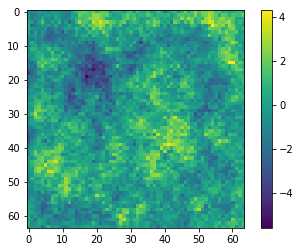

2581 [D loss: 0.643628, acc.: 64.06%] [G loss: 0.840036]
2582 [D loss: 0.701930, acc.: 45.31%] [G loss: 0.836679]
2583 [D loss: 0.676980, acc.: 60.94%] [G loss: 0.772638]
2584 [D loss: 0.703883, acc.: 56.25%] [G loss: 0.825563]
2585 [D loss: 0.655179, acc.: 54.69%] [G loss: 0.924580]
2586 [D loss: 0.620955, acc.: 70.31%] [G loss: 0.972605]
2587 [D loss: 0.694135, acc.: 51.56%] [G loss: 0.856237]
2588 [D loss: 0.679361, acc.: 62.50%] [G loss: 0.783362]
2589 [D loss: 0.719934, acc.: 46.88%] [G loss: 0.769830]
2590 [D loss: 0.650772, acc.: 67.19%] [G loss: 0.770590]
2591 [D loss: 0.653375, acc.: 53.12%] [G loss: 0.835752]
2592 [D loss: 0.643589, acc.: 60.94%] [G loss: 0.829308]
2593 [D loss: 0.643612, acc.: 68.75%] [G loss: 0.768866]
2594 [D loss: 0.689649, acc.: 53.12%] [G loss: 0.748067]
2595 [D loss: 0.669650, acc.: 64.06%] [G loss: 0.738060]
2596 [D loss: 0.676974, acc.: 57.81%] [G loss: 0.744004]
2597 [D loss: 0.665935, acc.: 56.25%] [G loss: 0.757985]
2598 [D loss: 0.641882, acc.: 6

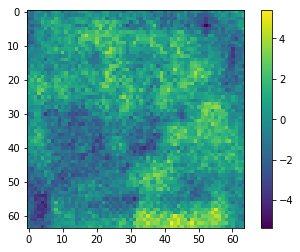

2601 [D loss: 0.655706, acc.: 56.25%] [G loss: 0.870126]
2602 [D loss: 0.714673, acc.: 59.38%] [G loss: 0.942337]
2603 [D loss: 0.564941, acc.: 71.88%] [G loss: 0.967010]
2604 [D loss: 0.574787, acc.: 68.75%] [G loss: 0.967775]
2605 [D loss: 0.502323, acc.: 84.38%] [G loss: 1.026556]
2606 [D loss: 0.502167, acc.: 78.12%] [G loss: 0.978486]
2607 [D loss: 0.447540, acc.: 84.38%] [G loss: 0.854949]
2608 [D loss: 0.516424, acc.: 68.75%] [G loss: 1.025242]
2609 [D loss: 0.531047, acc.: 73.44%] [G loss: 1.108955]
2610 [D loss: 0.496309, acc.: 78.12%] [G loss: 1.406315]
2611 [D loss: 0.580081, acc.: 79.69%] [G loss: 1.306847]
2612 [D loss: 0.644349, acc.: 70.31%] [G loss: 1.081355]
2613 [D loss: 0.721729, acc.: 56.25%] [G loss: 0.968193]
2614 [D loss: 0.912976, acc.: 48.44%] [G loss: 1.011561]
2615 [D loss: 0.670387, acc.: 60.94%] [G loss: 1.041297]
2616 [D loss: 0.678057, acc.: 57.81%] [G loss: 1.044331]
2617 [D loss: 0.654537, acc.: 62.50%] [G loss: 0.915499]
2618 [D loss: 0.720209, acc.: 5

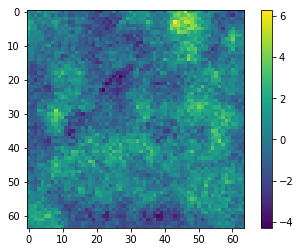

2621 [D loss: 0.679581, acc.: 60.94%] [G loss: 0.843365]
2622 [D loss: 0.592862, acc.: 68.75%] [G loss: 0.789524]
2623 [D loss: 0.612358, acc.: 73.44%] [G loss: 0.846418]
2624 [D loss: 0.734603, acc.: 43.75%] [G loss: 0.715726]
2625 [D loss: 0.692900, acc.: 59.38%] [G loss: 0.786277]
2626 [D loss: 0.754501, acc.: 46.88%] [G loss: 0.901664]
2627 [D loss: 0.668861, acc.: 51.56%] [G loss: 0.886925]
2628 [D loss: 0.667396, acc.: 57.81%] [G loss: 0.864714]
2629 [D loss: 0.727737, acc.: 42.19%] [G loss: 0.853614]
2630 [D loss: 0.754936, acc.: 40.62%] [G loss: 0.792777]
2631 [D loss: 0.762838, acc.: 45.31%] [G loss: 0.758068]
2632 [D loss: 0.722399, acc.: 46.88%] [G loss: 0.835447]
2633 [D loss: 0.742772, acc.: 50.00%] [G loss: 0.815563]
2634 [D loss: 0.676490, acc.: 50.00%] [G loss: 0.854012]
2635 [D loss: 0.702719, acc.: 53.12%] [G loss: 0.827475]
2636 [D loss: 0.689245, acc.: 57.81%] [G loss: 0.875203]
2637 [D loss: 0.673005, acc.: 56.25%] [G loss: 0.884835]
2638 [D loss: 0.710422, acc.: 4

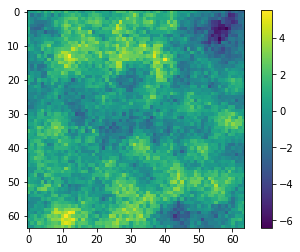

2641 [D loss: 0.714012, acc.: 46.88%] [G loss: 0.759753]
2642 [D loss: 0.682998, acc.: 53.12%] [G loss: 0.838250]
2643 [D loss: 0.690352, acc.: 56.25%] [G loss: 0.893294]
2644 [D loss: 0.649195, acc.: 54.69%] [G loss: 0.854171]
2645 [D loss: 0.636538, acc.: 59.38%] [G loss: 1.007168]
2646 [D loss: 0.699444, acc.: 45.31%] [G loss: 0.960739]
2647 [D loss: 0.679215, acc.: 59.38%] [G loss: 0.871256]
2648 [D loss: 0.665877, acc.: 48.44%] [G loss: 0.894978]
2649 [D loss: 0.638052, acc.: 56.25%] [G loss: 0.815123]
2650 [D loss: 0.655057, acc.: 64.06%] [G loss: 0.953919]
2651 [D loss: 0.635993, acc.: 57.81%] [G loss: 0.920237]
2652 [D loss: 0.631393, acc.: 62.50%] [G loss: 0.929598]
2653 [D loss: 0.623095, acc.: 54.69%] [G loss: 1.074355]
2654 [D loss: 0.643985, acc.: 50.00%] [G loss: 1.007955]
2655 [D loss: 0.620940, acc.: 53.12%] [G loss: 1.025486]
2656 [D loss: 0.636508, acc.: 57.81%] [G loss: 1.040184]
2657 [D loss: 0.641580, acc.: 54.69%] [G loss: 0.998036]
2658 [D loss: 0.619709, acc.: 6

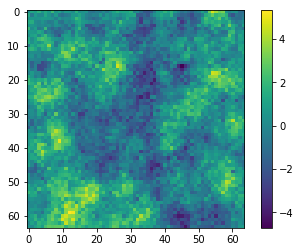

2661 [D loss: 0.645261, acc.: 62.50%] [G loss: 0.882915]
2662 [D loss: 0.726763, acc.: 45.31%] [G loss: 0.761295]
2663 [D loss: 0.715651, acc.: 50.00%] [G loss: 0.798601]
2664 [D loss: 0.703890, acc.: 45.31%] [G loss: 0.749915]
2665 [D loss: 0.770021, acc.: 46.88%] [G loss: 0.694289]
2666 [D loss: 0.688858, acc.: 50.00%] [G loss: 0.694472]
2667 [D loss: 0.684738, acc.: 57.81%] [G loss: 0.650786]
2668 [D loss: 0.685979, acc.: 62.50%] [G loss: 0.665313]
2669 [D loss: 0.740390, acc.: 39.06%] [G loss: 0.658035]
2670 [D loss: 0.640614, acc.: 65.62%] [G loss: 0.655284]
2671 [D loss: 0.691267, acc.: 56.25%] [G loss: 0.656302]
2672 [D loss: 0.674614, acc.: 62.50%] [G loss: 0.684323]
2673 [D loss: 0.633608, acc.: 70.31%] [G loss: 0.666413]
2674 [D loss: 0.663351, acc.: 59.38%] [G loss: 0.668511]
2675 [D loss: 0.629027, acc.: 71.88%] [G loss: 0.689881]
2676 [D loss: 0.596131, acc.: 70.31%] [G loss: 0.649575]
2677 [D loss: 0.682709, acc.: 54.69%] [G loss: 0.616703]
2678 [D loss: 0.638720, acc.: 5

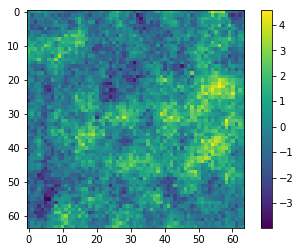

2681 [D loss: 0.646473, acc.: 57.81%] [G loss: 0.645219]
2682 [D loss: 0.674602, acc.: 65.62%] [G loss: 0.784398]
2683 [D loss: 0.667621, acc.: 48.44%] [G loss: 0.656202]
2684 [D loss: 0.654961, acc.: 67.19%] [G loss: 0.852440]
2685 [D loss: 0.663154, acc.: 71.88%] [G loss: 0.813694]
2686 [D loss: 0.626709, acc.: 54.69%] [G loss: 0.816435]
2687 [D loss: 0.686437, acc.: 40.62%] [G loss: 0.735959]
2688 [D loss: 0.634484, acc.: 70.31%] [G loss: 0.814258]
2689 [D loss: 0.684976, acc.: 53.12%] [G loss: 0.801157]
2690 [D loss: 0.690368, acc.: 54.69%] [G loss: 0.792469]
2691 [D loss: 0.713696, acc.: 57.81%] [G loss: 0.749332]
2692 [D loss: 0.662708, acc.: 59.38%] [G loss: 0.810396]
2693 [D loss: 0.690344, acc.: 56.25%] [G loss: 0.798238]
2694 [D loss: 0.690756, acc.: 53.12%] [G loss: 0.721088]
2695 [D loss: 0.682460, acc.: 50.00%] [G loss: 0.788388]
2696 [D loss: 0.704829, acc.: 48.44%] [G loss: 0.794152]
2697 [D loss: 0.668265, acc.: 57.81%] [G loss: 0.732157]
2698 [D loss: 0.670636, acc.: 5

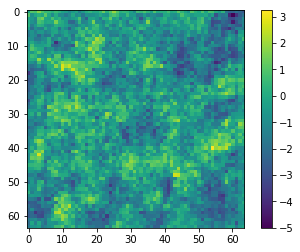

2701 [D loss: 0.655052, acc.: 59.38%] [G loss: 0.728406]
2702 [D loss: 0.671343, acc.: 59.38%] [G loss: 0.765791]
2703 [D loss: 0.694376, acc.: 51.56%] [G loss: 0.741531]
2704 [D loss: 0.627191, acc.: 64.06%] [G loss: 0.790888]
2705 [D loss: 0.681847, acc.: 54.69%] [G loss: 0.759253]
2706 [D loss: 0.656769, acc.: 56.25%] [G loss: 0.756797]
2707 [D loss: 0.667419, acc.: 56.25%] [G loss: 0.688487]
2708 [D loss: 0.649519, acc.: 70.31%] [G loss: 0.731569]
2709 [D loss: 0.664415, acc.: 60.94%] [G loss: 0.704785]
2710 [D loss: 0.634881, acc.: 60.94%] [G loss: 0.714022]
2711 [D loss: 0.571292, acc.: 71.88%] [G loss: 0.757540]
2712 [D loss: 0.656150, acc.: 64.06%] [G loss: 0.738500]
2713 [D loss: 0.668634, acc.: 62.50%] [G loss: 0.764227]
2714 [D loss: 0.688581, acc.: 46.88%] [G loss: 0.860929]
2715 [D loss: 0.605303, acc.: 59.38%] [G loss: 0.966119]
2716 [D loss: 0.653280, acc.: 53.12%] [G loss: 0.957152]
2717 [D loss: 0.638739, acc.: 59.38%] [G loss: 1.000059]
2718 [D loss: 0.654038, acc.: 6

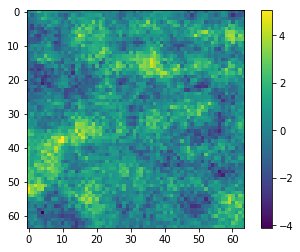

2721 [D loss: 0.767672, acc.: 40.62%] [G loss: 0.775287]
2722 [D loss: 0.708255, acc.: 50.00%] [G loss: 0.726872]
2723 [D loss: 0.690075, acc.: 46.88%] [G loss: 0.706712]
2724 [D loss: 0.686081, acc.: 50.00%] [G loss: 0.676873]
2725 [D loss: 0.653400, acc.: 60.94%] [G loss: 0.670954]
2726 [D loss: 0.649515, acc.: 60.94%] [G loss: 0.730733]
2727 [D loss: 0.637626, acc.: 70.31%] [G loss: 0.704808]
2728 [D loss: 0.616533, acc.: 48.44%] [G loss: 0.722627]
2729 [D loss: 0.679459, acc.: 53.12%] [G loss: 0.722751]
2730 [D loss: 0.595092, acc.: 65.62%] [G loss: 0.719853]
2731 [D loss: 0.676295, acc.: 57.81%] [G loss: 0.792087]
2732 [D loss: 0.613921, acc.: 65.62%] [G loss: 0.784179]
2733 [D loss: 0.587059, acc.: 81.25%] [G loss: 0.753893]
2734 [D loss: 0.633035, acc.: 53.12%] [G loss: 0.737227]
2735 [D loss: 0.615135, acc.: 62.50%] [G loss: 0.754983]
2736 [D loss: 0.679630, acc.: 54.69%] [G loss: 0.722258]
2737 [D loss: 0.612518, acc.: 68.75%] [G loss: 0.726860]
2738 [D loss: 0.698833, acc.: 5

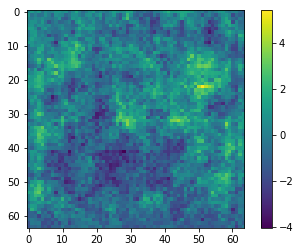

2741 [D loss: 0.695121, acc.: 54.69%] [G loss: 0.776110]
2742 [D loss: 0.699070, acc.: 54.69%] [G loss: 0.724908]
2743 [D loss: 0.675575, acc.: 60.94%] [G loss: 0.738377]
2744 [D loss: 0.722427, acc.: 48.44%] [G loss: 0.673986]
2745 [D loss: 0.732739, acc.: 35.94%] [G loss: 0.715909]
2746 [D loss: 0.657236, acc.: 60.94%] [G loss: 0.721636]
2747 [D loss: 0.713692, acc.: 40.62%] [G loss: 0.725724]
2748 [D loss: 0.682479, acc.: 51.56%] [G loss: 0.745301]
2749 [D loss: 0.687652, acc.: 51.56%] [G loss: 0.707774]
2750 [D loss: 0.672098, acc.: 56.25%] [G loss: 0.715097]
2751 [D loss: 0.693388, acc.: 56.25%] [G loss: 0.681844]
2752 [D loss: 0.706057, acc.: 43.75%] [G loss: 0.733181]
2753 [D loss: 0.678666, acc.: 56.25%] [G loss: 0.726929]
2754 [D loss: 0.707690, acc.: 60.94%] [G loss: 0.688497]
2755 [D loss: 0.668805, acc.: 51.56%] [G loss: 0.689718]
2756 [D loss: 0.667820, acc.: 56.25%] [G loss: 0.672195]
2757 [D loss: 0.668429, acc.: 56.25%] [G loss: 0.694943]
2758 [D loss: 0.617385, acc.: 6

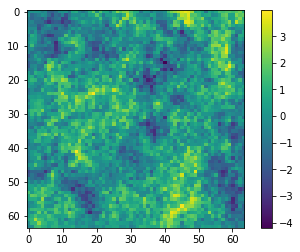

2761 [D loss: 0.626263, acc.: 70.31%] [G loss: 0.695006]
2762 [D loss: 0.619379, acc.: 70.31%] [G loss: 0.706997]
2763 [D loss: 0.622600, acc.: 64.06%] [G loss: 0.702434]
2764 [D loss: 0.629883, acc.: 70.31%] [G loss: 0.686049]
2765 [D loss: 0.608559, acc.: 60.94%] [G loss: 0.731499]
2766 [D loss: 0.586537, acc.: 71.88%] [G loss: 0.812160]
2767 [D loss: 0.572417, acc.: 73.44%] [G loss: 0.800408]
2768 [D loss: 0.587471, acc.: 71.88%] [G loss: 0.790988]
2769 [D loss: 0.605461, acc.: 70.31%] [G loss: 0.771634]
2770 [D loss: 0.662873, acc.: 57.81%] [G loss: 0.755694]
2771 [D loss: 0.665596, acc.: 59.38%] [G loss: 0.734365]
2772 [D loss: 0.606227, acc.: 68.75%] [G loss: 0.904196]
2773 [D loss: 0.565810, acc.: 73.44%] [G loss: 0.881162]
2774 [D loss: 0.606175, acc.: 71.88%] [G loss: 0.929856]
2775 [D loss: 0.722995, acc.: 54.69%] [G loss: 0.928811]
2776 [D loss: 0.623214, acc.: 64.06%] [G loss: 0.750753]
2777 [D loss: 0.687706, acc.: 65.62%] [G loss: 0.940160]
2778 [D loss: 0.646986, acc.: 6

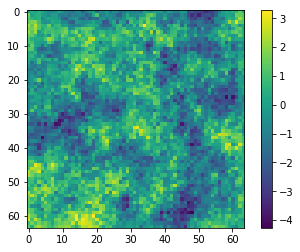

2781 [D loss: 0.690627, acc.: 56.25%] [G loss: 0.871650]
2782 [D loss: 0.683529, acc.: 56.25%] [G loss: 0.884466]
2783 [D loss: 0.667864, acc.: 54.69%] [G loss: 0.925974]
2784 [D loss: 0.631280, acc.: 65.62%] [G loss: 0.861639]
2785 [D loss: 0.689946, acc.: 48.44%] [G loss: 0.831356]
2786 [D loss: 0.652559, acc.: 56.25%] [G loss: 0.806142]
2787 [D loss: 0.592202, acc.: 70.31%] [G loss: 0.956168]
2788 [D loss: 0.563501, acc.: 68.75%] [G loss: 0.888711]
2789 [D loss: 0.574795, acc.: 64.06%] [G loss: 0.762671]
2790 [D loss: 0.647863, acc.: 59.38%] [G loss: 0.900040]
2791 [D loss: 0.544318, acc.: 60.94%] [G loss: 0.911962]
2792 [D loss: 0.623442, acc.: 62.50%] [G loss: 0.841828]
2793 [D loss: 0.575988, acc.: 75.00%] [G loss: 0.899741]
2794 [D loss: 0.854262, acc.: 48.44%] [G loss: 0.838961]
2795 [D loss: 0.882315, acc.: 42.19%] [G loss: 1.152642]
2796 [D loss: 0.566919, acc.: 67.19%] [G loss: 1.347910]
2797 [D loss: 0.680514, acc.: 56.25%] [G loss: 1.330691]
2798 [D loss: 0.772187, acc.: 5

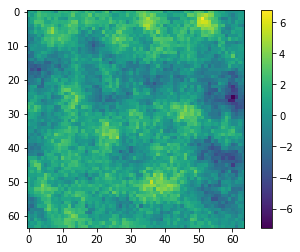

2801 [D loss: 0.702414, acc.: 54.69%] [G loss: 0.916437]
2802 [D loss: 0.709631, acc.: 56.25%] [G loss: 0.759820]
2803 [D loss: 0.777129, acc.: 50.00%] [G loss: 0.763767]
2804 [D loss: 0.760170, acc.: 43.75%] [G loss: 0.786543]
2805 [D loss: 0.713569, acc.: 43.75%] [G loss: 0.828202]
2806 [D loss: 0.644076, acc.: 60.94%] [G loss: 0.840873]
2807 [D loss: 0.690132, acc.: 54.69%] [G loss: 0.786526]
2808 [D loss: 0.678280, acc.: 50.00%] [G loss: 0.804131]
2809 [D loss: 0.671556, acc.: 53.12%] [G loss: 0.791840]
2810 [D loss: 0.716055, acc.: 45.31%] [G loss: 0.820735]
2811 [D loss: 0.672458, acc.: 51.56%] [G loss: 0.820414]
2812 [D loss: 0.673916, acc.: 56.25%] [G loss: 0.780387]
2813 [D loss: 0.674442, acc.: 51.56%] [G loss: 0.805987]
2814 [D loss: 0.711873, acc.: 50.00%] [G loss: 0.790107]
2815 [D loss: 0.683329, acc.: 54.69%] [G loss: 0.751740]
2816 [D loss: 0.670829, acc.: 48.44%] [G loss: 0.732283]
2817 [D loss: 0.683786, acc.: 53.12%] [G loss: 0.827917]
2818 [D loss: 0.671912, acc.: 5

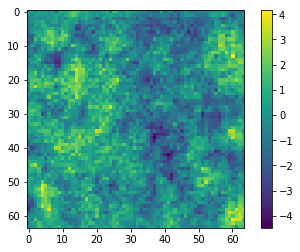

2821 [D loss: 0.703719, acc.: 45.31%] [G loss: 0.805714]
2822 [D loss: 0.631997, acc.: 62.50%] [G loss: 0.750491]
2823 [D loss: 0.663866, acc.: 53.12%] [G loss: 0.735938]
2824 [D loss: 0.646548, acc.: 65.62%] [G loss: 0.811361]
2825 [D loss: 0.666454, acc.: 51.56%] [G loss: 0.737938]
2826 [D loss: 0.656602, acc.: 59.38%] [G loss: 0.743381]
2827 [D loss: 0.731493, acc.: 53.12%] [G loss: 0.787636]
2828 [D loss: 0.657703, acc.: 53.12%] [G loss: 0.816927]
2829 [D loss: 0.674419, acc.: 62.50%] [G loss: 0.808416]
2830 [D loss: 0.672280, acc.: 56.25%] [G loss: 0.783264]
2831 [D loss: 0.695701, acc.: 54.69%] [G loss: 0.694934]
2832 [D loss: 0.673925, acc.: 56.25%] [G loss: 0.718020]
2833 [D loss: 0.759795, acc.: 59.38%] [G loss: 0.647190]
2834 [D loss: 0.646580, acc.: 62.50%] [G loss: 0.641560]
2835 [D loss: 0.758136, acc.: 56.25%] [G loss: 0.658557]
2836 [D loss: 0.714828, acc.: 51.56%] [G loss: 0.705799]
2837 [D loss: 0.656655, acc.: 56.25%] [G loss: 0.748063]
2838 [D loss: 0.677329, acc.: 6

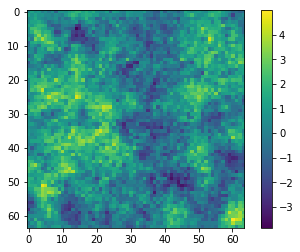

2841 [D loss: 0.701737, acc.: 57.81%] [G loss: 0.749706]
2842 [D loss: 0.634443, acc.: 62.50%] [G loss: 0.800384]
2843 [D loss: 0.643632, acc.: 67.19%] [G loss: 0.823517]
2844 [D loss: 0.588071, acc.: 67.19%] [G loss: 0.814164]
2845 [D loss: 0.651826, acc.: 54.69%] [G loss: 0.897571]
2846 [D loss: 0.664300, acc.: 59.38%] [G loss: 0.832262]
2847 [D loss: 0.591484, acc.: 60.94%] [G loss: 0.914875]
2848 [D loss: 0.652617, acc.: 62.50%] [G loss: 0.788296]
2849 [D loss: 0.624043, acc.: 59.38%] [G loss: 0.686058]
2850 [D loss: 0.676330, acc.: 60.94%] [G loss: 0.817602]
2851 [D loss: 0.636198, acc.: 62.50%] [G loss: 0.809747]
2852 [D loss: 0.666000, acc.: 56.25%] [G loss: 0.713431]
2853 [D loss: 0.698211, acc.: 48.44%] [G loss: 0.705189]
2854 [D loss: 0.687746, acc.: 51.56%] [G loss: 0.788312]
2855 [D loss: 0.659040, acc.: 57.81%] [G loss: 0.780218]
2856 [D loss: 0.709904, acc.: 48.44%] [G loss: 0.837420]
2857 [D loss: 0.687187, acc.: 59.38%] [G loss: 0.800300]
2858 [D loss: 0.701087, acc.: 5

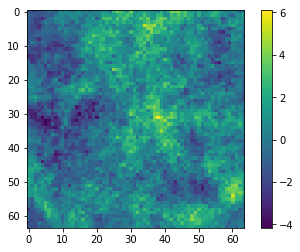

2861 [D loss: 0.677058, acc.: 59.38%] [G loss: 0.812947]
2862 [D loss: 0.661754, acc.: 59.38%] [G loss: 0.840479]
2863 [D loss: 0.700064, acc.: 57.81%] [G loss: 0.843366]
2864 [D loss: 0.696927, acc.: 54.69%] [G loss: 0.745427]
2865 [D loss: 0.679841, acc.: 59.38%] [G loss: 0.740509]
2866 [D loss: 0.721146, acc.: 50.00%] [G loss: 0.800759]
2867 [D loss: 0.676864, acc.: 60.94%] [G loss: 0.806396]
2868 [D loss: 0.648341, acc.: 50.00%] [G loss: 0.864012]
2869 [D loss: 0.701774, acc.: 43.75%] [G loss: 0.707807]
2870 [D loss: 0.653241, acc.: 53.12%] [G loss: 0.837489]
2871 [D loss: 0.659941, acc.: 65.62%] [G loss: 0.826228]
2872 [D loss: 0.605768, acc.: 68.75%] [G loss: 0.856147]
2873 [D loss: 0.641727, acc.: 57.81%] [G loss: 0.873299]
2874 [D loss: 0.688197, acc.: 50.00%] [G loss: 0.893852]
2875 [D loss: 0.671063, acc.: 54.69%] [G loss: 0.929317]
2876 [D loss: 0.604163, acc.: 64.06%] [G loss: 0.934407]
2877 [D loss: 0.629841, acc.: 65.62%] [G loss: 0.881704]
2878 [D loss: 0.631431, acc.: 5

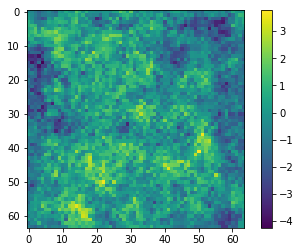

2881 [D loss: 0.764080, acc.: 46.88%] [G loss: 0.733576]
2882 [D loss: 0.681156, acc.: 56.25%] [G loss: 0.767722]
2883 [D loss: 0.727488, acc.: 46.88%] [G loss: 0.819788]
2884 [D loss: 0.751343, acc.: 46.88%] [G loss: 0.852651]
2885 [D loss: 0.691224, acc.: 51.56%] [G loss: 0.797400]
2886 [D loss: 0.680142, acc.: 53.12%] [G loss: 0.790120]
2887 [D loss: 0.686867, acc.: 57.81%] [G loss: 0.848005]
2888 [D loss: 0.697336, acc.: 51.56%] [G loss: 0.837439]
2889 [D loss: 0.674516, acc.: 51.56%] [G loss: 0.750235]
2890 [D loss: 0.700488, acc.: 48.44%] [G loss: 0.770692]
2891 [D loss: 0.691645, acc.: 54.69%] [G loss: 0.784214]
2892 [D loss: 0.682718, acc.: 54.69%] [G loss: 0.832040]
2893 [D loss: 0.691587, acc.: 56.25%] [G loss: 0.822181]
2894 [D loss: 0.662061, acc.: 51.56%] [G loss: 0.825960]
2895 [D loss: 0.652423, acc.: 59.38%] [G loss: 0.968039]
2896 [D loss: 0.670150, acc.: 53.12%] [G loss: 0.920283]
2897 [D loss: 0.648774, acc.: 57.81%] [G loss: 0.855396]
2898 [D loss: 0.665307, acc.: 4

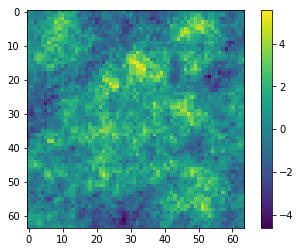

2901 [D loss: 0.683253, acc.: 51.56%] [G loss: 0.751956]
2902 [D loss: 0.664546, acc.: 56.25%] [G loss: 0.729862]
2903 [D loss: 0.642330, acc.: 62.50%] [G loss: 0.718007]
2904 [D loss: 0.678291, acc.: 53.12%] [G loss: 0.752550]
2905 [D loss: 0.643866, acc.: 56.25%] [G loss: 0.796950]
2906 [D loss: 0.636302, acc.: 60.94%] [G loss: 0.760374]
2907 [D loss: 0.628741, acc.: 62.50%] [G loss: 0.783628]
2908 [D loss: 0.668178, acc.: 56.25%] [G loss: 0.842431]
2909 [D loss: 0.652769, acc.: 60.94%] [G loss: 0.763108]
2910 [D loss: 0.635637, acc.: 62.50%] [G loss: 0.760831]
2911 [D loss: 0.708870, acc.: 46.88%] [G loss: 0.718911]
2912 [D loss: 0.664830, acc.: 65.62%] [G loss: 0.747109]
2913 [D loss: 0.687654, acc.: 50.00%] [G loss: 0.761983]
2914 [D loss: 0.672936, acc.: 53.12%] [G loss: 0.787715]
2915 [D loss: 0.647459, acc.: 60.94%] [G loss: 0.825447]
2916 [D loss: 0.641787, acc.: 67.19%] [G loss: 0.769412]
2917 [D loss: 0.665179, acc.: 53.12%] [G loss: 0.828723]
2918 [D loss: 0.643678, acc.: 7

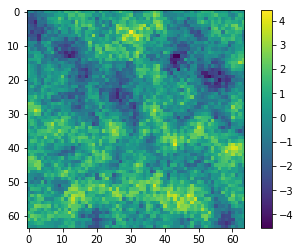

2921 [D loss: 0.655455, acc.: 56.25%] [G loss: 0.832592]
2922 [D loss: 0.641547, acc.: 64.06%] [G loss: 0.792436]
2923 [D loss: 0.678138, acc.: 54.69%] [G loss: 0.773896]
2924 [D loss: 0.772904, acc.: 51.56%] [G loss: 0.754817]
2925 [D loss: 0.677703, acc.: 62.50%] [G loss: 0.773722]
2926 [D loss: 0.727643, acc.: 51.56%] [G loss: 0.733721]
2927 [D loss: 0.670250, acc.: 59.38%] [G loss: 0.790069]
2928 [D loss: 0.667023, acc.: 64.06%] [G loss: 0.856977]
2929 [D loss: 0.627270, acc.: 65.62%] [G loss: 0.842874]
2930 [D loss: 0.651284, acc.: 64.06%] [G loss: 0.771946]
2931 [D loss: 0.687745, acc.: 59.38%] [G loss: 0.742589]
2932 [D loss: 0.669103, acc.: 60.94%] [G loss: 0.697254]
2933 [D loss: 0.655984, acc.: 54.69%] [G loss: 0.787200]
2934 [D loss: 0.691273, acc.: 50.00%] [G loss: 0.686232]
2935 [D loss: 0.645134, acc.: 60.94%] [G loss: 0.714601]
2936 [D loss: 0.639425, acc.: 56.25%] [G loss: 0.774198]
2937 [D loss: 0.647467, acc.: 57.81%] [G loss: 0.773850]
2938 [D loss: 0.576939, acc.: 8

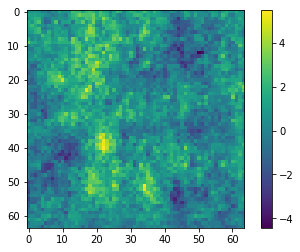

2941 [D loss: 0.697263, acc.: 57.81%] [G loss: 0.782652]
2942 [D loss: 0.675142, acc.: 54.69%] [G loss: 0.861314]
2943 [D loss: 0.651497, acc.: 65.62%] [G loss: 0.795703]
2944 [D loss: 0.753590, acc.: 45.31%] [G loss: 0.802898]
2945 [D loss: 0.751302, acc.: 42.19%] [G loss: 0.740150]
2946 [D loss: 0.710152, acc.: 42.19%] [G loss: 0.804129]
2947 [D loss: 0.716136, acc.: 50.00%] [G loss: 0.768252]
2948 [D loss: 0.690237, acc.: 57.81%] [G loss: 0.786777]
2949 [D loss: 0.685293, acc.: 51.56%] [G loss: 0.777080]
2950 [D loss: 0.691536, acc.: 50.00%] [G loss: 0.792812]
2951 [D loss: 0.656580, acc.: 68.75%] [G loss: 0.796511]
2952 [D loss: 0.687039, acc.: 57.81%] [G loss: 0.798515]
2953 [D loss: 0.681956, acc.: 60.94%] [G loss: 0.817479]
2954 [D loss: 0.622128, acc.: 62.50%] [G loss: 0.767469]
2955 [D loss: 0.668566, acc.: 65.62%] [G loss: 0.783272]
2956 [D loss: 0.622522, acc.: 68.75%] [G loss: 0.818320]
2957 [D loss: 0.601856, acc.: 73.44%] [G loss: 0.780719]
2958 [D loss: 0.614306, acc.: 6

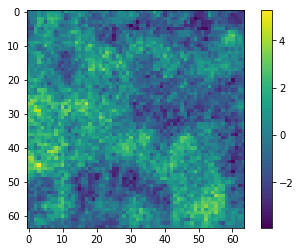

2961 [D loss: 0.496897, acc.: 81.25%] [G loss: 0.912675]
2962 [D loss: 0.452098, acc.: 82.81%] [G loss: 1.024919]
2963 [D loss: 0.684458, acc.: 62.50%] [G loss: 1.017004]
2964 [D loss: 0.634264, acc.: 68.75%] [G loss: 0.976886]
2965 [D loss: 0.653166, acc.: 60.94%] [G loss: 1.071065]
2966 [D loss: 0.662944, acc.: 65.62%] [G loss: 1.038120]
2967 [D loss: 0.710607, acc.: 56.25%] [G loss: 0.796226]
2968 [D loss: 0.667821, acc.: 59.38%] [G loss: 0.835377]
2969 [D loss: 0.662382, acc.: 64.06%] [G loss: 0.856788]
2970 [D loss: 1.038280, acc.: 43.75%] [G loss: 0.909230]
2971 [D loss: 0.788770, acc.: 45.31%] [G loss: 0.976638]
2972 [D loss: 0.734000, acc.: 48.44%] [G loss: 0.820722]
2973 [D loss: 0.768538, acc.: 40.62%] [G loss: 0.751332]
2974 [D loss: 0.695251, acc.: 51.56%] [G loss: 0.794669]
2975 [D loss: 0.704859, acc.: 56.25%] [G loss: 0.793945]
2976 [D loss: 0.695537, acc.: 42.19%] [G loss: 0.902665]
2977 [D loss: 0.653059, acc.: 51.56%] [G loss: 0.954929]
2978 [D loss: 0.650435, acc.: 5

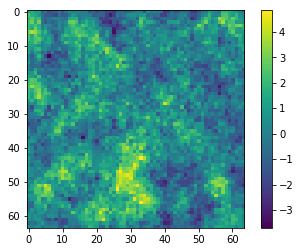

2981 [D loss: 0.609370, acc.: 57.81%] [G loss: 0.825520]
2982 [D loss: 0.682722, acc.: 54.69%] [G loss: 0.790675]
2983 [D loss: 0.690510, acc.: 51.56%] [G loss: 0.797230]
2984 [D loss: 0.608648, acc.: 67.19%] [G loss: 0.835046]
2985 [D loss: 0.660986, acc.: 56.25%] [G loss: 0.953746]
2986 [D loss: 0.712143, acc.: 46.88%] [G loss: 0.824195]
2987 [D loss: 0.684641, acc.: 54.69%] [G loss: 0.812358]
2988 [D loss: 0.661094, acc.: 51.56%] [G loss: 0.797225]
2989 [D loss: 0.654543, acc.: 57.81%] [G loss: 0.815341]
2990 [D loss: 0.741860, acc.: 37.50%] [G loss: 0.763726]
2991 [D loss: 0.678306, acc.: 56.25%] [G loss: 0.742144]
2992 [D loss: 0.699068, acc.: 60.94%] [G loss: 0.790596]
2993 [D loss: 0.764519, acc.: 50.00%] [G loss: 0.817300]
2994 [D loss: 0.733220, acc.: 50.00%] [G loss: 0.809999]
2995 [D loss: 0.701478, acc.: 53.12%] [G loss: 0.819956]
2996 [D loss: 0.677432, acc.: 56.25%] [G loss: 0.785754]
2997 [D loss: 0.674828, acc.: 62.50%] [G loss: 0.779201]
2998 [D loss: 0.698310, acc.: 5

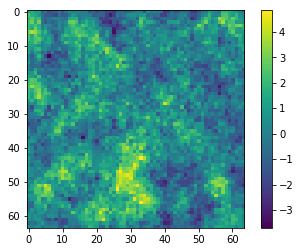

In [110]:
# Train the darn thing
batch_size = 32
epochs = 3000

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

ngen_update = 1

d_hist = []
g_hist = []

for epoch in range(epochs):
    
    #if (epoch//train_chunk) //2*2 != (epoch//train_chunk):
    if True:
        
   #     print("Training discriminator...")

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Generate some true images
        imgs = np.zeros((batch_size, img_rows, img_cols))
        for i in range(batch_size):
            imgs[i] = grf_2d(1.0, alpha=-2.0, normalize=True)
            #imgs[i] = gspot(5.0, 0.05)
        imgs =imgs.reshape((batch_size, img_rows, img_cols, 1))

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate a batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        #discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        
    #    print ("%d [D loss: %f, acc.: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[1]))

    # ---------------------
    #  Train Generator
    # ---------------------
    
    #if (epoch//train_chunk) //2*2 == (epoch//train_chunk):
    for i in range(ngen_update):
        
        #print("Training generator...")

        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        # Train the generator (to have the discriminator label samples as valid)
        #discriminator.trainable = False
        g_loss = combined.train_on_batch(noise, valid)
        
    #    print ("%d [G loss: %f]" % (epoch, g_loss))

    # Plot the progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
    d_hist.append(d_loss[0])
    g_hist.append(g_loss)

    # If at save interval => save generated image samples
    #if epoch % sample_interval == 0:
    #    self.sample_images(epoch)
    
    if epoch % 20 == 0:
        test_img = generator.predict(np.random.normal(0, 1, (1, latent_dim))).reshape(64, 64)
        clf()
        imshow(test_img)
        colorbar()
        display.display(gcf())


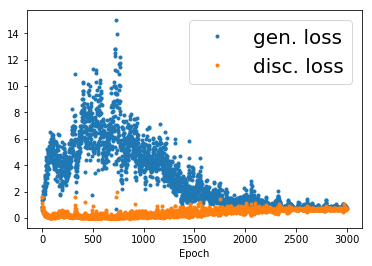

In [111]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

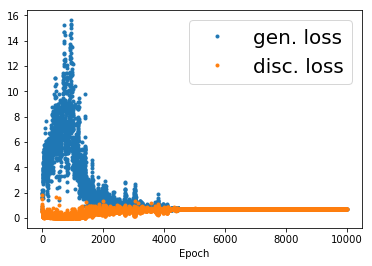

In [102]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

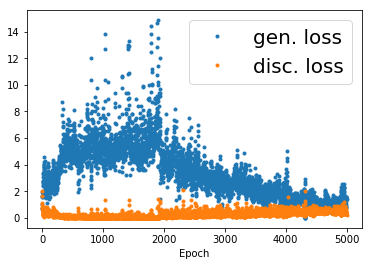

In [218]:
plot(g_hist, '.', label='gen. loss')
plot(d_hist, '.', label='disc. loss')
legend(fontsize = 20.0)
xlabel('Epoch')
#ylim(0.25, 1.25)
#plot(np.array(g_hist) + np.array(d_hist), '.')

In [ ]:
bins = np.linspace()

1.0 1.6805133673525319e-18
1.225918 0.018731361


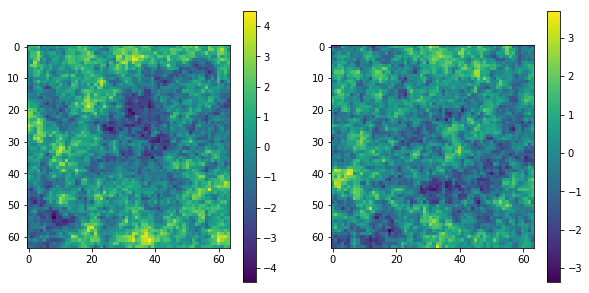

In [113]:
fig = figure(figsize = (10, 5))

test_imgs = []
real_imgs = []
for i in range(128):
    test_imgs.append(generator.predict(np.random.normal(0, 1, (1, latent_dim))).reshape(64, 64))
    real_imgs.append(grf_2d(1.0, alpha=-2.0, normalize=True))
    
test_imgs = np.array(test_imgs)
real_imgs = np.array(real_imgs)

subplot(1,2,1)
imshow(test_imgs[0])
colorbar()
subplot(1,2,2)
imshow(real_imgs[0])
print(np.std(real_imgs.reshape(32, -1), axis=-1).mean(), np.mean(real_imgs.reshape(32, -1), axis=-1).mean())
print(np.std(test_img.reshape(32, -1), axis=-1).mean(), np.mean(test_imgs.reshape(32, -1), axis=-1).mean())
colorbar()

In [53]:
def pk2d(kki, img, nbin=30):
    
    bins = np.linspace(np.min(kki), np.max(kki), nbin+1, endpoint=True)

    ibin = [np.logical_and(kki.ravel() >= bins[i], kki.ravel() < bins[i+1]) for i in range(nbin)]
    ibin = np.array(ibin)

    ft = abs(np.fft.fft2(img))**2
    pkk = np.array([np.mean(ft.ravel()[ibin[i]]) for i in range(nbin)])
    kk = np.array([np.mean(kki.ravel()[ibin[i]]) for i in range(nbin)])

    return kk, pkk

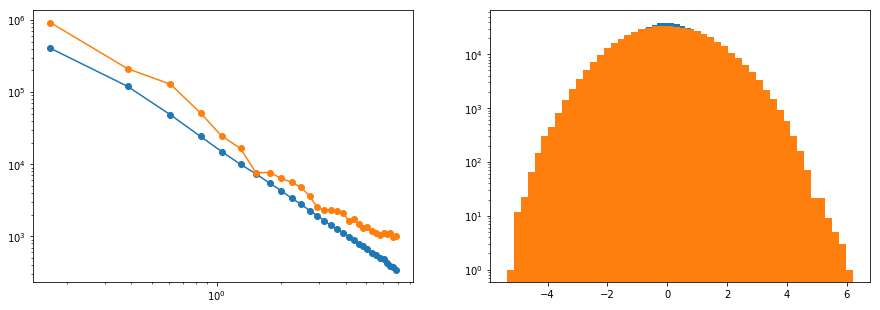

In [114]:
fig = figure(figsize = (15, 5))

kx = np.fft.fftfreq(64, d=0.1)
ky = np.fft.fftfreq(64, d=0.1)
kk = np.sqrt(kx[:, np.newaxis]**2 + ky[np.newaxis, :]**2)

pk1s = []
pk2s = []
for i in range(128):
    k1, pk1 = pk2d(kk, real_imgs[i])
    k2, pk2 = pk2d(kk, test_imgs[i])

    pk1s.append(pk1)
    pk2s.append(pk2)
pk1s = np.array(pk1s)
pk2s = np.array(pk2s)

subplot(1,2,1)
plot(k1, pk1s.mean(0), '-o')
plot(k2, pk2s.mean(0), '-o')
yscale('log')
xscale('log')

subplot(1,2,2)
foo = hist(real_imgs.ravel(), bins=50)
hist(test_imgs.ravel(), bins=50)
yscale('log')

In [ ]:
test_img = generator.predict(np.random.normal(0, 1, (1, latent_dim))).reshape(64, 64)

imshow(test_img)

In [ ]:
real_sample = grf_2d(1.0, alpha=-2.0)
plot(kk.ravel(), abs(np.fft.fft2(real_sample)).ravel(), '.', alpha=0.2)

plot(kk.ravel(), abs(np.fft.fft2(test_img)).ravel(), '.', alpha=0.2)
yscale('log')
xscale('log')
ylim(1e-1, 1e3)

print(np.mean(real_sample), np.std(real_sample))
print(np.mean(test_img), np.std(test_img))